# Setting things up and plotting for tests for `primary_beam_cuda.cu`

First up, here are all the module loads you need to do. Define some constants as well while we're at it

In [1]:
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from copy import deepcopy
import erfa
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mwa_hyperbeam
from subprocess import call

print(mwa_hyperbeam.__version__)

D2R = np.pi / 180.0
VELC = 299792458.0
MWA_LAT = -26.7033194444
MWA_LAT_RAD = MWA_LAT * D2R

lst_rad = 74.15019835*D2R
lst_deg = lst_rad / D2R

zenith_delays = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
off_zenith1_delays = [0, 4, 8, 12, 0, 4, 8, 12, 0, 4, 8, 12, 0, 4, 8, 12]
off_zenith2_delays = [0, 2, 4, 8, 2, 4, 8, 12, 4, 8, 12, 16, 8, 12, 16, 20]

all_delays = [zenith_delays, off_zenith1_delays, off_zenith2_delays]
all_delay_names = ["zenith", "offzen1", "offzen2"]
freqs = [100e+6, 150e+6, 200e+6]

0.6.0


## Creating coordinate files for testing
We will be running both the analytic and hyperdrive MWA beams across a good chunk of sky, and want to plot them, so set up a FITS SIN projection and calculate ha/dec and az/za from that. Don't go quite down to the horizon just so we don't have to deal with corners that end up below the horizon.

0.7853981633974481 1.3169288647340622


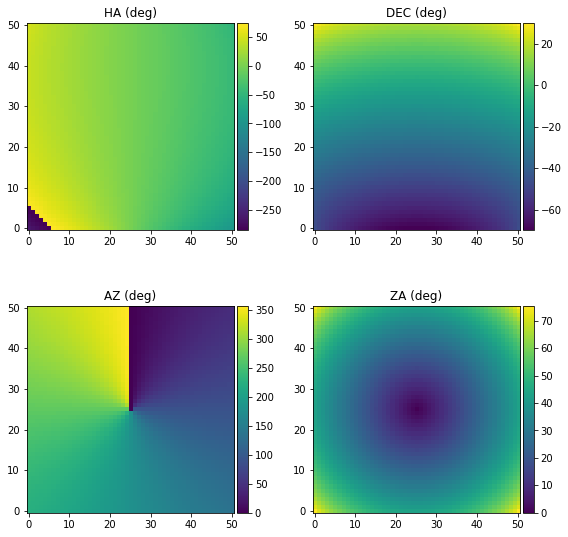

In [2]:
def add_colourbar(fig=None,ax=None,im=None,label=False,top=False):
    """
    Adds a colourbar (colorbar, fine) in a nice way to a subplot

    Parameters
    ----------
    fig : matplotlib.pyplot.figure instance
        The figure that the plot lives on
    ax : matplotlib.pyplot.figure.add_subplot instance
        The axis to append a colorbar to
    im : ax.imshow output
        The output of imshow to base the colourbar on
    label : string
        Optional - add a label to the colorbar
    top : Bool
        Optional - put the colorbar above the axis instead of to the right
    """

    divider = make_axes_locatable(ax)
    if top == True:
        cax = divider.append_axes("top", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax = cax,orientation='horizontal')
        cax.xaxis.set_ticks_position('top')
        cax.xaxis.set_label_position('top')
    else:
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax = cax)
    if label:
        cbar.set_label(label)


##Setup a dummy FITS header with appropriate settings
header = fits.Header()

##Give it 301 pixel for each axis
nside = 51

##This resolution seems to cover the full sky nicely
cpix = int(nside // 2) + 1
cdelt = 0.35
cdelt = 80 / nside

header['NAXIS']   = 2
header['NAXIS1']  = nside
header['NAXIS2']  = nside
header['CTYPE1']  = 'RA---SIN'
header['CRPIX1']  = cpix
header['CRVAL1']  = lst_deg
header['CDELT1']  = cdelt
header['CUNIT1']  = 'deg     '
header['CTYPE2']  = 'DEC--SIN'
header['CRPIX2']  = cpix
header['CRVAL2']  = MWA_LAT
header['CDELT2']  = cdelt
header['CUNIT2']  = 'deg     '

##Make a world coord system
wcs = WCS(header)

##Set up x/y pixels that cover the whole image
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))

x_pixels = x_mesh.flatten()
y_pixels = y_mesh.flatten()

##convert to ra, dec
ras, decs = wcs.all_pix2world(x_pixels, y_pixels, 0.0)

##Then use erfa to convert these values into azs, els
has = lst_deg - ras

##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here
az_grid, els = erfa.hd2ae(has*D2R, decs*D2R, MWA_LAT_RAD)

##convert elevation to zenith angle
za_grid = np.pi/2 - els

print(az_grid[-1], za_grid[-1])

za_grid.shape = (nside,nside)
az_grid.shape = (nside,nside)


##Mask below horizon for better plots
below_horizon = np.where(za_grid > np.pi/2)
az_grid[below_horizon] = np.nan
za_grid[below_horizon] = np.nan

az_flat = az_grid.flatten()
za_flat = za_grid.flatten()


with open('azza_radec_nside{:03d}.h'.format(nside),'w') as outfile:

    az_arr = 'user_precision_t nside{:03d}_azs[] = {{'.format(nside)
    za_arr = 'user_precision_t nside{:03d}_zas[] = {{'.format(nside)
    ra_arr = 'user_precision_t nside{:03d}_ras[] = {{'.format(nside)
    ha_arr = 'user_precision_t nside{:03d}_has[] = {{'.format(nside)
    dec_arr = 'user_precision_t nside{:03d}_decs[] = {{'.format(nside)

    for coord in range(len(az_flat)-1):
        az_arr += '{:.7f},'.format(az_flat[coord])
        za_arr += '{:.7f},'.format(za_flat[coord])
        ra_arr += '{:.7f},'.format(ras[coord]*D2R)
        ha_arr += '{:.7f},'.format(has[coord]*D2R)
        dec_arr += '{:.7f},'.format(decs[coord]*D2R)

    az_arr += '{:.7f}}};\n'.format(az_flat[-1])
    za_arr += '{:.7f}}};\n'.format(za_flat[-1])
    ra_arr += '{:.7f}}};\n'.format(ras[-1]*D2R)
    ha_arr += '{:.7f}}};\n'.format(has[-1]*D2R)
    dec_arr += '{:.7f}}};\n'.format(decs[-1]*D2R)

    outfile.write(az_arr)
    outfile.write(za_arr)
    outfile.write(ra_arr)
    outfile.write(ha_arr)
    outfile.write(dec_arr)


np.savez_compressed("az-za_coords.npz", az_arr=az_flat, za_arr=za_flat, nside=nside)

##Do some fiddling for plotting reasons
has_plot = deepcopy(has)
decs_plot = deepcopy(decs)
azs_plot = az_grid.flatten() / D2R
zas_plot = za_grid.flatten() / D2R

fig, axs = plt.subplots(2,2,figsize=(8,8))

arr_plots = [has_plot, decs_plot, azs_plot, zas_plot]
labels = ['HA (deg)', 'DEC (deg)', 'AZ (deg)', 'ZA (deg)']

for arr, ax, label in zip(arr_plots, axs.flatten(),labels):
    arr.shape = (nside,nside)
    im = ax.imshow(arr,origin='lower')

    ax.set_title(label)

    add_colourbar(ax=ax, im=im, fig=fig)

plt.tight_layout()

fig.savefig('coords_used_nside{:d}.png'.format(nside), bbox_inches='tight')

## Make `hyperbeam` outputs with python to test against
This loops through three frequencies and three pointings, runs `hyperbeam`, and writes out text files of the results.

In [2]:
beam = mwa_hyperbeam.FEEBeam()

gains = [1]*16

array_latitudes = [-0.4660608448386394, -0.498]

for freq in freqs:
    for delays, delay_name in zip(all_delays, all_delay_names):


        coords = np.load('az-za_coords.npz')

        azs = coords['az_arr']
        zas = coords['za_arr']
        nside = coords['nside']
        
        norm_to_zenith = True
        
        with open(f"hyperbeam_{delay_name}_{int(freq/1e+6)}.txt", 'w+') as outfile:
            for latitude in array_latitudes:
                ##Run hyperbeam without parallactic rotation
                all_jones = beam.calc_jones_array(azs, zas, freq, delays, gains, norm_to_zenith)

        #         az_rad, za_rad, freq_hz, delays, amps, norm_to_zenith, array_latitude_rad, iau_order


                for ind in np.arange(len(azs)):

                    gx = all_jones[ind, 0]
                    Dx = all_jones[ind, 1]
                    Dy = all_jones[ind, 2]
                    gy = all_jones[ind, 3]

                    outfile.write(f"{azs[ind]:.16f} {zas[ind]:.16f} "
                                  f"{np.real(gx):.16f} {np.imag(gx):.16f} {np.real(Dx):.16f} {np.imag(Dx):.16f} "
                                  f"{np.real(Dy):.16f} {np.imag(Dy):.16f} {np.real(gy):.16f} {np.imag(gy):.16f} {freq:.6e}\n")



        with open(f"hyperbeam_{delay_name}_{int(freq/1e+6)}_rot.txt", 'w+') as outfile:
            for this_latitude in array_latitudes:
                ##Run hyperbeam with parallactic rotation
                all_jones = beam.calc_jones_array(azs, zas, freq, delays, gains, norm_to_zenith,
                                         this_latitude, True)
                for ind in np.arange(len(azs)):

                    gx = all_jones[ind, 0]
                    Dx = all_jones[ind, 1]
                    Dy = all_jones[ind, 2]
                    gy = all_jones[ind, 3]

                    outfile.write(f"{azs[ind]:.16f} {zas[ind]:.16f} "
                                  f"{np.real(gx):.16f} {np.imag(gx):.16f} {np.real(Dx):.16f} {np.imag(Dx):.16f} "
                                  f"{np.real(Dy):.16f} {np.imag(Dy):.16f} {np.real(gy):.16f} {np.imag(gy):.16f} {freq:.6e}\n")

Then, convert them into a C-style header to be used by the testing code

In [3]:
with open('test_run_hyperbeam.h', 'w') as outfile:

    outfile.write('#include "woden_precision_defs.h"\n\n')

    names = ['zenith_100', 'zenith_150', 'zenith_200',
             'offzen1_100', 'offzen1_150', 'offzen1_200',
             'offzen2_100', 'offzen2_150', 'offzen2_200',
             'zenith_100_rot', 'zenith_150_rot', 'zenith_200_rot',
             'offzen1_100_rot', 'offzen1_150_rot', 'offzen1_200_rot',
             'offzen2_100_rot', 'offzen2_150_rot', 'offzen2_200_rot']

    for name in names:
        az, za, g1r, g1i, D1r, D1i, D2r, D2i, g2r, g2i, freq = np.loadtxt('hyperbeam_{:s}.txt'.format(name), unpack=True)
        outfile.write('double {:s}[] = {{ {:.18f}, {:.18f}, {:.18f}, {:.18f},\n    {:.18f}, {:.18f}, {:.18f}, {:.18f},\n'.format(name,
                                            g1r[0], g1i[0], D1r[0], D1i[0], D2r[0], D2i[0], g2r[0], g2i[0]))

        for ind in range(1,len(az)-1):
            outfile.write('    {:.18f}, {:.18f}, {:.18f}, {:.18f},\n    {:.18f}, {:.18f}, {:.18f}, {:.18f},\n'.format(g1r[ind],
                                         g1i[ind], D1r[ind], D1i[ind], D2r[ind], D2i[ind], g2r[ind], g2i[ind]))

        outfile.write('    {:.18f}, {:.18f}, {:.18f}, {:.18f},\n    {:.18f}, {:.18f}, {:.18f}, {:.18f} }};\n'.format(g1r[-1],
                                     g1i[-1], D1r[-1], D1i[-1], D2r[-1], D2i[-1], g2r[-1], g2i[-1]))

        outfile.write('\n\n')

# Now you need to run `ctest` to generate test outputs
First thing that was actually done after running the plots for MWA analytic and working out if things made sense was to convert the outputs of the MWA analytic run into a header to used to test against. Commented out below as you shouldn't be changing the headers to test against, but included here for full disclosure.

In [5]:
# azs, zas, gx_re, gx_im, Dx_re, Dx_im, Dy_re, Dy_im, gy_re, gy_im, freqs = np.loadtxt(f'../../build/cmake_testing/primary_beam_cuda/MWA_analy_gains_azza{nside*nside}.txt', unpack=True)

# def make_C_array_string(data, name, precision='user_precision_t'):
#     """Takes a numpy array `data` and creates a string to represent a C array
#     of type `precision` with name `name`"""

#     Carray = f'{precision} {name}[] = {{'

#     for d in data[:-1]:
#         Carray +=  f'{d:.8f},'

#     Carray += f'{data[-1]:.8f}}};\n'

#     return Carray

# with open(f'MWA_analy_expected_nside{nside:03d}.h','w') as outfile:

#     gx_re_array = make_C_array_string(gx_re, "gx_re_expec")
#     Dx_re_array = make_C_array_string(Dx_re, "Dx_re_expec")
#     Dy_re_array = make_C_array_string(Dy_re, "Dy_re_expec")
#     gy_re_array = make_C_array_string(gy_re, "gy_re_expec")

#     outfile.write(gx_re_array)
#     outfile.write(Dx_re_array)
#     outfile.write(Dy_re_array)
#     outfile.write(gy_re_array)

# Plotting outputs
Here be some functions to load up `ctest` outputs, and then plot them

In [6]:
def load_data(filename):
    """Load the data out of the C testing code into complex arrays"""
    azs, zas, gx_re, gx_im, Dx_re, Dx_im, Dy_re, Dy_im, gy_re, gy_im, freqs = np.loadtxt(filename, unpack=True)

    gx = gx_re + gx_im*1j
    Dx = Dx_re + Dx_im*1j
    Dy = Dy_re + Dy_im*1j
    gy = gy_re + gy_im*1j

    return azs, zas, gx, Dx, Dy, gy, freqs

def plot_jones_square(azs, zas, gx, Dx, Dy, gy, plot_freqs, filename, tag='MWA_analy',
                      num_freqs=1, num_times=1, limits=True,
                      nside=101):
    """Take the data saved by the C testing code, convert into
    2D arrays and plot with imshow. Plot the gains and leakages
    as well as the linear Stokes pols. saves into the 'plots' dir."""
    outname = filename.split('/')[-1].split('_')[-1]

    num_comps = int(len(azs) / (num_freqs*num_times))

    for time in range(num_times):
        for freq_ind in range(num_freqs):
            freq = plot_freqs[freq_ind]

            low = time*num_freqs*num_comps + freq_ind*num_comps
            high = low + num_comps

            fig, axs = plt.subplots(2, 2, figsize=(12, 12))

            this_gx = gx[low:high]
            this_Dx = Dx[low:high]
            this_Dy = Dy[low:high]
            this_gy = gy[low:high]

            this_gx.shape = (nside, nside)
            this_Dx.shape = (nside, nside)
            this_Dy.shape = (nside, nside)
            this_gy.shape = (nside, nside)

            im1 = axs[0,0].imshow(this_gx.real, origin='lower')
            im2 = axs[0,1].imshow(this_Dx.real, origin='lower')
            im3 = axs[1,0].imshow(this_Dy.real, origin='lower')
            im4 = axs[1,1].imshow(this_gy.real, origin='lower')

            ims = [im1, im2, im3, im4]

            for im, ax in zip(ims, axs.flatten()):
                add_colourbar(im=im, ax=ax, fig=fig)

            axs[0,0].set_title('Real gx')
            axs[0,1].set_title('Real Dx')
            axs[1,0].set_title('Real Dy')
            axs[1,1].set_title('Real gy')
            #
            for ax in axs.flatten():
                ax.set_yticks([])
                ax.set_xticks([])

            savename = f'plots/jones_{tag}_gains_nside{nside:d}_t{time:02d}_f{freq/1e+6:.3f}MHz.png'
            print(savename)
            fig.savefig(savename,bbox_inches='tight')
            plt.show()
            plt.close()


            fig, axs = plt.subplots(2, 2, figsize=(12, 12))

            xx = gx*np.conjugate(gx) + Dx*np.conjugate(Dx)
            xy = this_gx*np.conjugate(this_Dy) + this_Dx*np.conjugate(this_gy)
            yx = this_Dy*np.conjugate(this_gx) + this_gy*np.conjugate(this_Dx)
            yy = gy*np.conjugate(gy) + Dy*np.conjugate(Dy)

            print(np.max(np.abs(xx)), np.max(np.abs(yy)))
            
            if limits:
                vmin_xx = vmin_yy = 0.0
                vmax_xx = vmax_yy = 0.2
            else:
                vmin_xx = np.real(xx).min()
                vmax_xx = np.real(xx).max()
                vmin_yy = np.real(yy).min()
                vmax_yy = np.real(yy).max()
            

            im1 = axs[0,0].imshow(np.real(xx), origin='lower',
                                  vmin=vmin_xx,vmax=vmax_xx)
            im2 = axs[0,1].imshow(np.real(xy), origin='lower')# ,vmin=0,vmax=0.3)
            im3 = axs[1,0].imshow(np.real(yx), origin='lower')# ,vmin=0,vmax=0.3)
            im4 = axs[1,1].imshow(np.real(yy), origin='lower',
                                  vmin=vmin_yy,vmax=vmax_yy)

            ims = [im1, im2, im3, im4]

            for im, ax in zip(ims, axs.flatten()):
                add_colourbar(im=im, ax=ax, fig=fig)

            axs[0,0].set_title('XX')
            axs[0,1].set_title('XY')
            axs[1,0].set_title('YX')
            axs[1,1].set_title('YY')
            #
            for ax in axs.flatten():
                ax.set_yticks([])
                ax.set_xticks([])

            savename = f'plots/linear_pol_{tag}_gains_nside{nside:d}_t{time:02d}_f{freq/1e+6:.3f}MHz.png'
            print(savename)
            fig.savefig(savename,bbox_inches='tight')
            plt.show()
            plt.close()

# Analytic beam plots
Just test the analytic beam for a single off-zenith pointing. Checks that the delays point things in the correct direction when compared to the FEE beam

plots/jones_MWA_analy_gains_nside101_t00_f150.000MHz.png


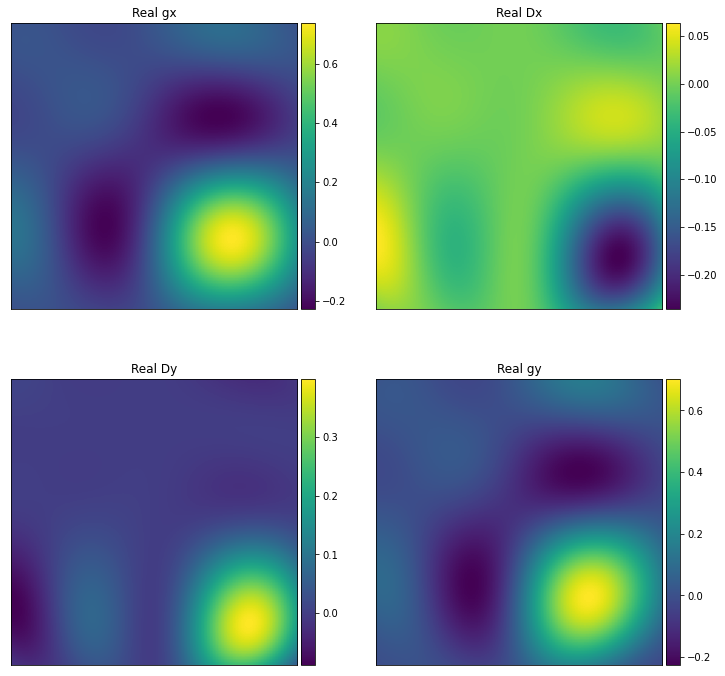

0.5813587945427666 0.5813588045729005
plots/linear_pol_MWA_analy_gains_nside101_t00_f150.000MHz.png


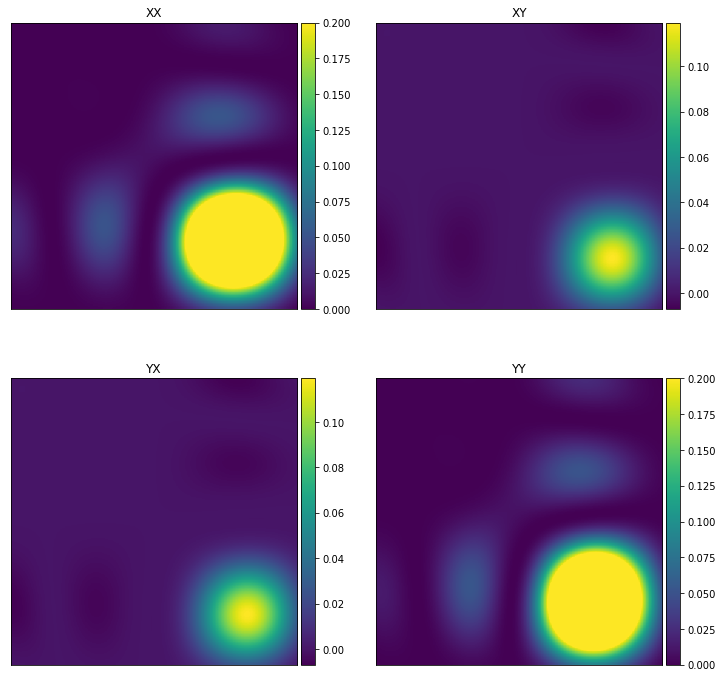

plots/jones_MWA_analy_gains_nside101_t00_f200.000MHz.png


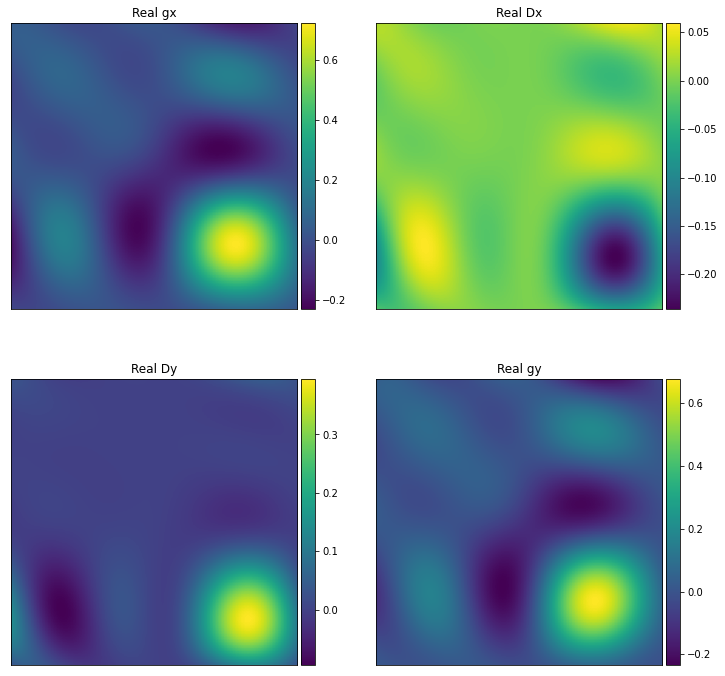

0.5657669599927113 0.5657669371169897
plots/linear_pol_MWA_analy_gains_nside101_t00_f200.000MHz.png


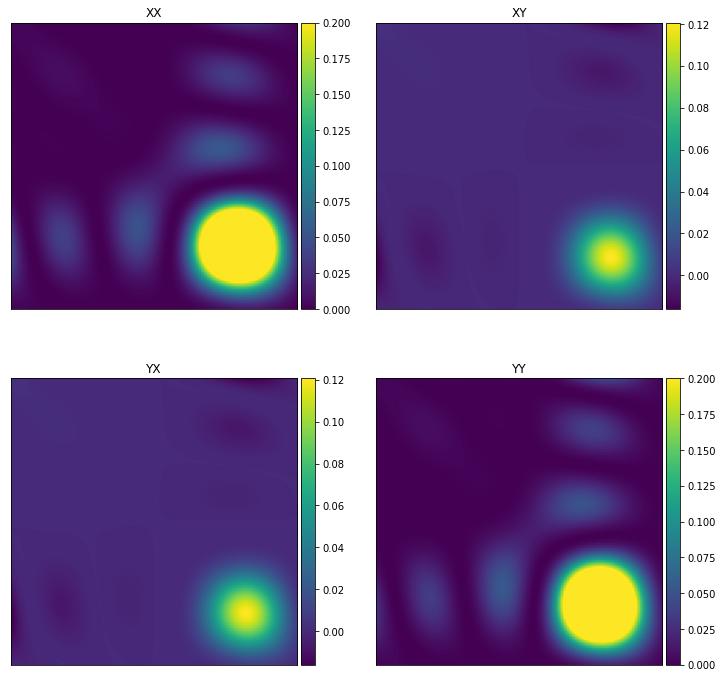

plots/jones_MWA_analy_gains_nside101_t01_f150.000MHz.png


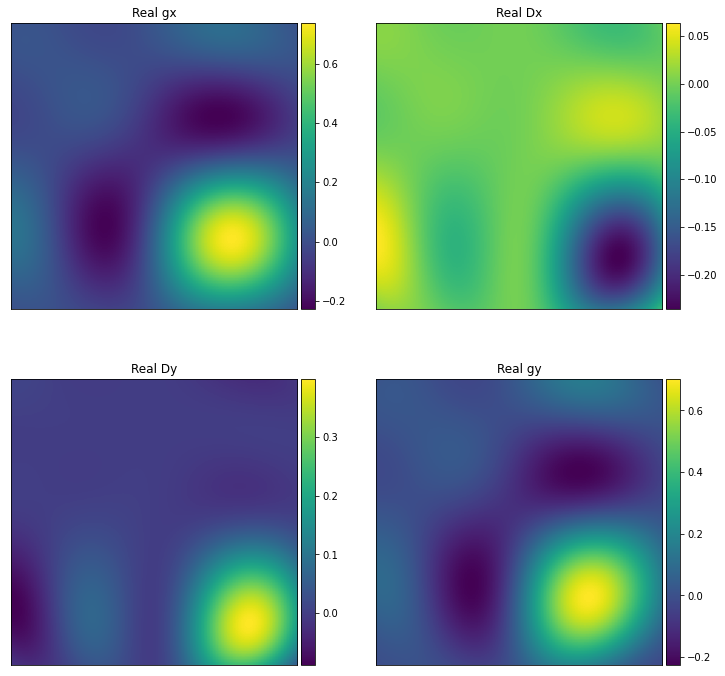

0.5813587945427666 0.5813588045729005
plots/linear_pol_MWA_analy_gains_nside101_t01_f150.000MHz.png


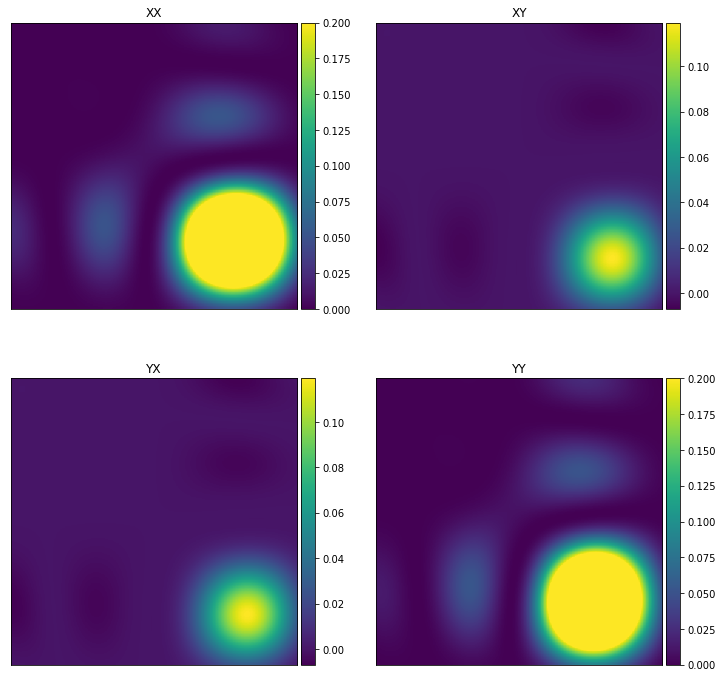

plots/jones_MWA_analy_gains_nside101_t01_f200.000MHz.png


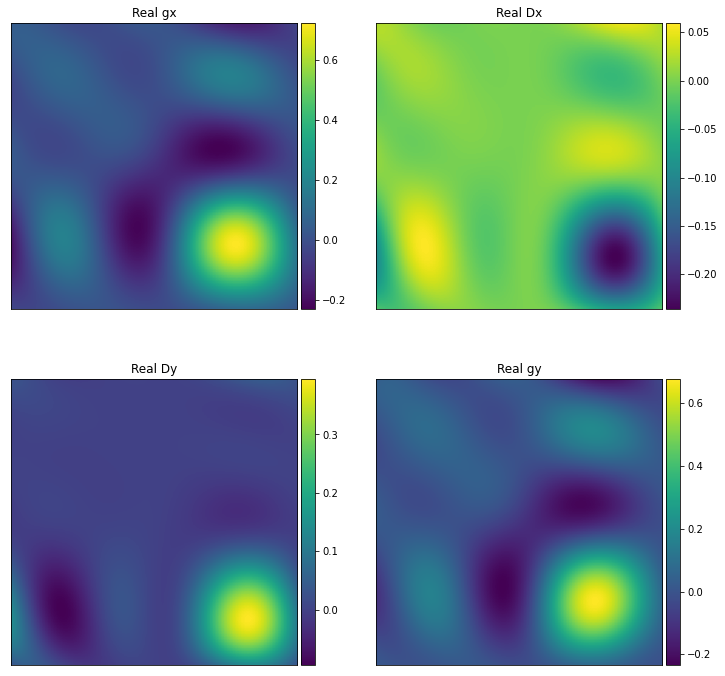

0.5657669599927113 0.5657669371169897
plots/linear_pol_MWA_analy_gains_nside101_t01_f200.000MHz.png


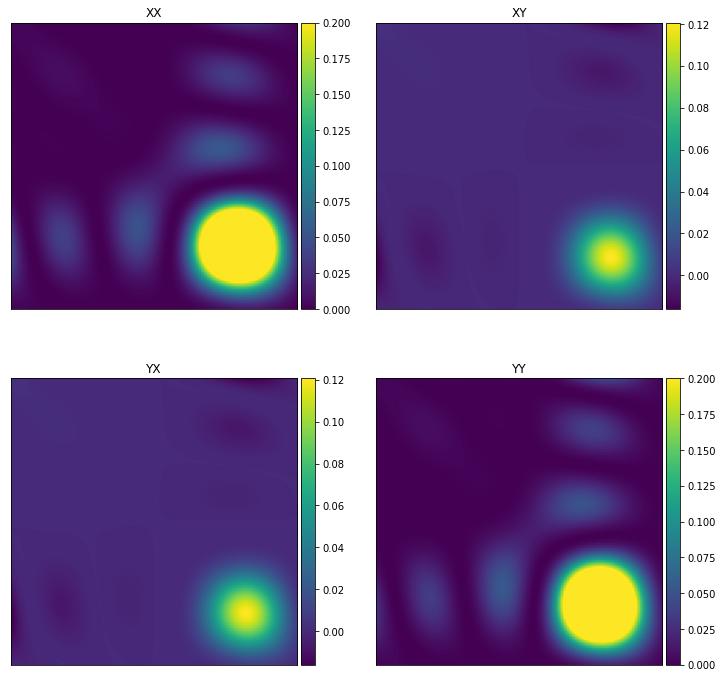

In [7]:
nside = 101

call('mkdir -p plots', shell=True)

plot_freqs = [150e+6, 200e+6]

filename = f'../../build/cmake_testing/primary_beam_cuda/MWA_analy_gains_azza{nside*nside}.txt'
azs, zas, gx, Dx, Dy, gy, freqs = load_data(filename)
plot_jones_square(azs, zas, gx, Dx, Dy, gy, plot_freqs, filename,
                      num_times=2, num_freqs=2, nside=101)

## Compare to the RTS
Using the `cc -D MWATILE_STANDALONE mwa_tile.c` compile option with the `RTS`, and hardcoding the delays to the second offzenith delays, I have made the exectuable `rts_mwa_beam` which runs the RTS analytic beam in one direction. By running:

```
$ python run_rts_analytic_beam.py
```

we get the outputs for 200MHz (Running it takes like 10 minutes as it's doing it in serial on the CPU). Qualitatively they look the same, and the linear polarisations are the same to within ~ 1e-5. Given the `WODEN` code is double and the `RTS` is float this level of agreement is fine.

plots/jones_RTS_analytic_gains_nside101_t00_f150.000MHz.png


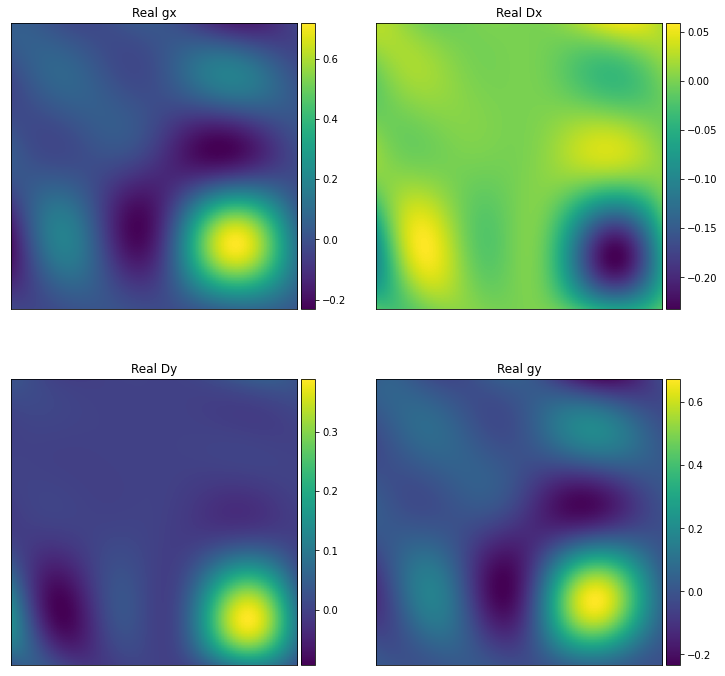

0.5584607188296266 0.5584606307578804
plots/linear_pol_RTS_analytic_gains_nside101_t00_f150.000MHz.png


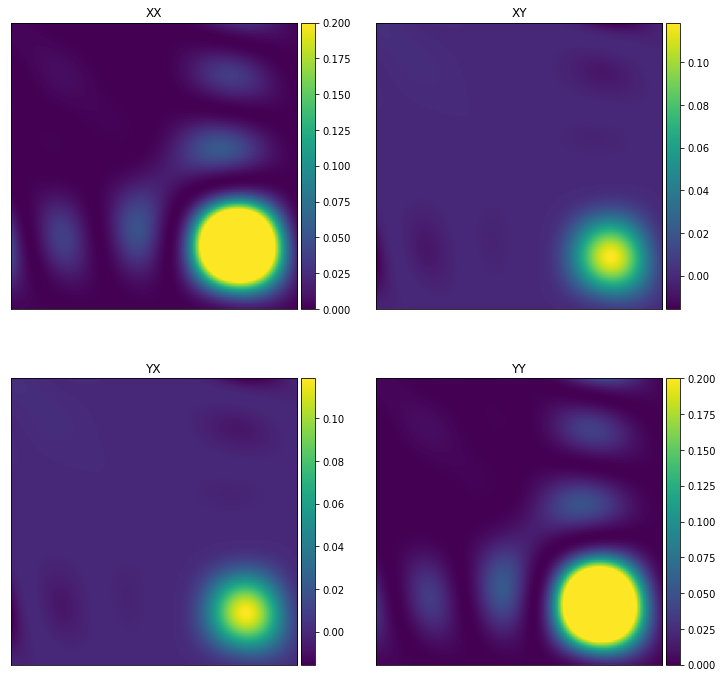

plots/jones_woden_minus_RTS_analytic_gains_nside101_t00_f150.000MHz.png


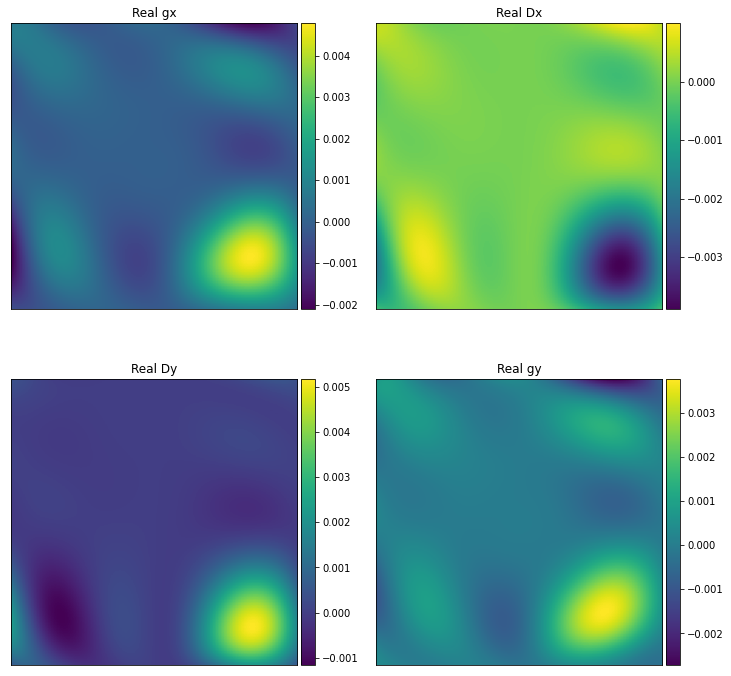

3.739113807955807e-05 3.755655104373435e-05
plots/linear_pol_woden_minus_RTS_analytic_gains_nside101_t00_f150.000MHz.png


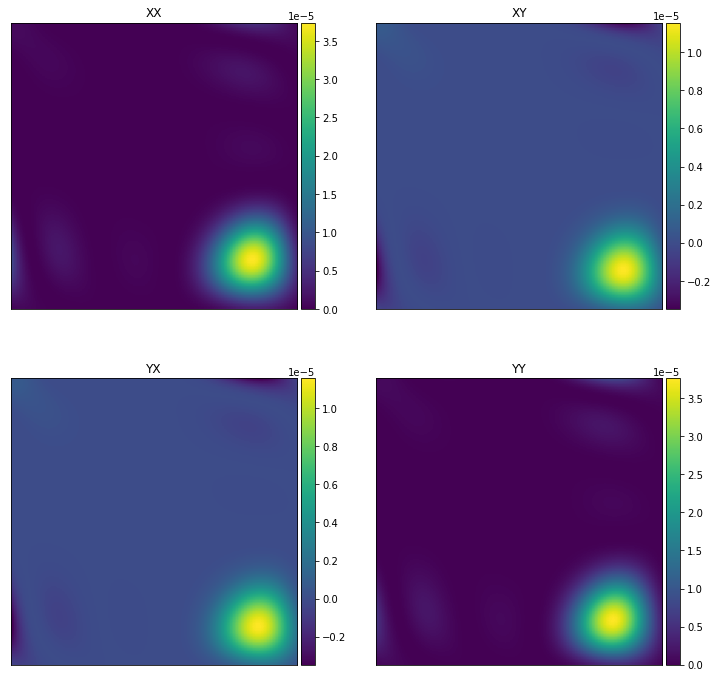

In [8]:
filename = f'../../build/cmake_testing/primary_beam_cuda/MWA_analy_gains_azza{nside*nside}.txt'
azs, zas, gx, Dx, Dy, gy, freqs = load_data(filename)

##We want the 200MHz one here, and the time step doesn't matter
##so just take the last time step/ freq

gx_woden = gx[-nside*nside:]
Dx_woden = Dx[-nside*nside:]
Dy_woden = Dy[-nside*nside:]
gy_woden = gy[-nside*nside:]

filename = f"RTS_analytic_beam_gains_azza{nside*nside}.txt"
azs, zas, gx, Dx, Dy, gy, freqs = load_data(filename)
plot_jones_square(azs, zas, gx, Dx, Dy, gy, plot_freqs, filename, tag=f'RTS_analytic')

plot_jones_square(azs, zas, gx_woden - gx, Dx_woden - Dx, Dy_woden - Dy, gy_woden - gy, plot_freqs, filename,
                  tag=f'woden_minus_RTS_analytic', limits=False,
                  nside=101)

# MWA FEE plots
Let's plot up a bunch of pointings and frequencies, check everything is happy. There should be three frequencies and two time steps for each combination of delays and central frequency. Each central freq was run with three fine frequencies that are so similar, should return the same values. They are testing with the C code, but good to plot them up to see that they make sense on the sky

../../build/cmake_testing/primary_beam_cuda/hyperbeam_zenith_100_rot_double.txt
plots/jones_hyperbeam_rot_zenith_gains_nside51_t00_f99.600MHz.png


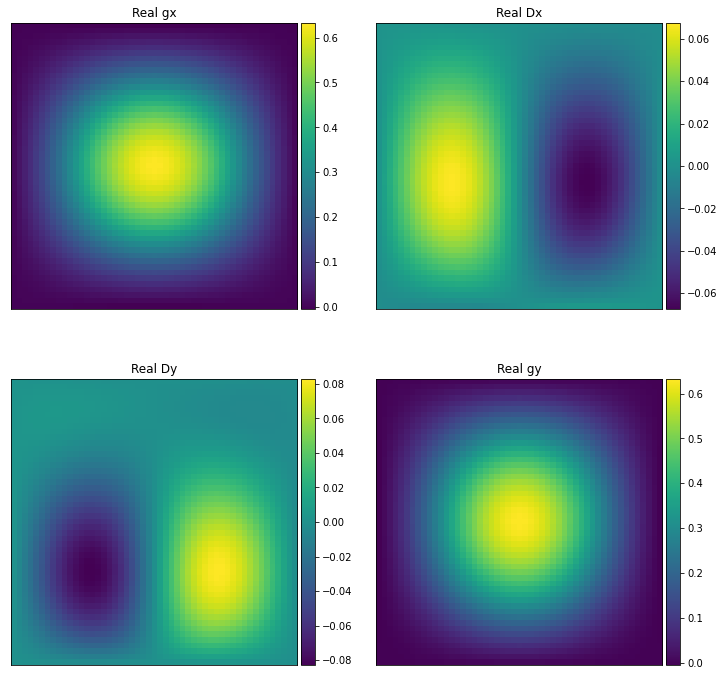

1.0000000928967272 1.0000000932234652
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t00_f99.600MHz.png


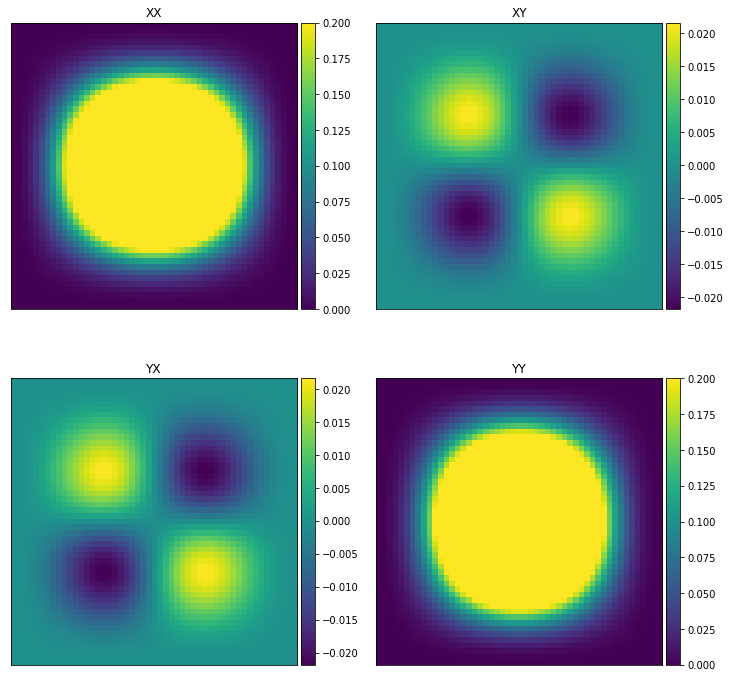

plots/jones_hyperbeam_rot_zenith_gains_nside51_t00_f100.000MHz.png


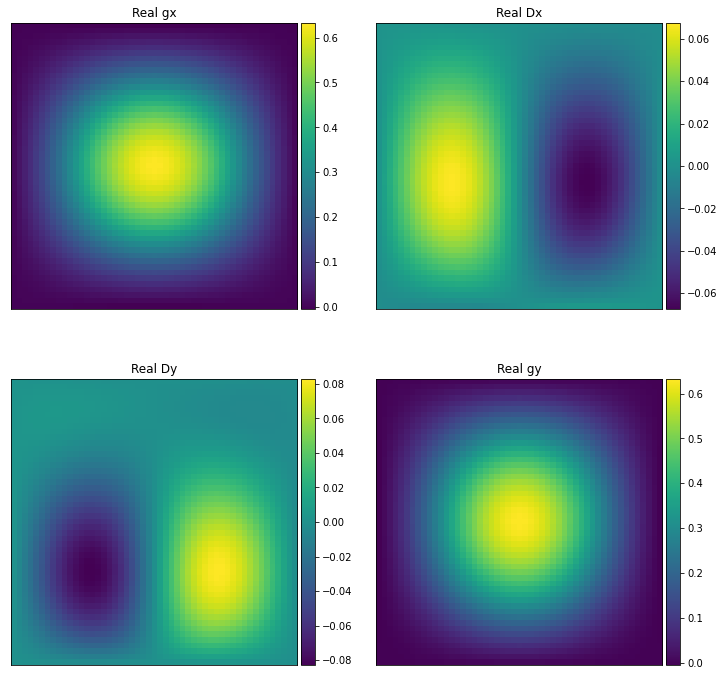

1.0000000928967272 1.0000000932234652
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t00_f100.000MHz.png


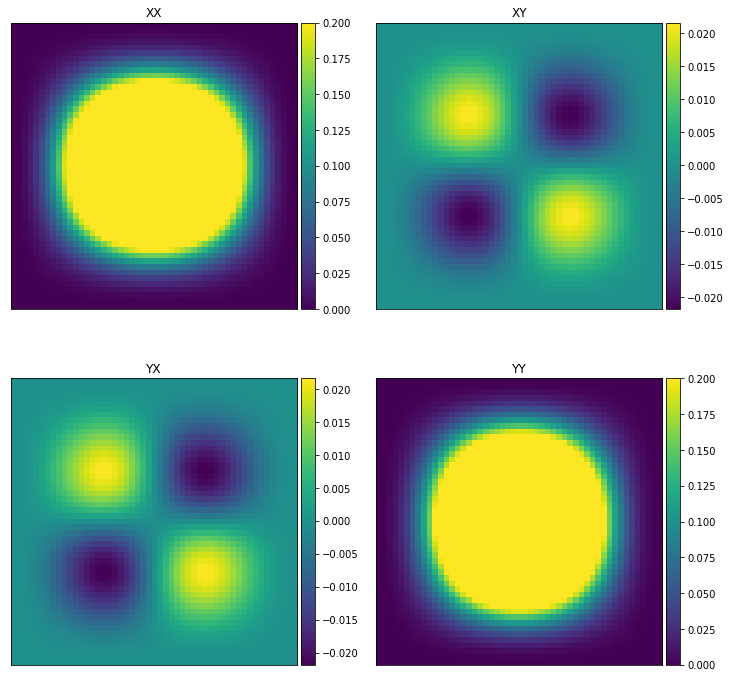

plots/jones_hyperbeam_rot_zenith_gains_nside51_t00_f100.040MHz.png


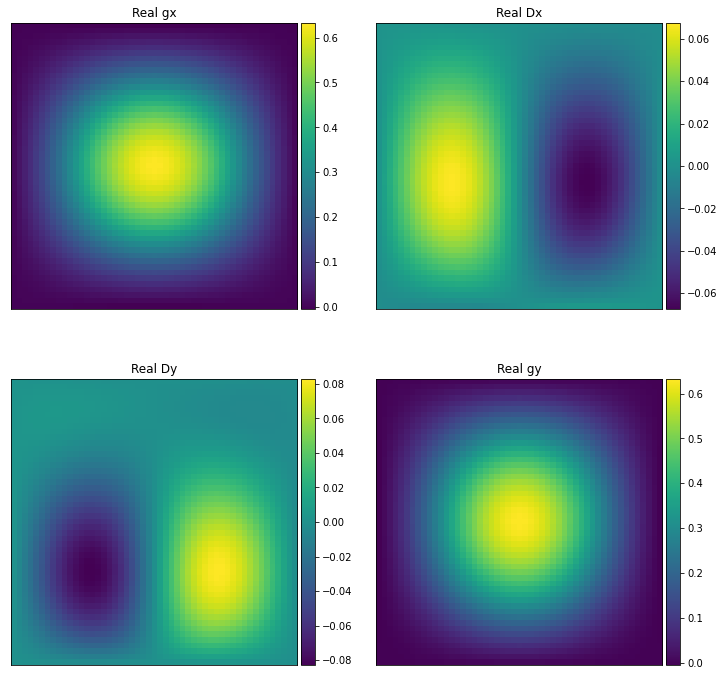

1.0000000928967272 1.0000000932234652
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t00_f100.040MHz.png


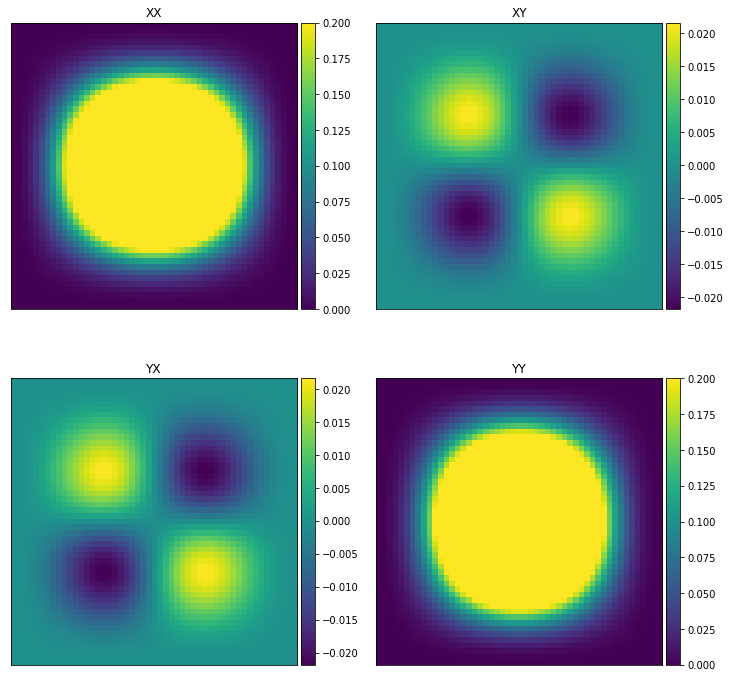

plots/jones_hyperbeam_rot_zenith_gains_nside51_t01_f99.600MHz.png


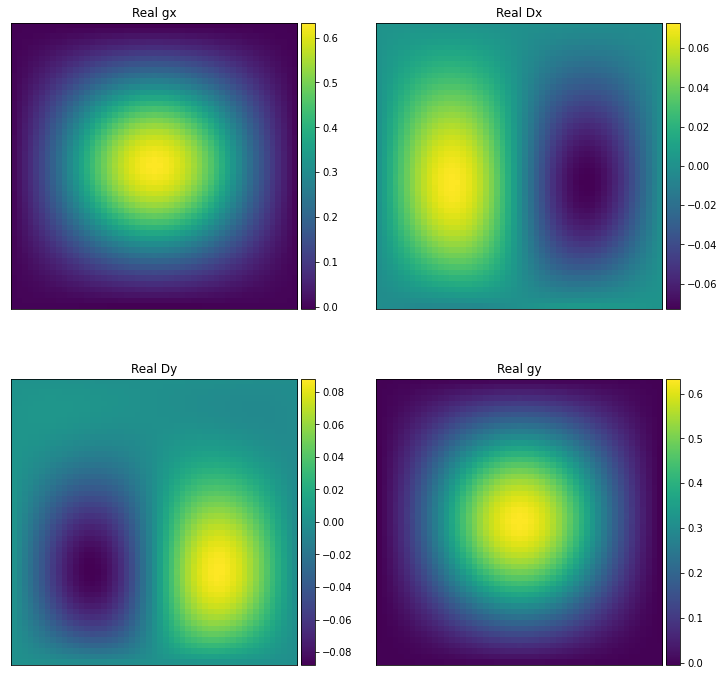

1.0000000928967272 1.0000000932234652
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t01_f99.600MHz.png


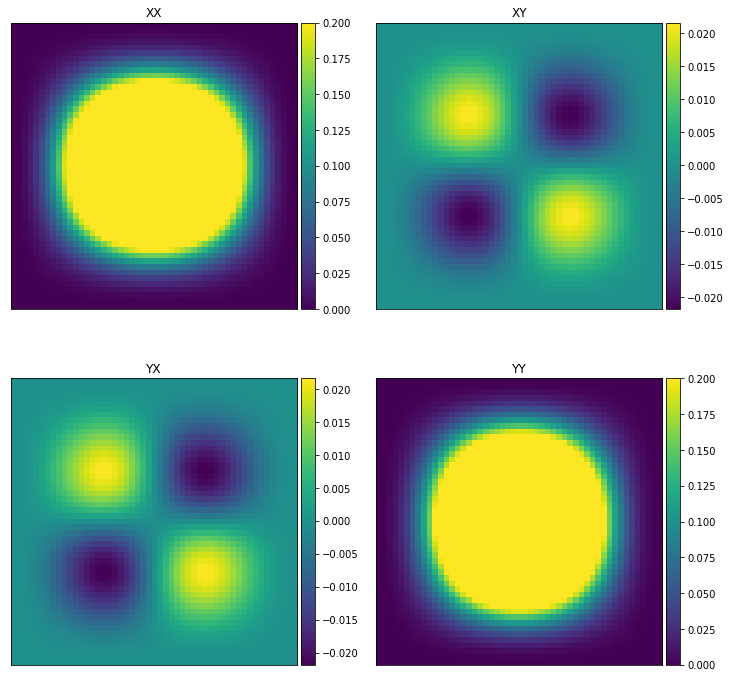

plots/jones_hyperbeam_rot_zenith_gains_nside51_t01_f100.000MHz.png


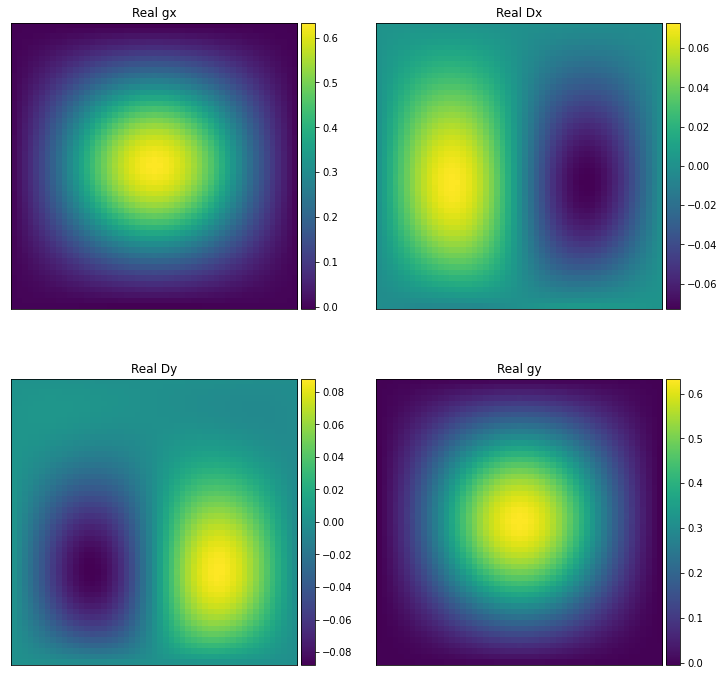

1.0000000928967272 1.0000000932234652
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t01_f100.000MHz.png


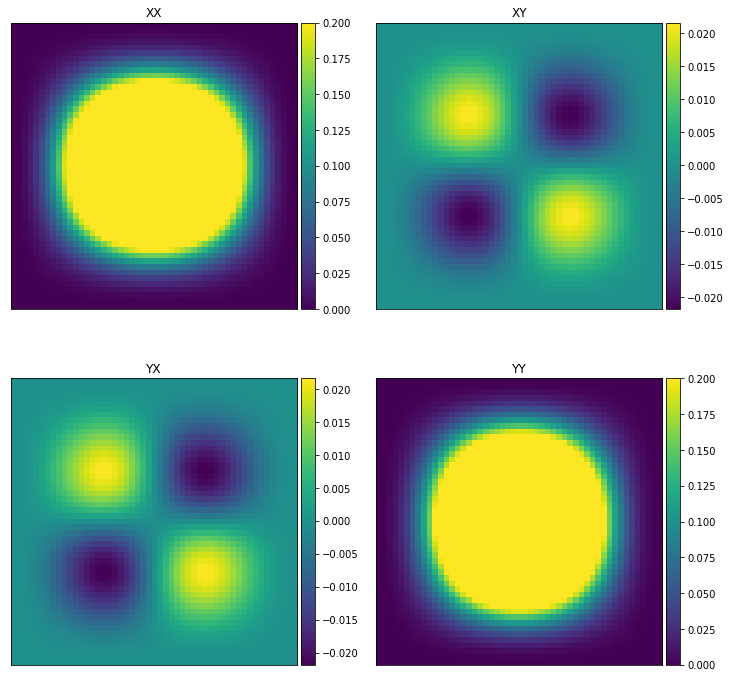

plots/jones_hyperbeam_rot_zenith_gains_nside51_t01_f100.040MHz.png


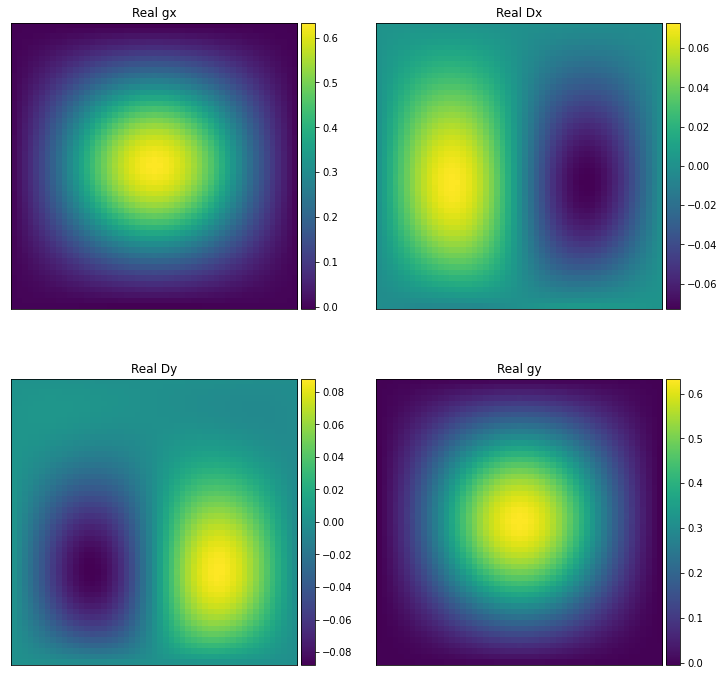

1.0000000928967272 1.0000000932234652
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t01_f100.040MHz.png


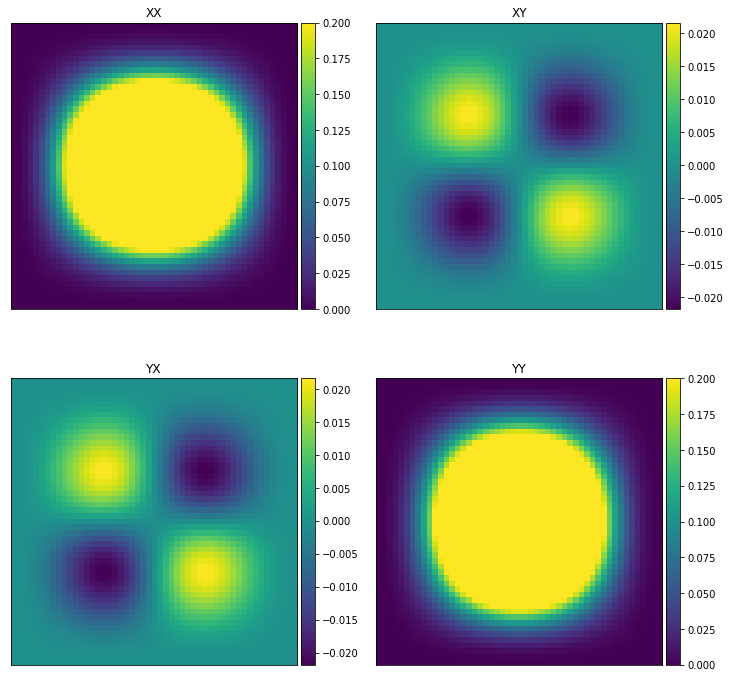

../../build/cmake_testing/primary_beam_cuda/hyperbeam_offzen1_100_rot_double.txt
plots/jones_hyperbeam_rot_offzen1_gains_nside51_t00_f99.600MHz.png


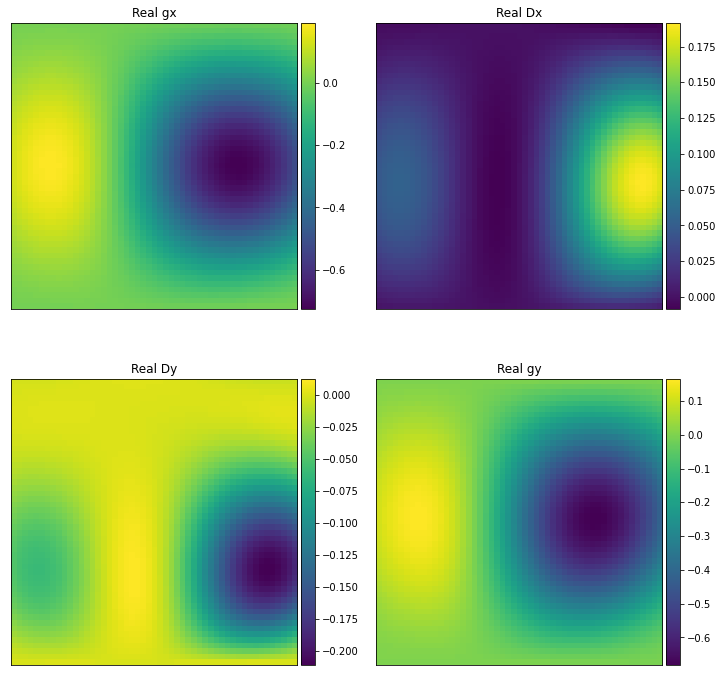

0.8221322772390022 0.7084348099812924
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t00_f99.600MHz.png


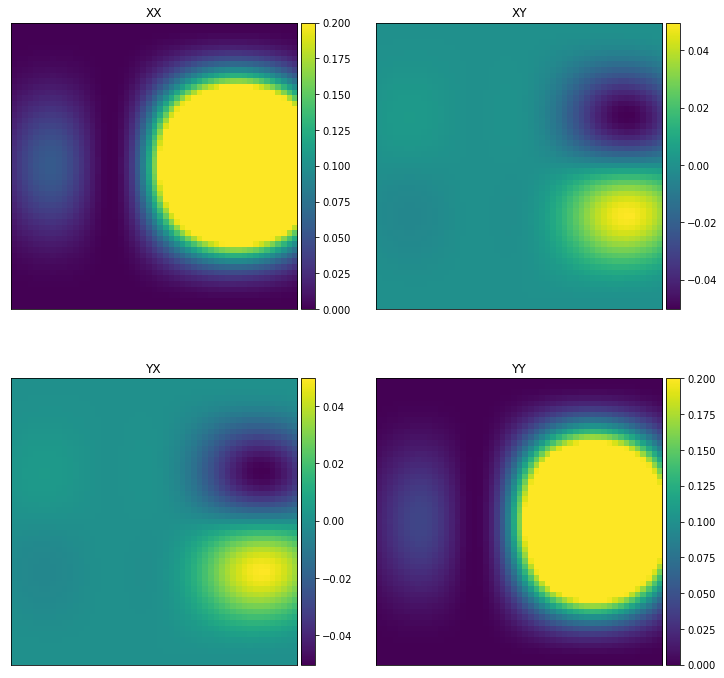

plots/jones_hyperbeam_rot_offzen1_gains_nside51_t00_f100.000MHz.png


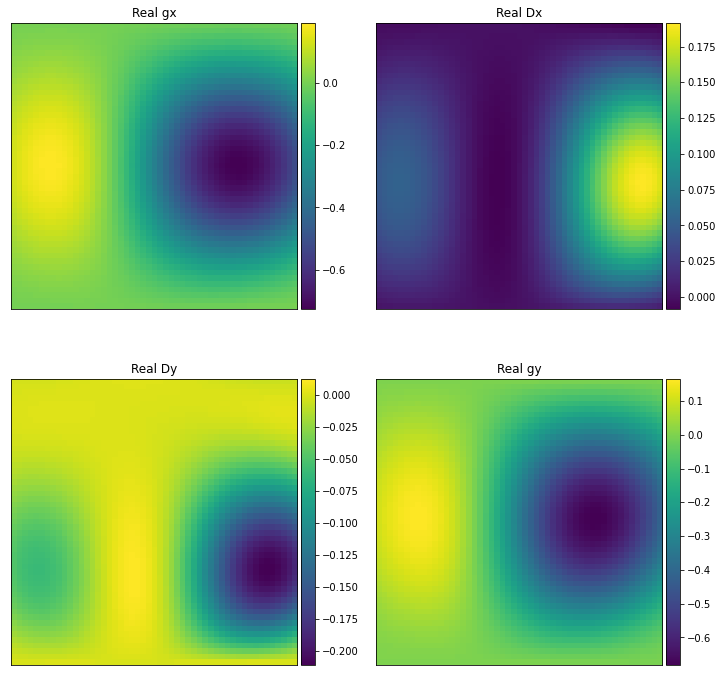

0.8221322772390022 0.7084348099812924
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t00_f100.000MHz.png


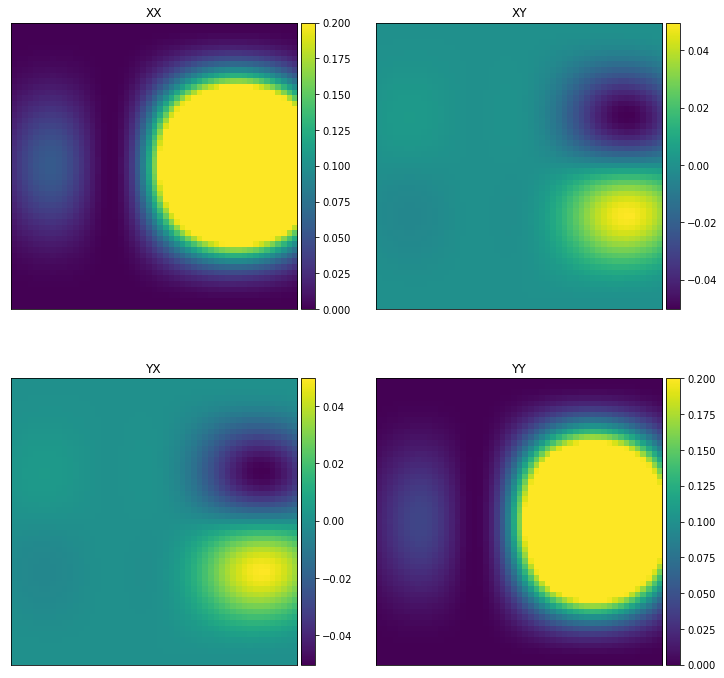

plots/jones_hyperbeam_rot_offzen1_gains_nside51_t00_f100.040MHz.png


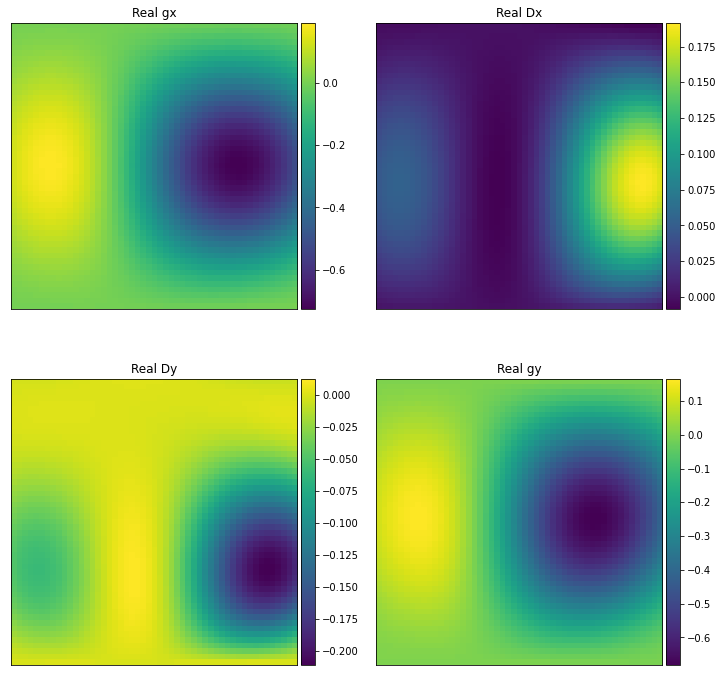

0.8221322772390022 0.7084348099812924
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t00_f100.040MHz.png


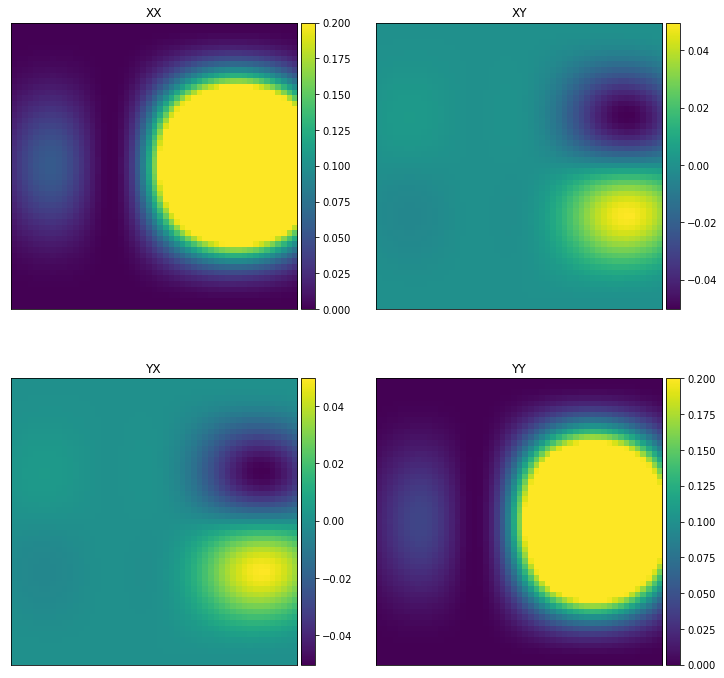

plots/jones_hyperbeam_rot_offzen1_gains_nside51_t01_f99.600MHz.png


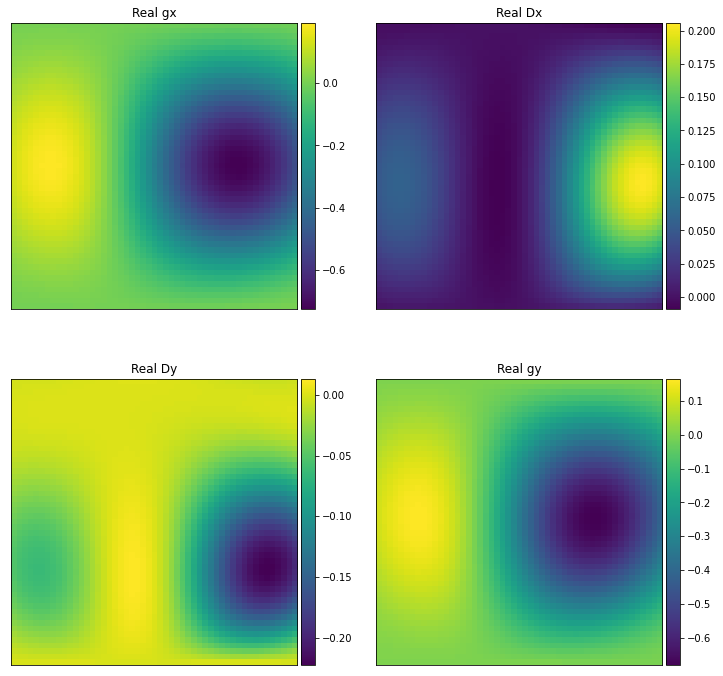

0.8221322772405056 0.7084348099816462
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t01_f99.600MHz.png


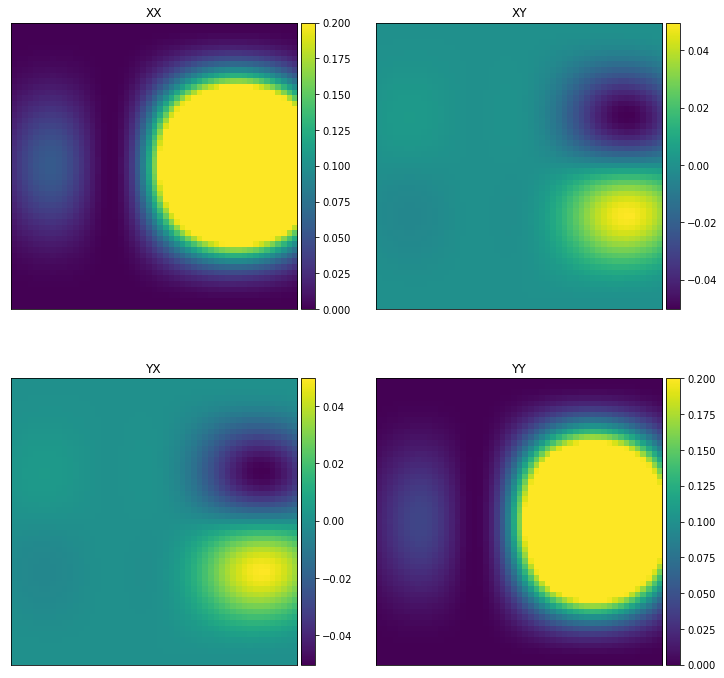

plots/jones_hyperbeam_rot_offzen1_gains_nside51_t01_f100.000MHz.png


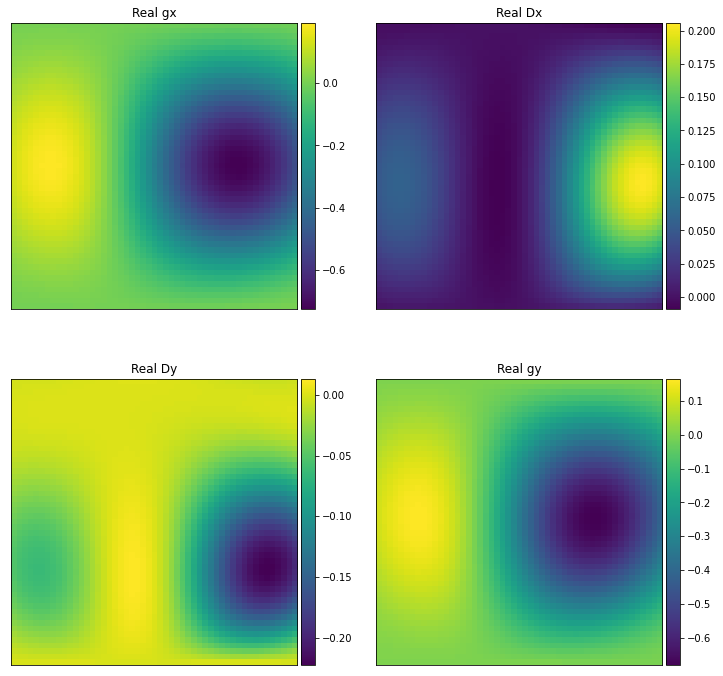

0.8221322772405056 0.7084348099816462
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t01_f100.000MHz.png


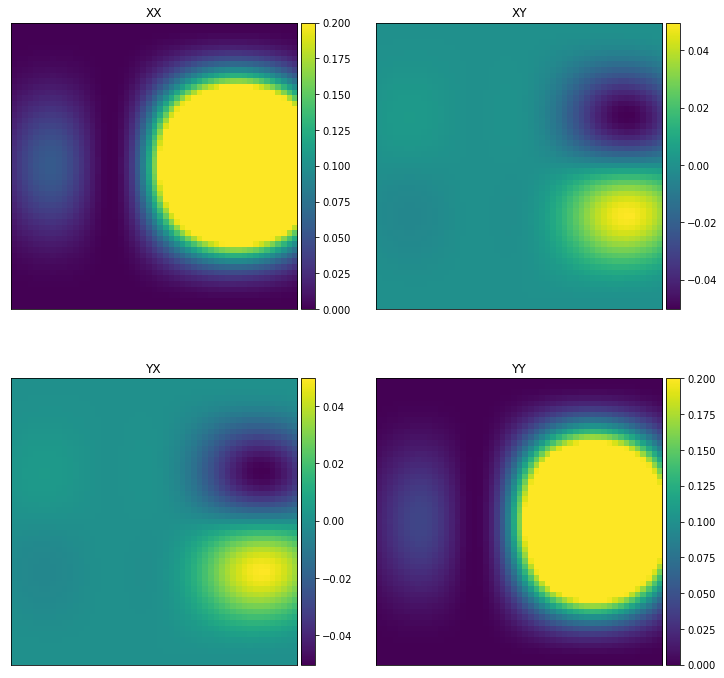

plots/jones_hyperbeam_rot_offzen1_gains_nside51_t01_f100.040MHz.png


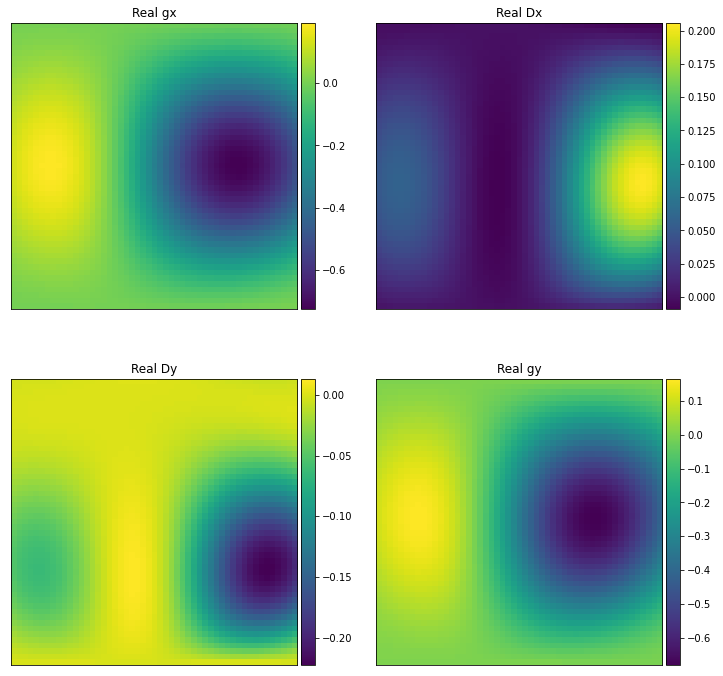

0.8221322772405056 0.7084348099816462
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t01_f100.040MHz.png


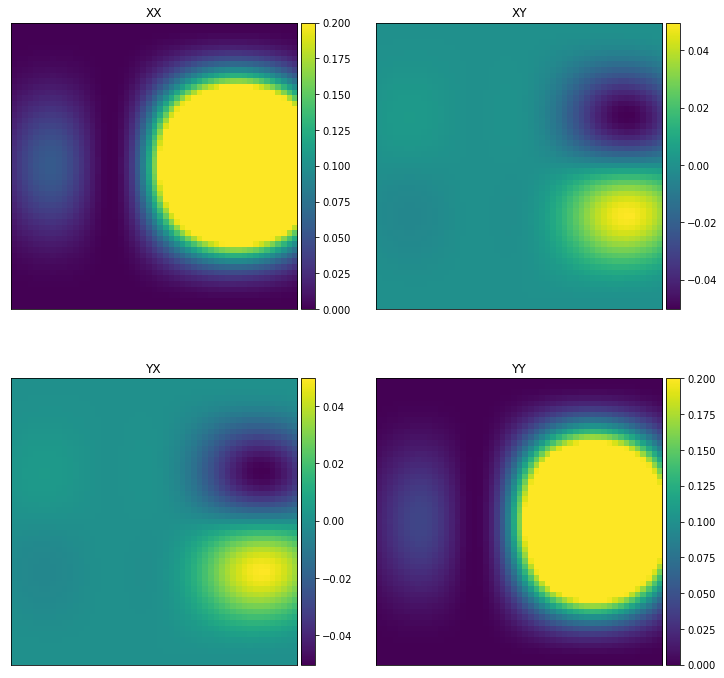

../../build/cmake_testing/primary_beam_cuda/hyperbeam_offzen2_100_rot_double.txt
plots/jones_hyperbeam_rot_offzen2_gains_nside51_t00_f99.600MHz.png


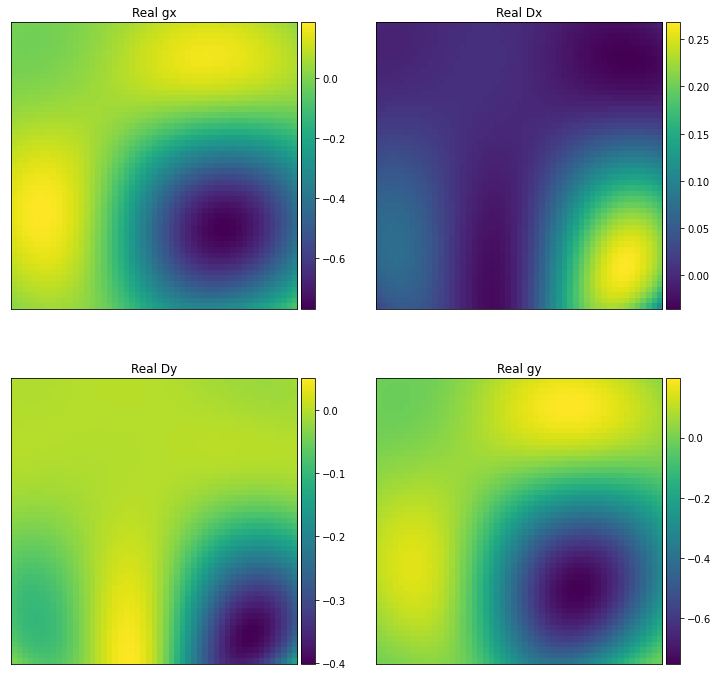

0.6276706138971413 0.6275830454903754
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t00_f99.600MHz.png


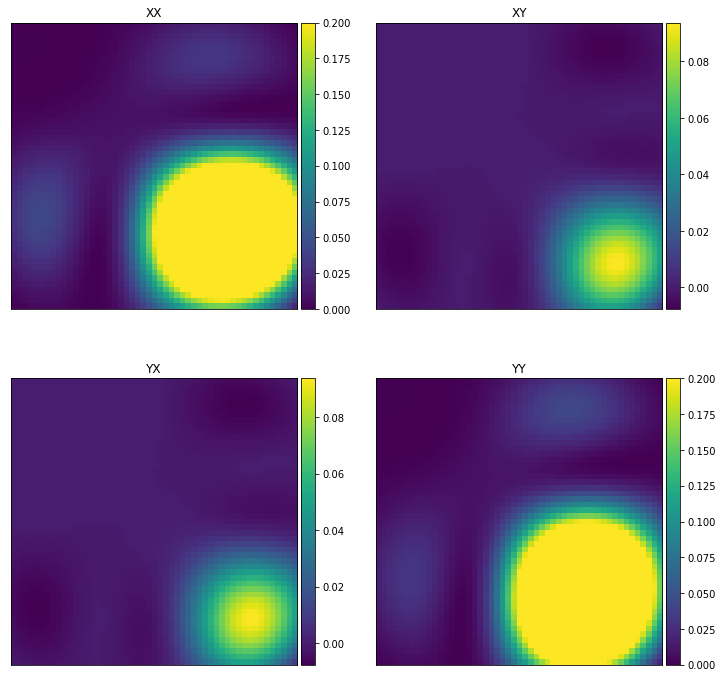

plots/jones_hyperbeam_rot_offzen2_gains_nside51_t00_f100.000MHz.png


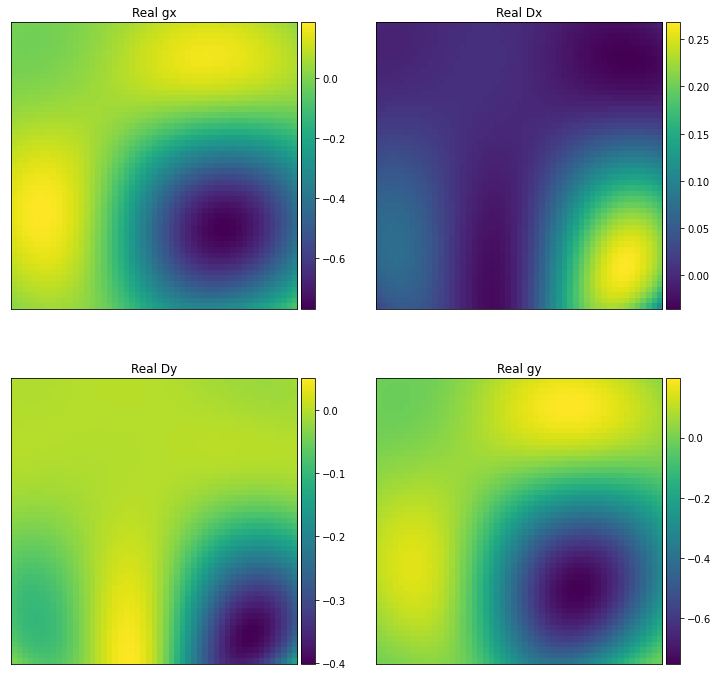

0.6276706138971413 0.6275830454903754
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t00_f100.000MHz.png


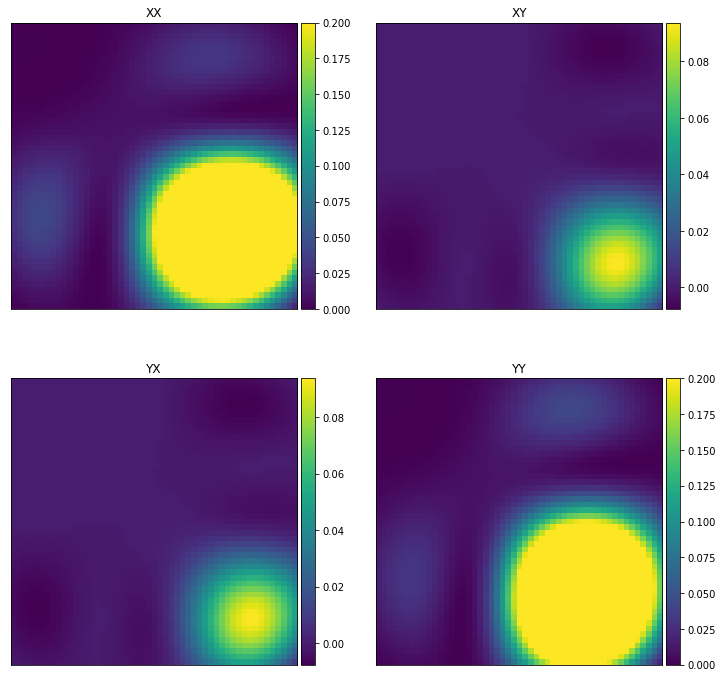

plots/jones_hyperbeam_rot_offzen2_gains_nside51_t00_f100.040MHz.png


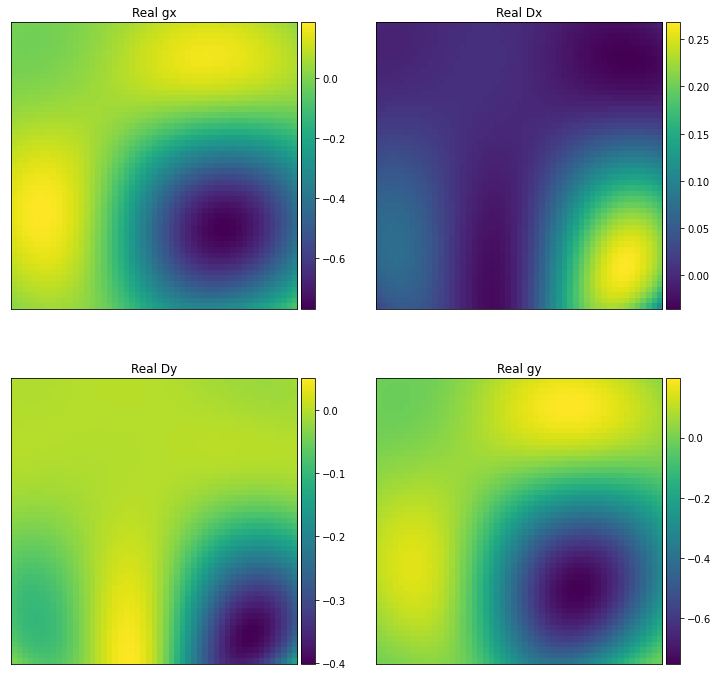

0.6276706138971413 0.6275830454903754
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t00_f100.040MHz.png


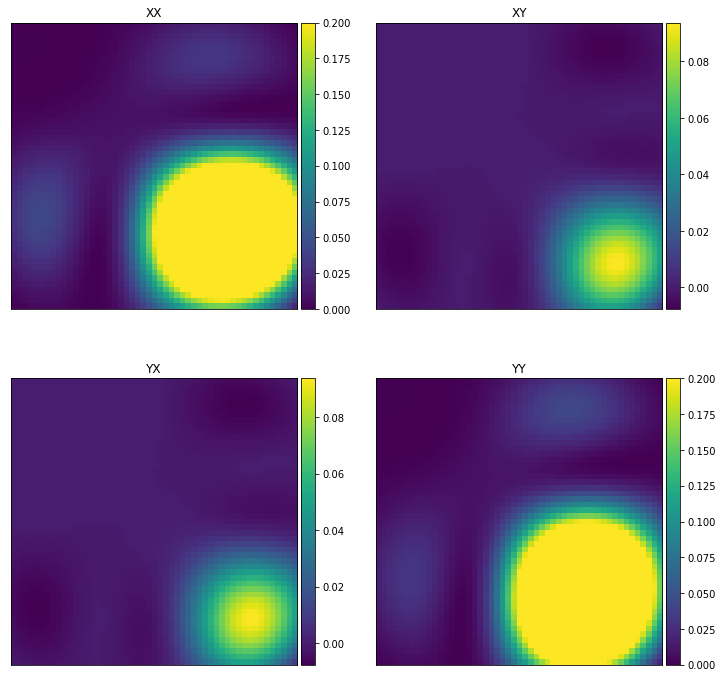

plots/jones_hyperbeam_rot_offzen2_gains_nside51_t01_f99.600MHz.png


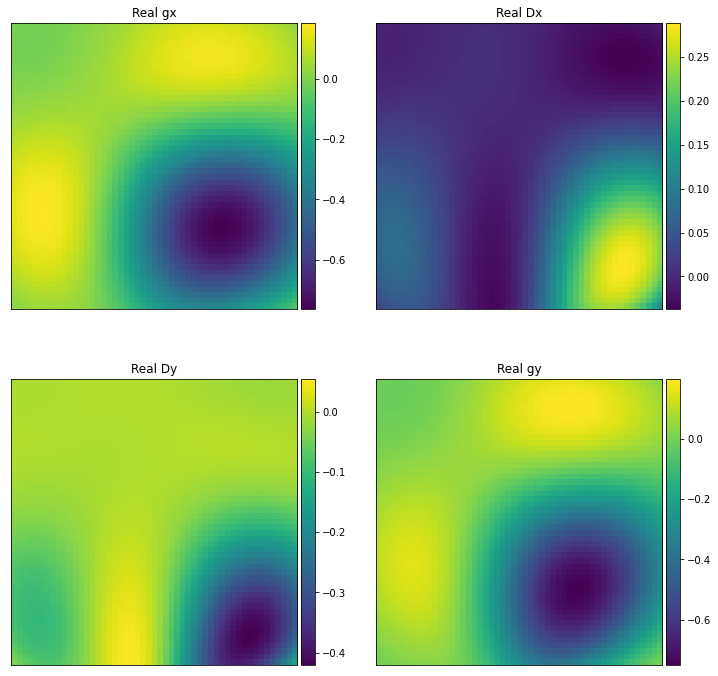

0.6276706138975601 0.6275830454905722
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t01_f99.600MHz.png


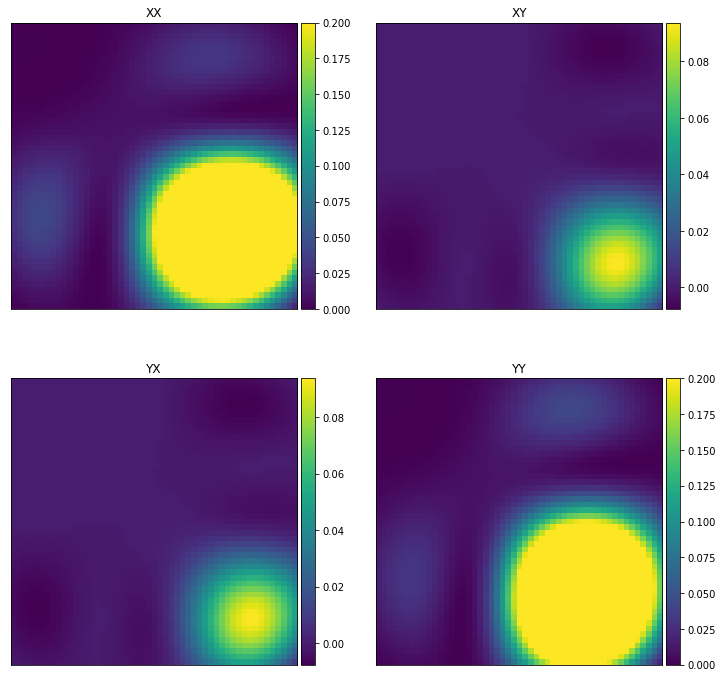

plots/jones_hyperbeam_rot_offzen2_gains_nside51_t01_f100.000MHz.png


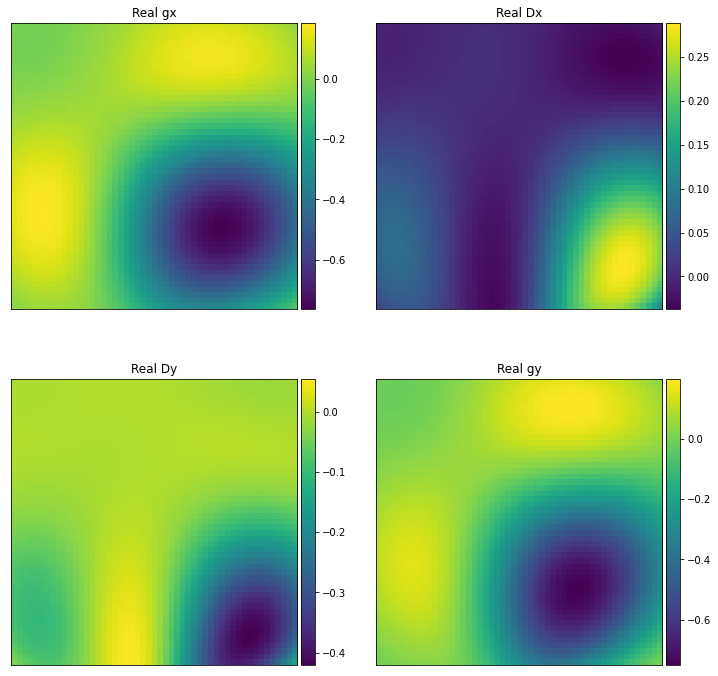

0.6276706138975601 0.6275830454905722
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t01_f100.000MHz.png


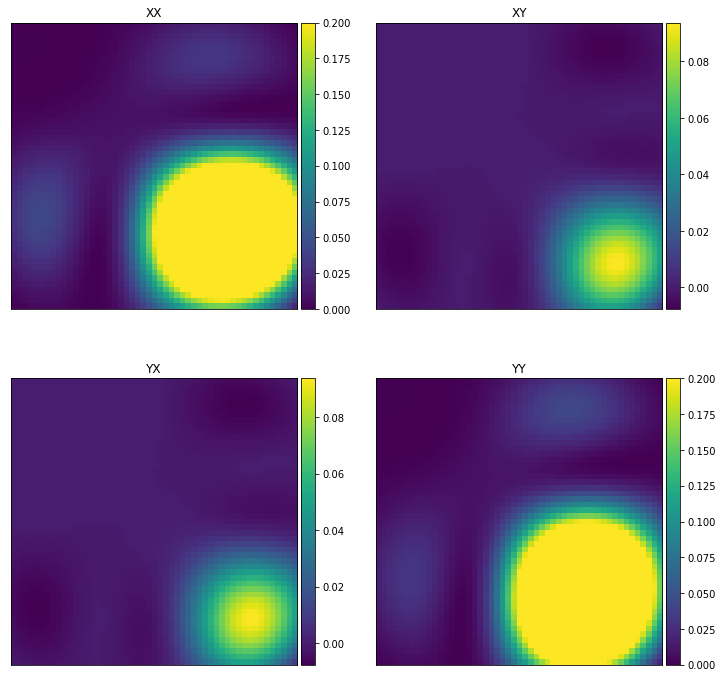

plots/jones_hyperbeam_rot_offzen2_gains_nside51_t01_f100.040MHz.png


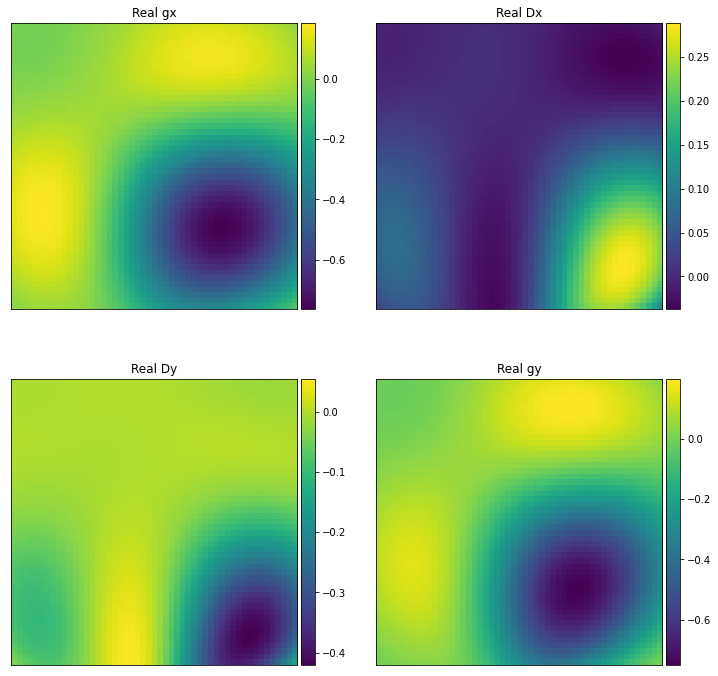

0.6276706138975601 0.6275830454905722
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t01_f100.040MHz.png


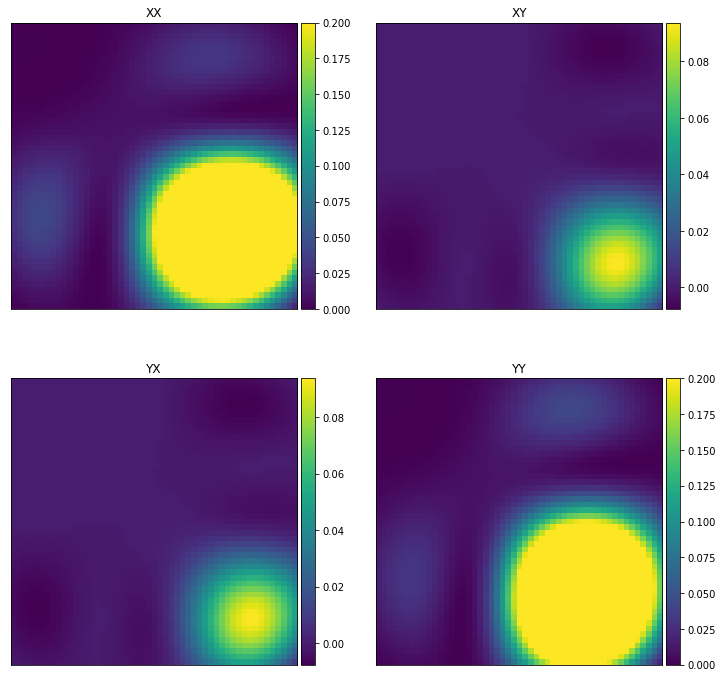

../../build/cmake_testing/primary_beam_cuda/hyperbeam_zenith_150_rot_double.txt
plots/jones_hyperbeam_rot_zenith_gains_nside51_t00_f149.600MHz.png


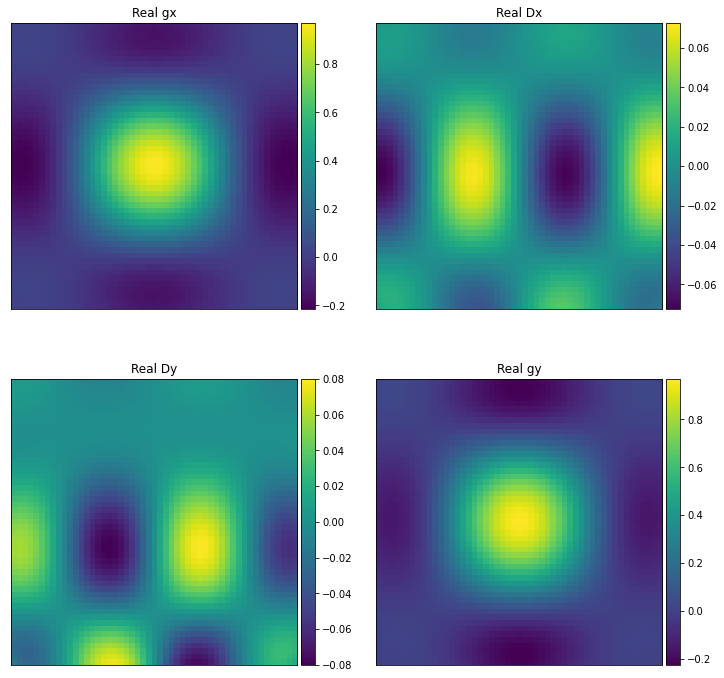

1.0000000780836018 1.0000000747627442
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t00_f149.600MHz.png


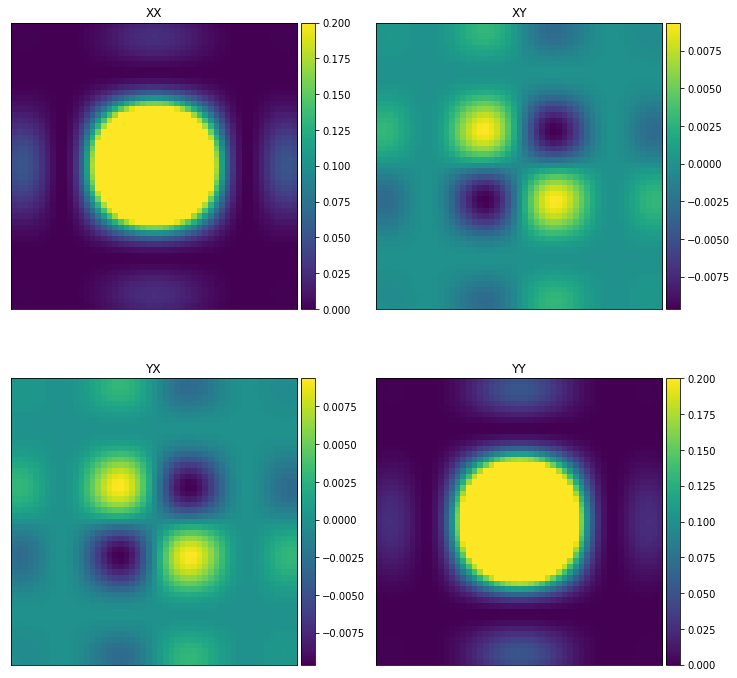

plots/jones_hyperbeam_rot_zenith_gains_nside51_t00_f150.000MHz.png


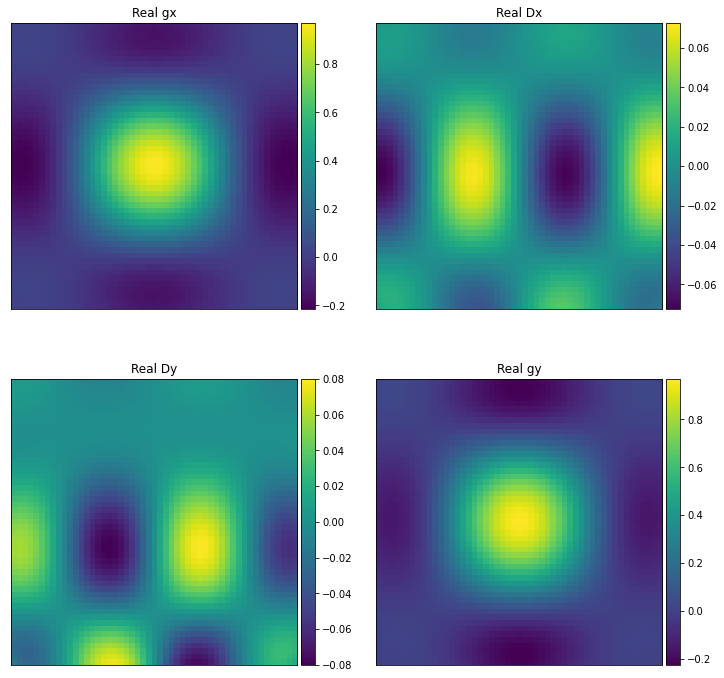

1.0000000780836018 1.0000000747627442
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t00_f150.000MHz.png


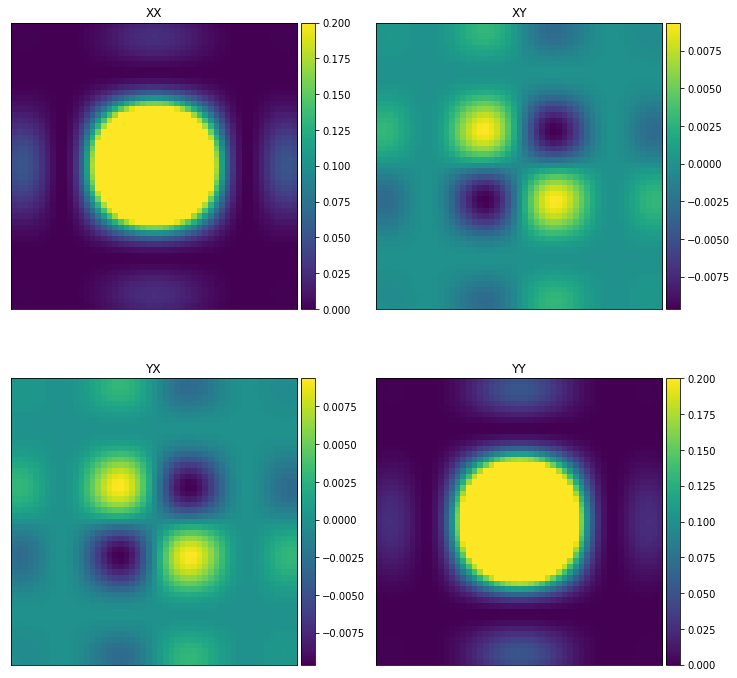

plots/jones_hyperbeam_rot_zenith_gains_nside51_t00_f150.040MHz.png


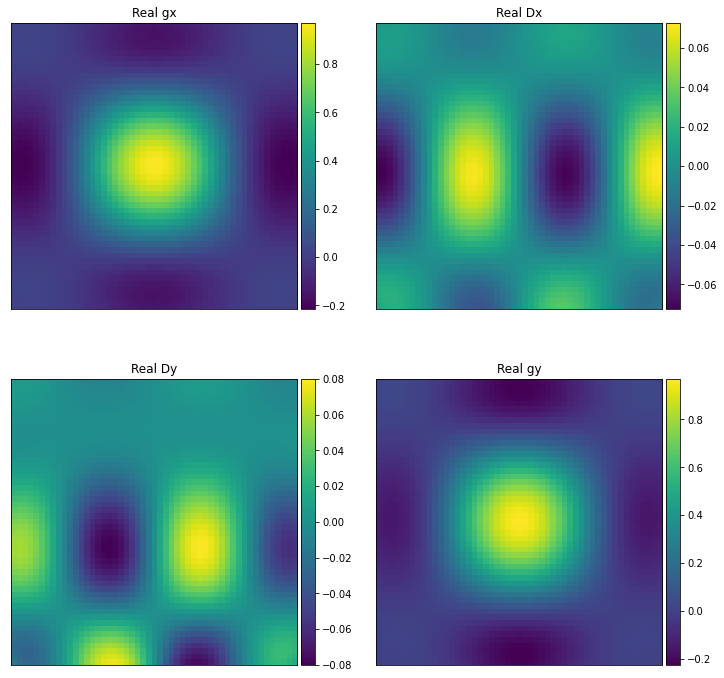

1.0000000780836018 1.0000000747627442
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t00_f150.040MHz.png


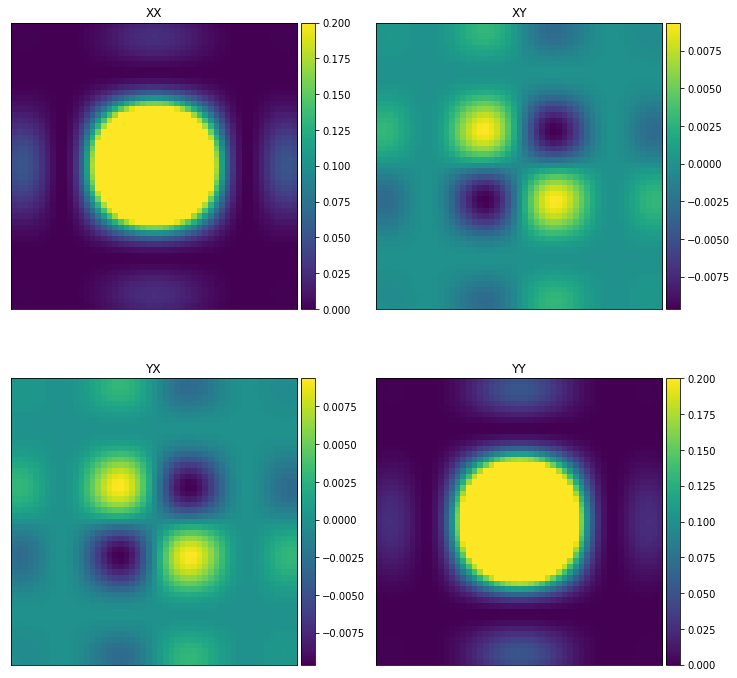

plots/jones_hyperbeam_rot_zenith_gains_nside51_t01_f149.600MHz.png


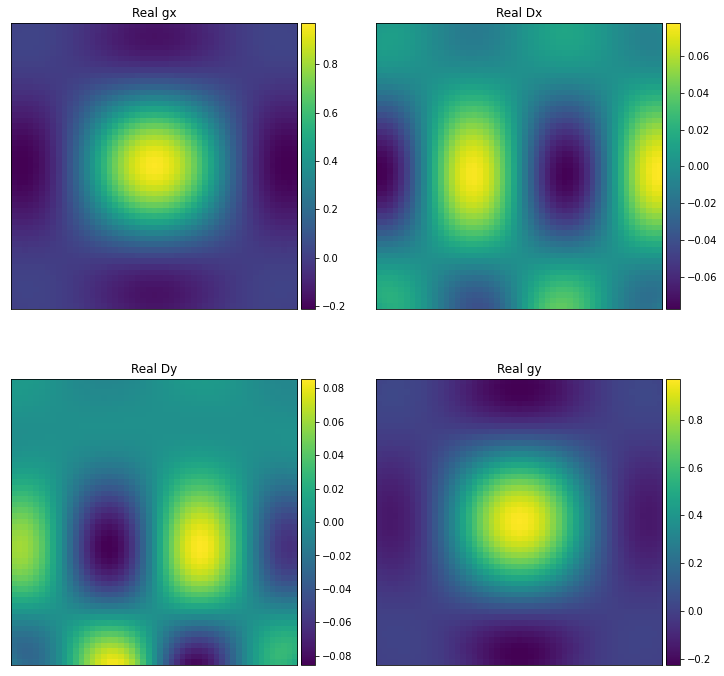

1.0000000780836018 1.0000000747627442
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t01_f149.600MHz.png


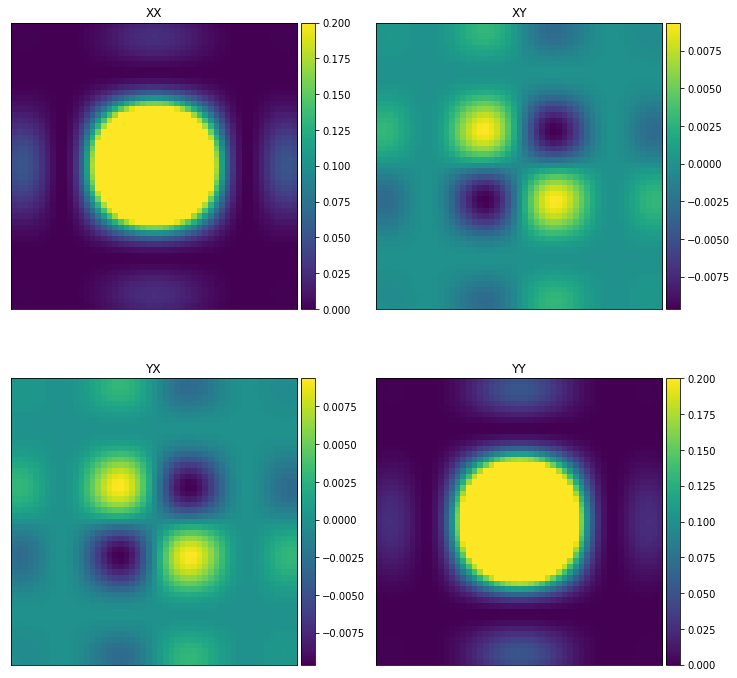

plots/jones_hyperbeam_rot_zenith_gains_nside51_t01_f150.000MHz.png


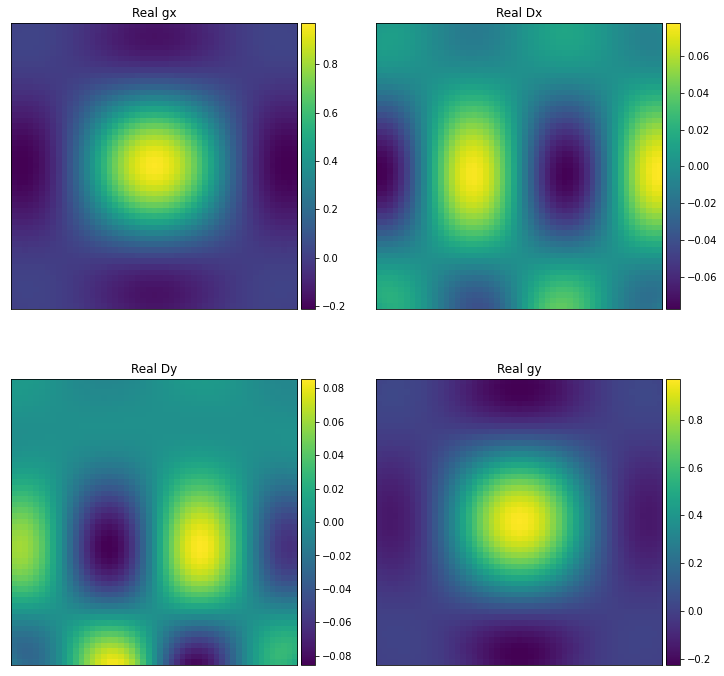

1.0000000780836018 1.0000000747627442
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t01_f150.000MHz.png


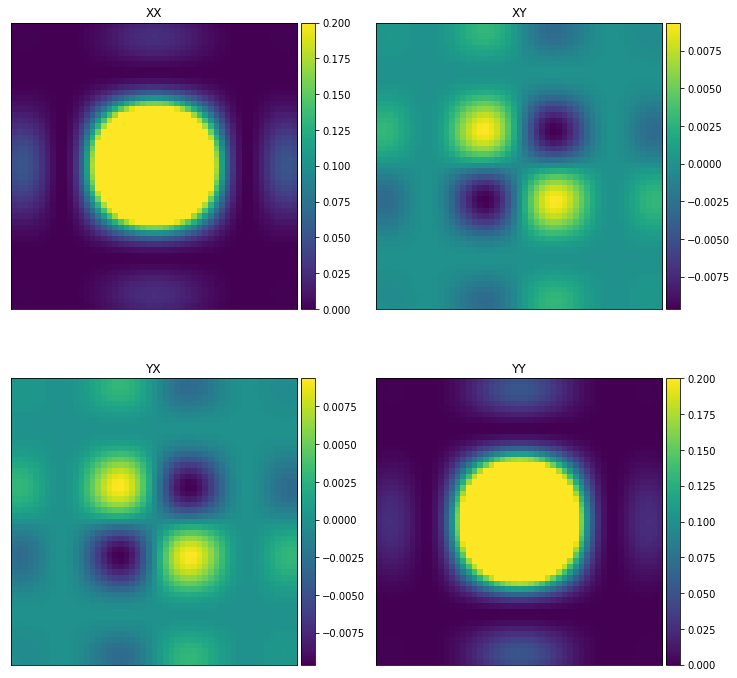

plots/jones_hyperbeam_rot_zenith_gains_nside51_t01_f150.040MHz.png


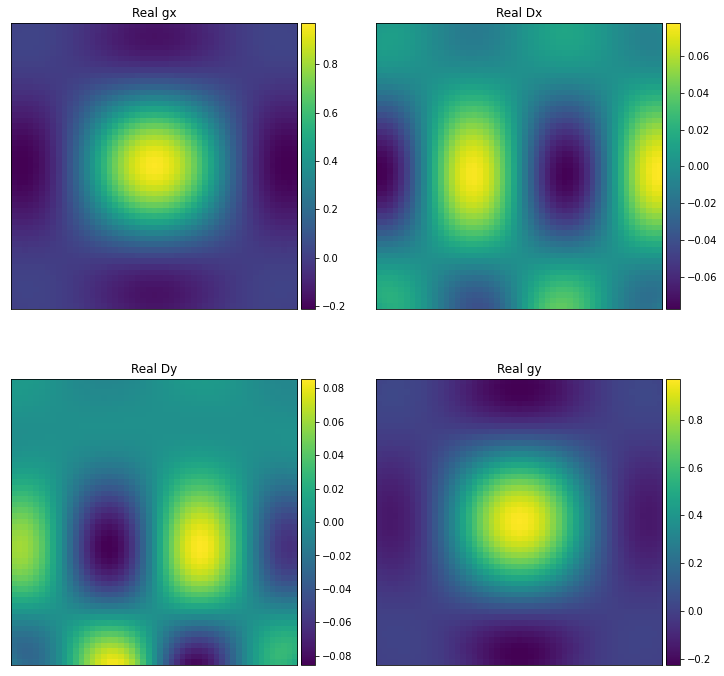

1.0000000780836018 1.0000000747627442
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t01_f150.040MHz.png


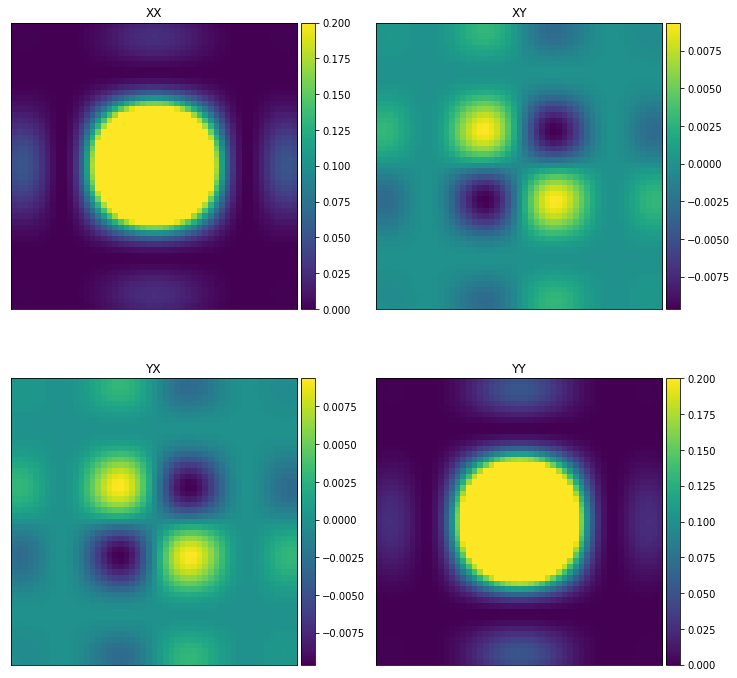

../../build/cmake_testing/primary_beam_cuda/hyperbeam_offzen1_150_rot_double.txt
plots/jones_hyperbeam_rot_offzen1_gains_nside51_t00_f149.600MHz.png


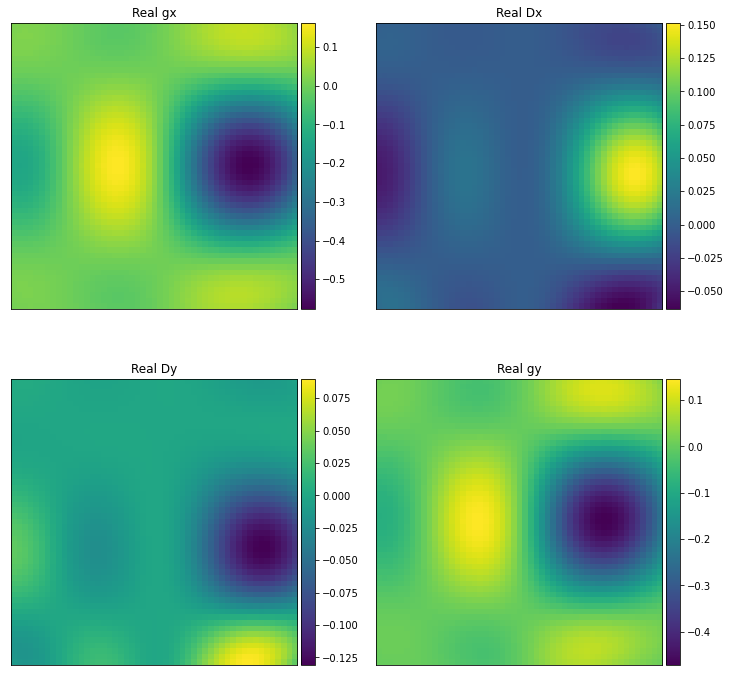

0.9134195587350207 0.6945135368520573
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t00_f149.600MHz.png


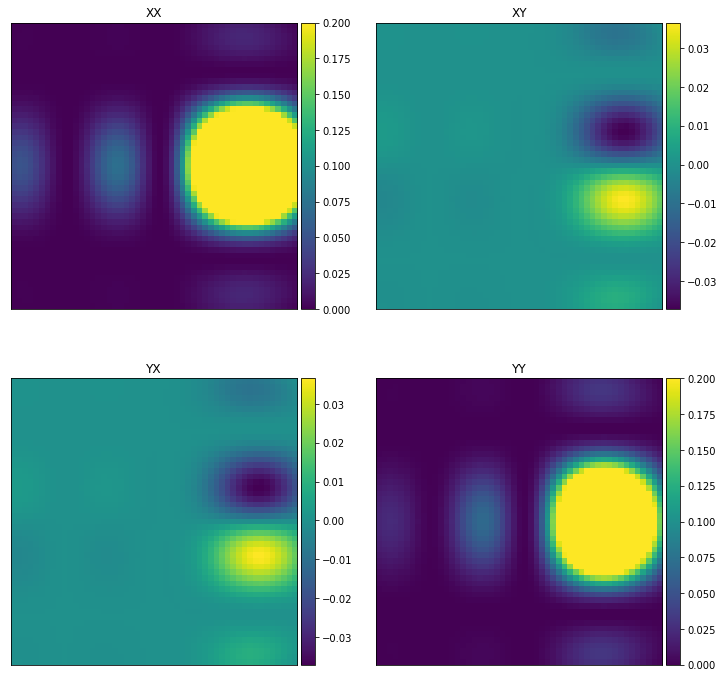

plots/jones_hyperbeam_rot_offzen1_gains_nside51_t00_f150.000MHz.png


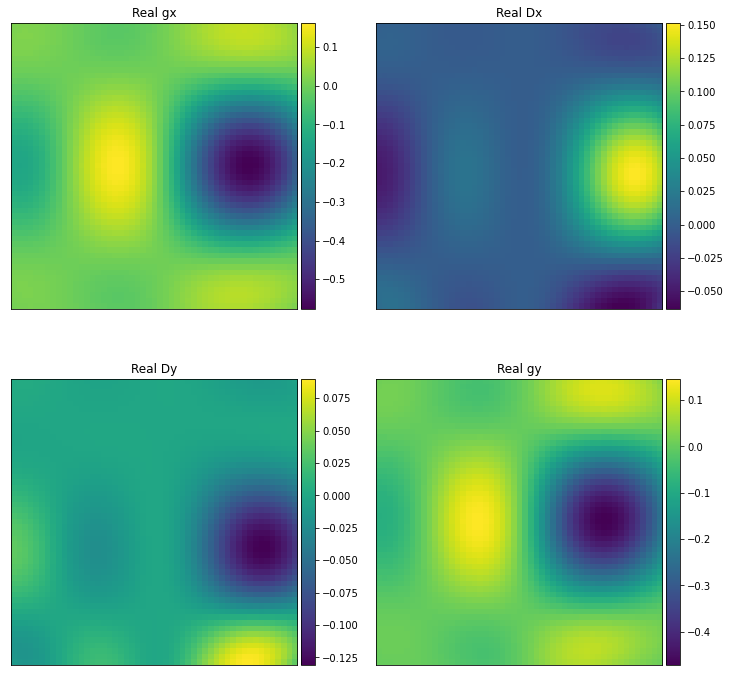

0.9134195587350207 0.6945135368520573
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t00_f150.000MHz.png


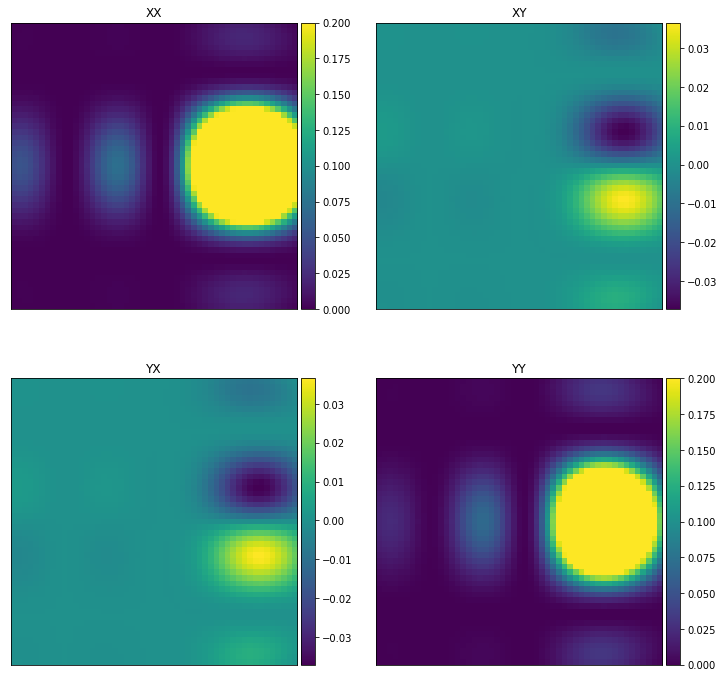

plots/jones_hyperbeam_rot_offzen1_gains_nside51_t00_f150.040MHz.png


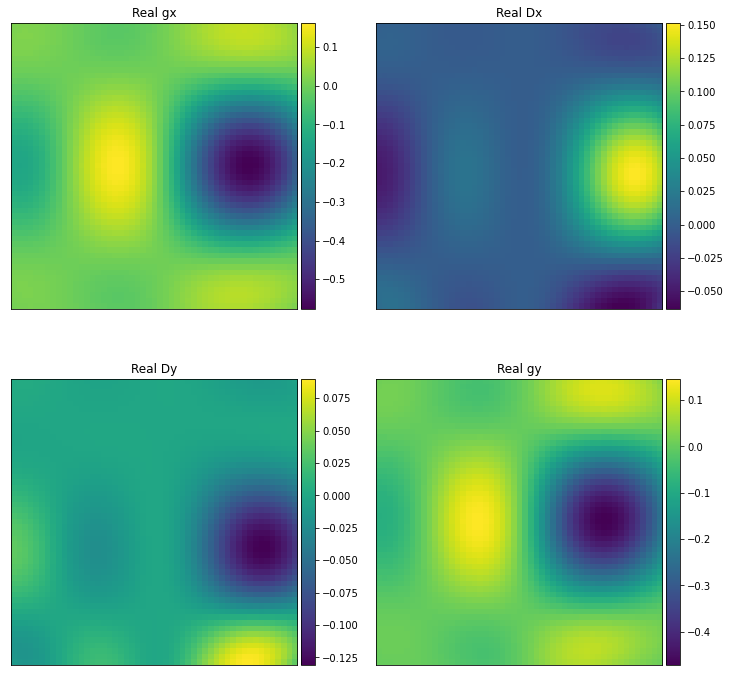

0.9134195587350207 0.6945135368520573
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t00_f150.040MHz.png


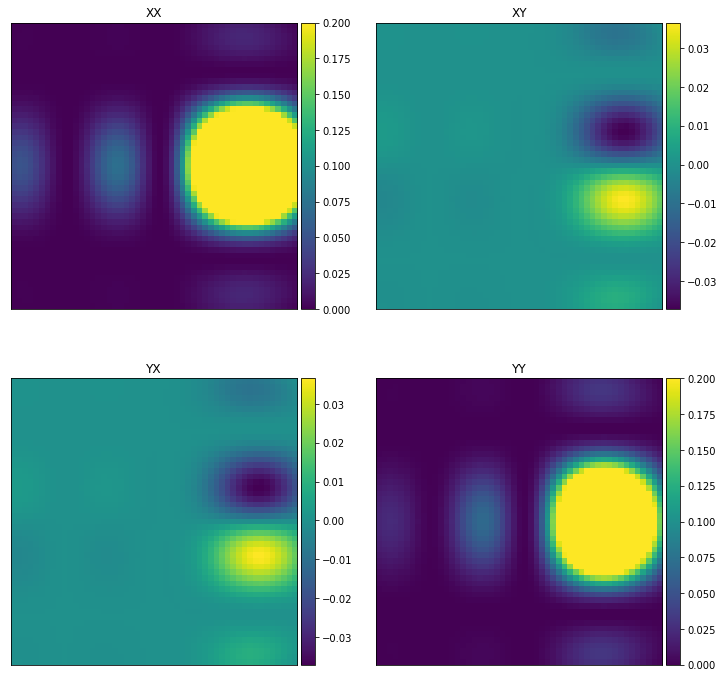

plots/jones_hyperbeam_rot_offzen1_gains_nside51_t01_f149.600MHz.png


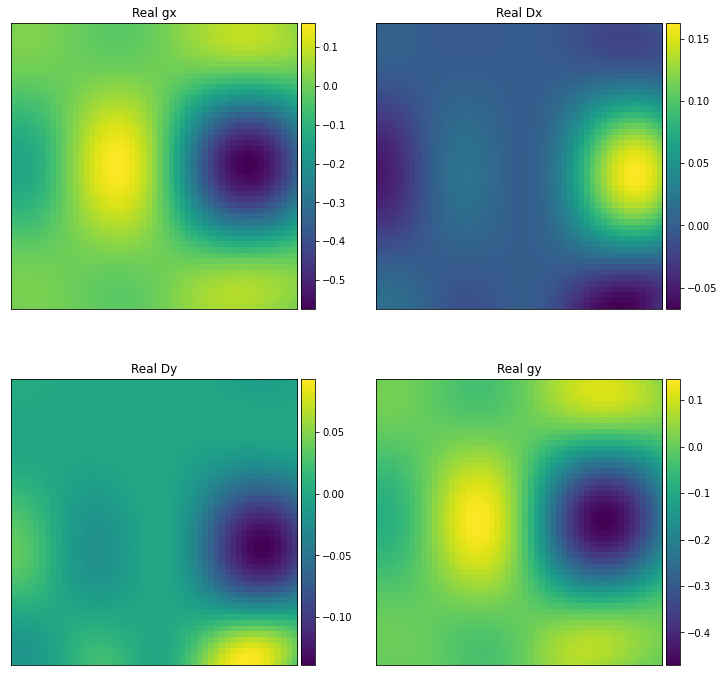

0.913419558735224 0.6945135368517971
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t01_f149.600MHz.png


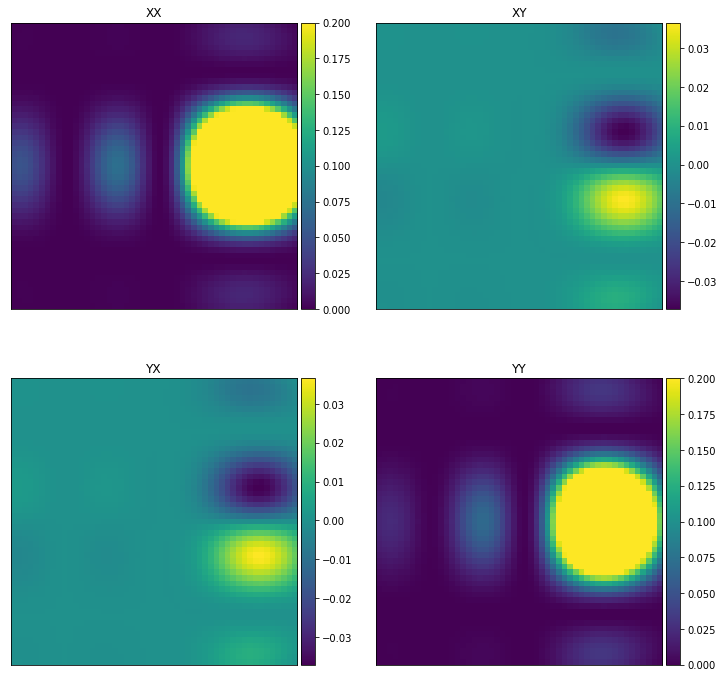

plots/jones_hyperbeam_rot_offzen1_gains_nside51_t01_f150.000MHz.png


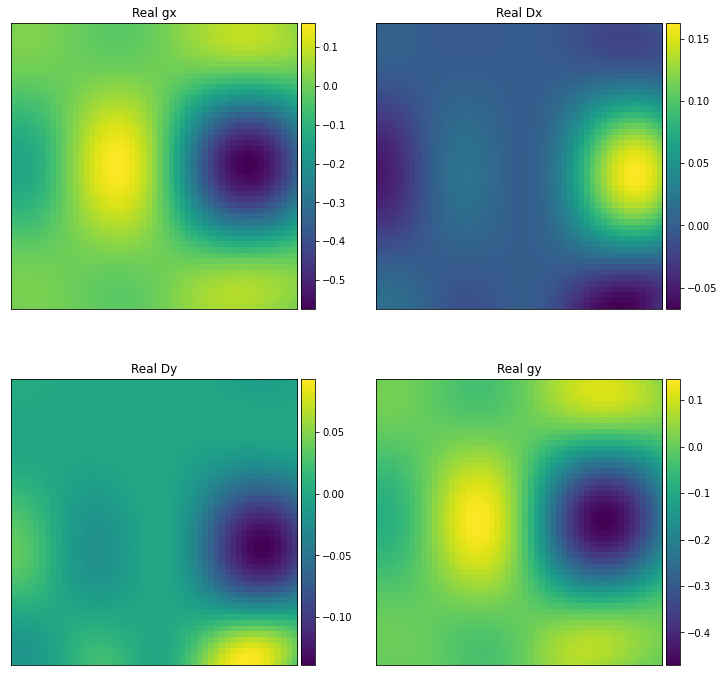

0.913419558735224 0.6945135368517971
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t01_f150.000MHz.png


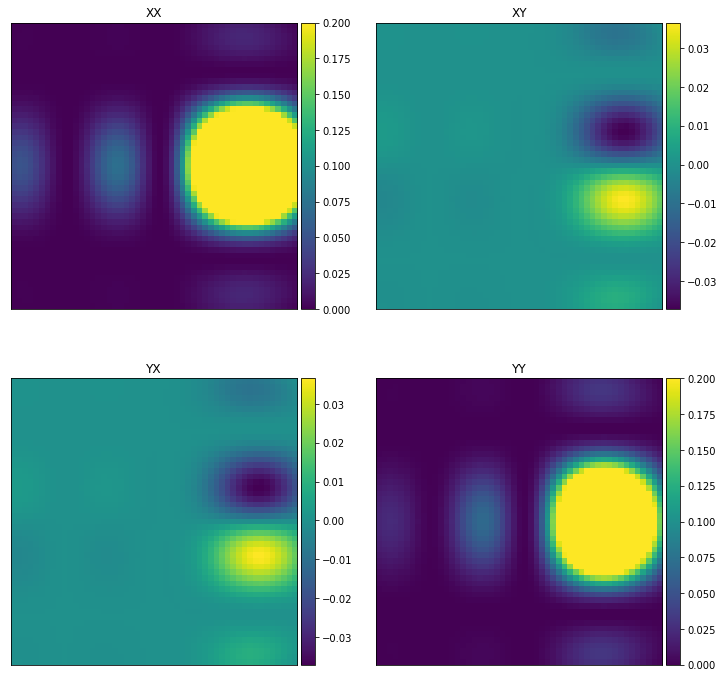

plots/jones_hyperbeam_rot_offzen1_gains_nside51_t01_f150.040MHz.png


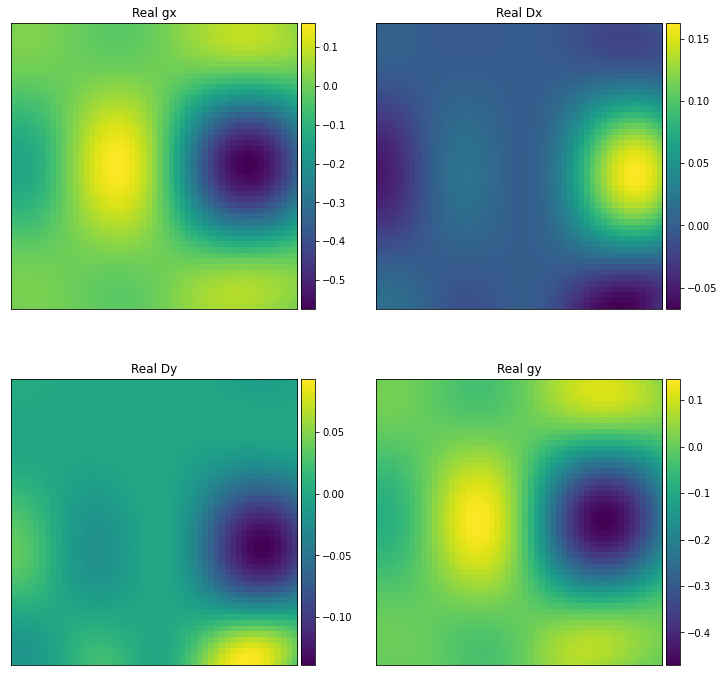

0.913419558735224 0.6945135368517971
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t01_f150.040MHz.png


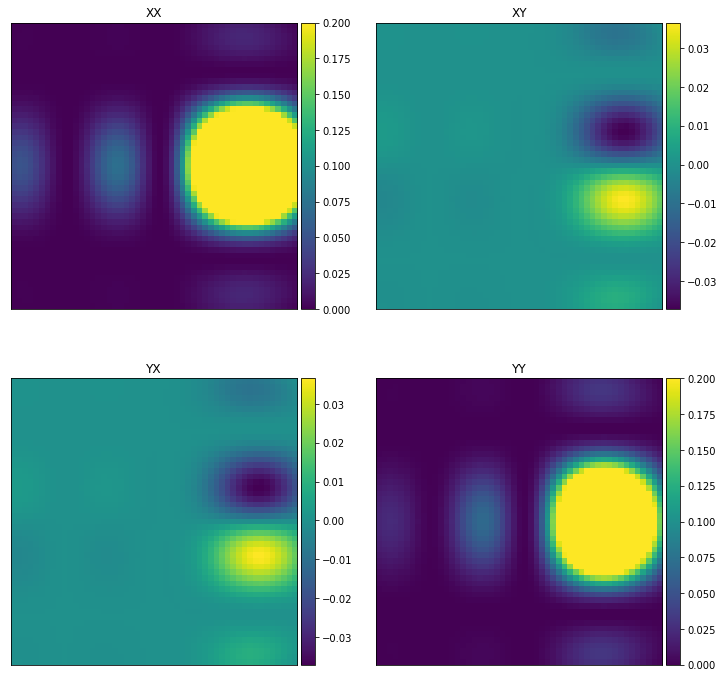

../../build/cmake_testing/primary_beam_cuda/hyperbeam_offzen2_150_rot_double.txt
plots/jones_hyperbeam_rot_offzen2_gains_nside51_t00_f149.600MHz.png


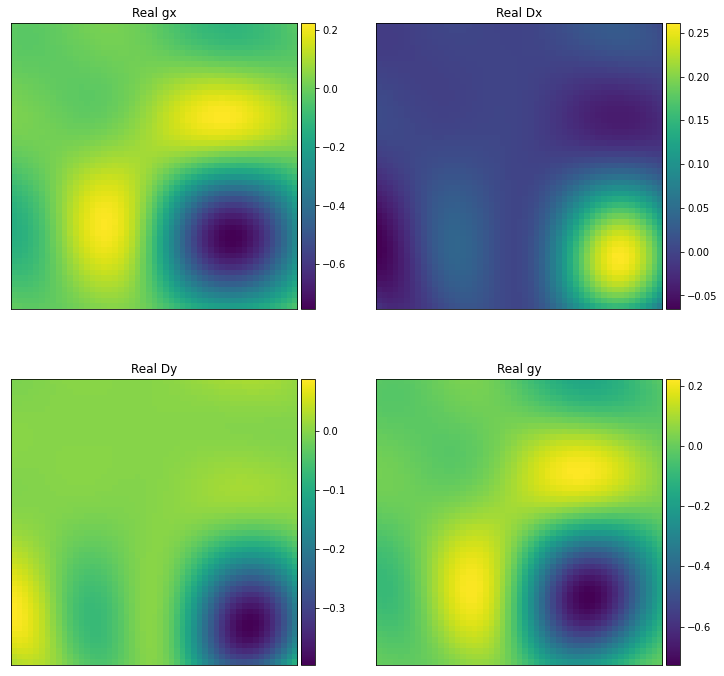

0.6224570007681884 0.6222096328244254
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t00_f149.600MHz.png


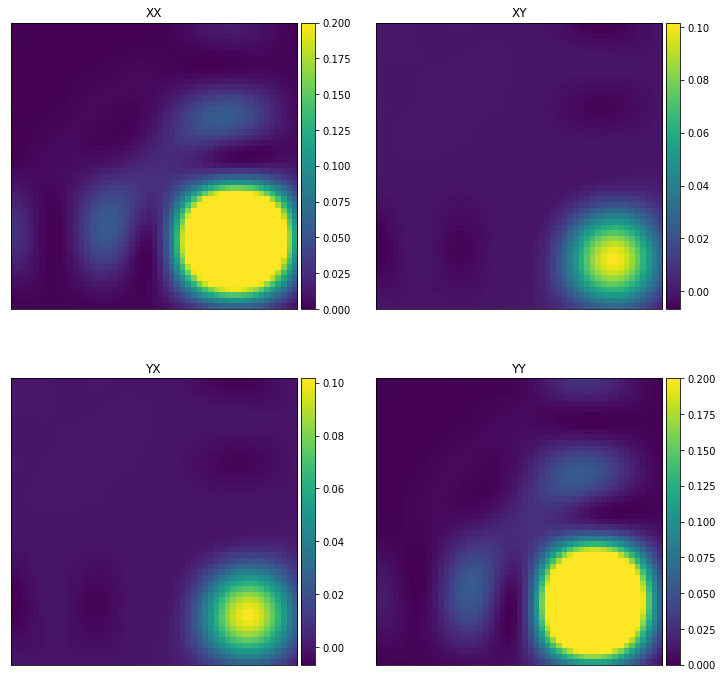

plots/jones_hyperbeam_rot_offzen2_gains_nside51_t00_f150.000MHz.png


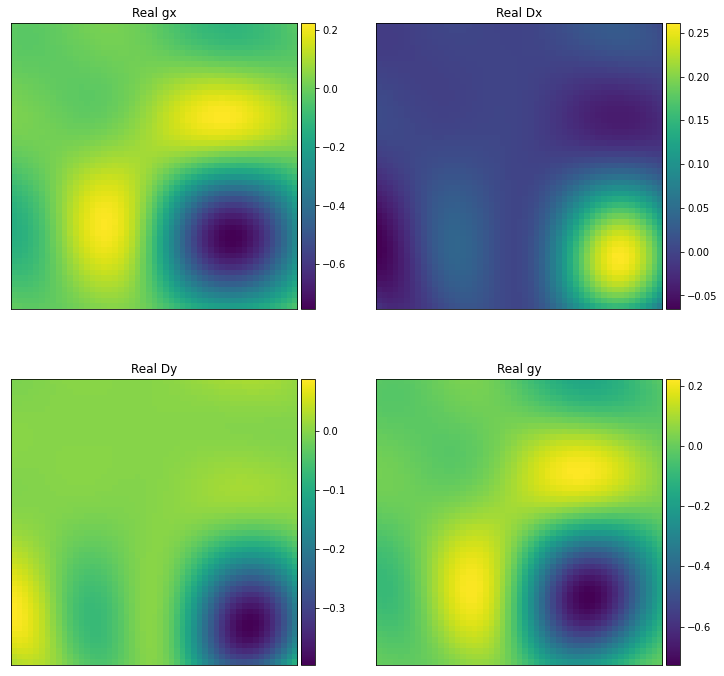

0.6224570007681884 0.6222096328244254
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t00_f150.000MHz.png


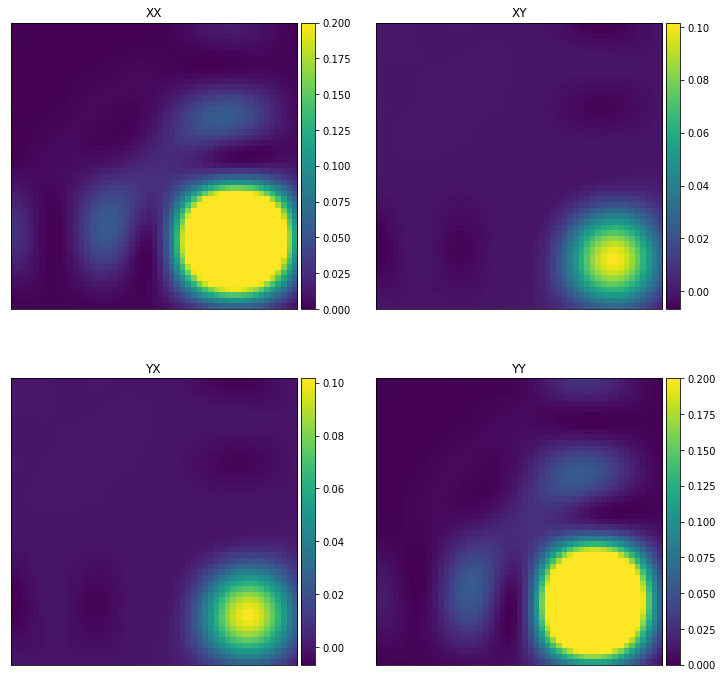

plots/jones_hyperbeam_rot_offzen2_gains_nside51_t00_f150.040MHz.png


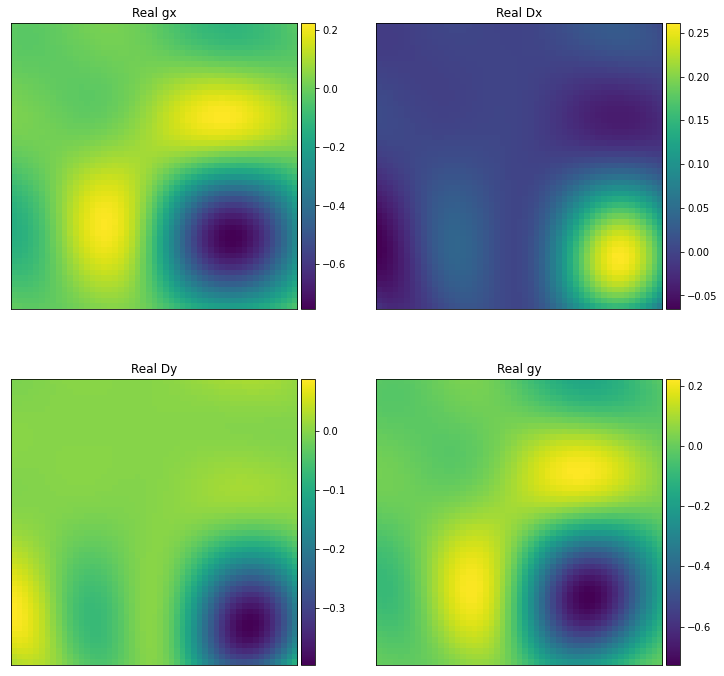

0.6224570007681884 0.6222096328244254
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t00_f150.040MHz.png


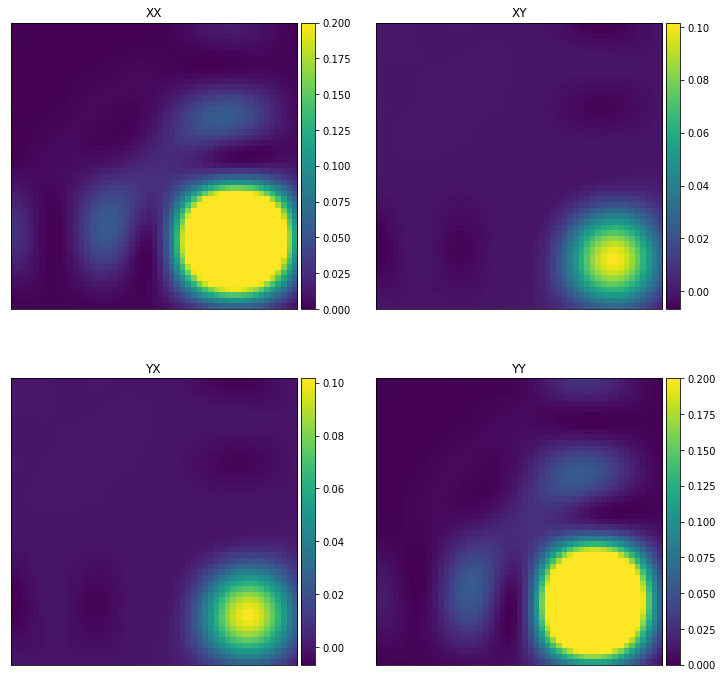

plots/jones_hyperbeam_rot_offzen2_gains_nside51_t01_f149.600MHz.png


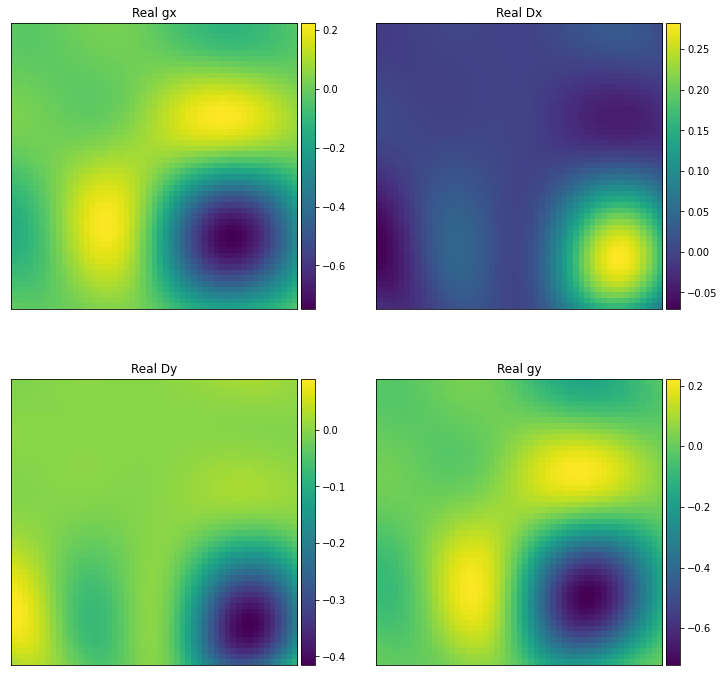

0.6224570007678955 0.6222096328247209
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t01_f149.600MHz.png


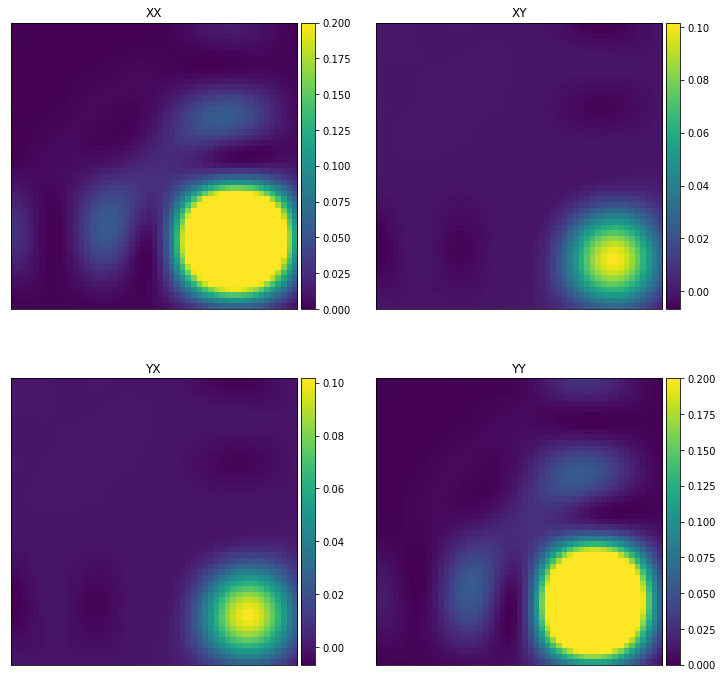

plots/jones_hyperbeam_rot_offzen2_gains_nside51_t01_f150.000MHz.png


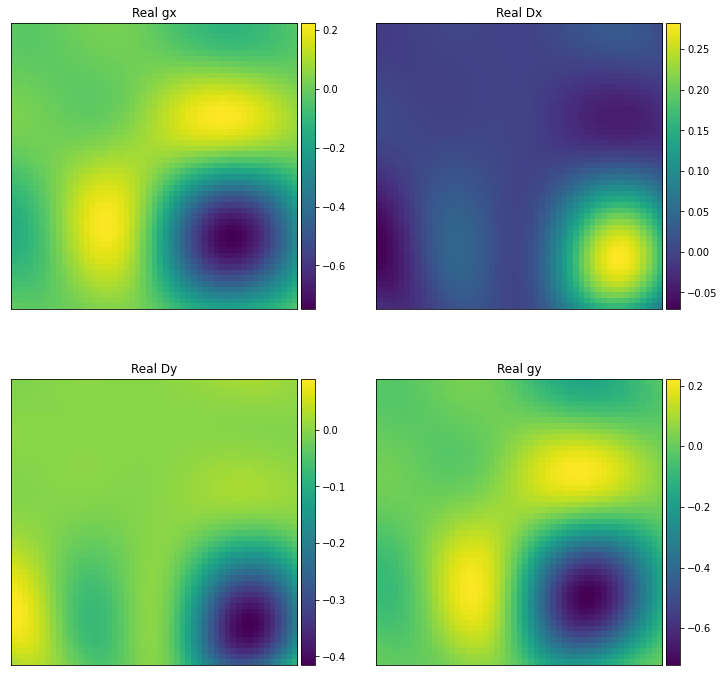

0.6224570007678955 0.6222096328247209
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t01_f150.000MHz.png


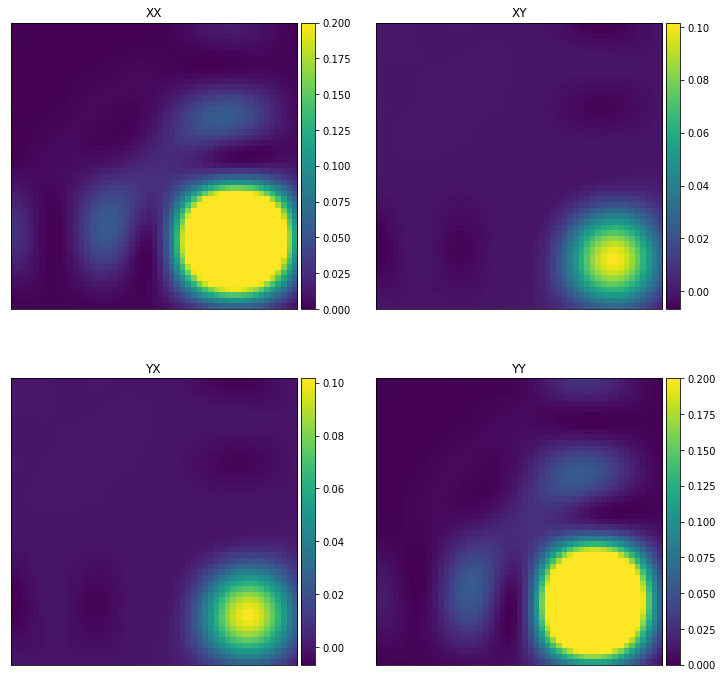

plots/jones_hyperbeam_rot_offzen2_gains_nside51_t01_f150.040MHz.png


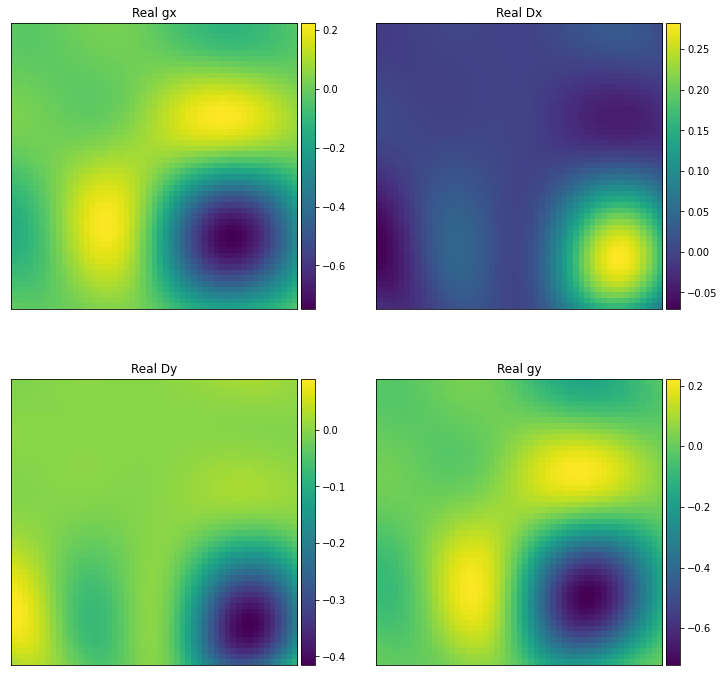

0.6224570007678955 0.6222096328247209
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t01_f150.040MHz.png


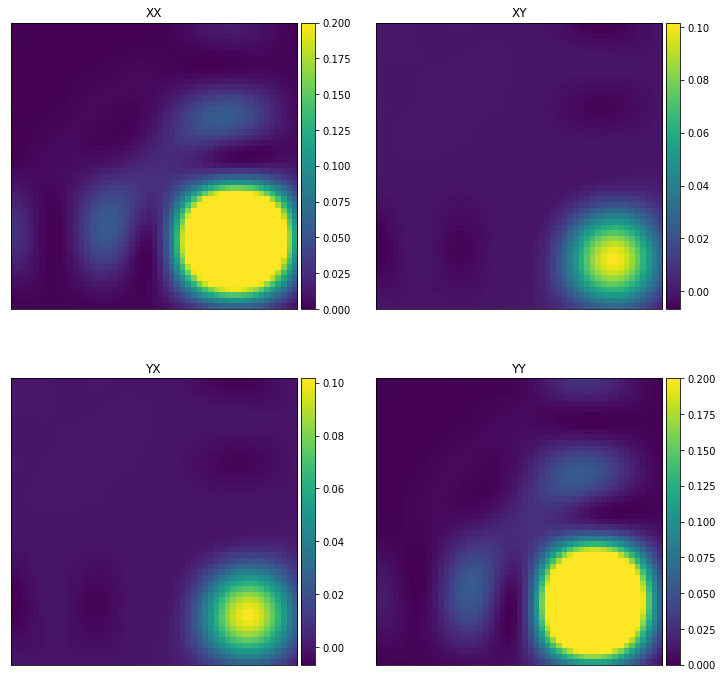

../../build/cmake_testing/primary_beam_cuda/hyperbeam_zenith_200_rot_double.txt
plots/jones_hyperbeam_rot_zenith_gains_nside51_t00_f199.600MHz.png


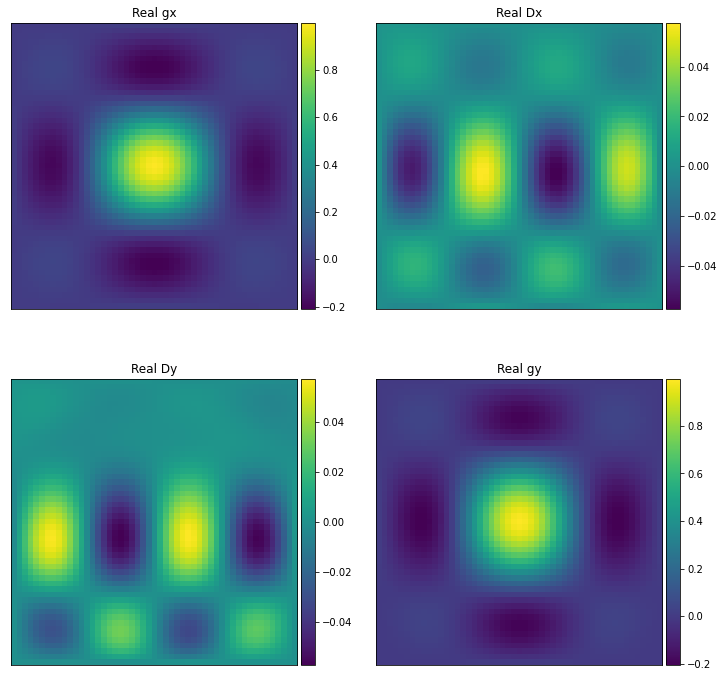

1.0000000617233418 1.0000000652775096
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t00_f199.600MHz.png


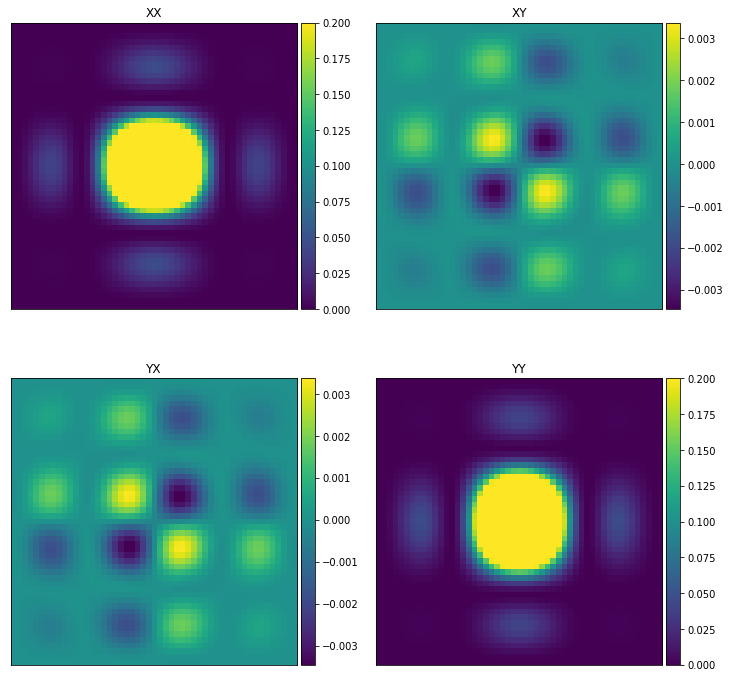

plots/jones_hyperbeam_rot_zenith_gains_nside51_t00_f200.000MHz.png


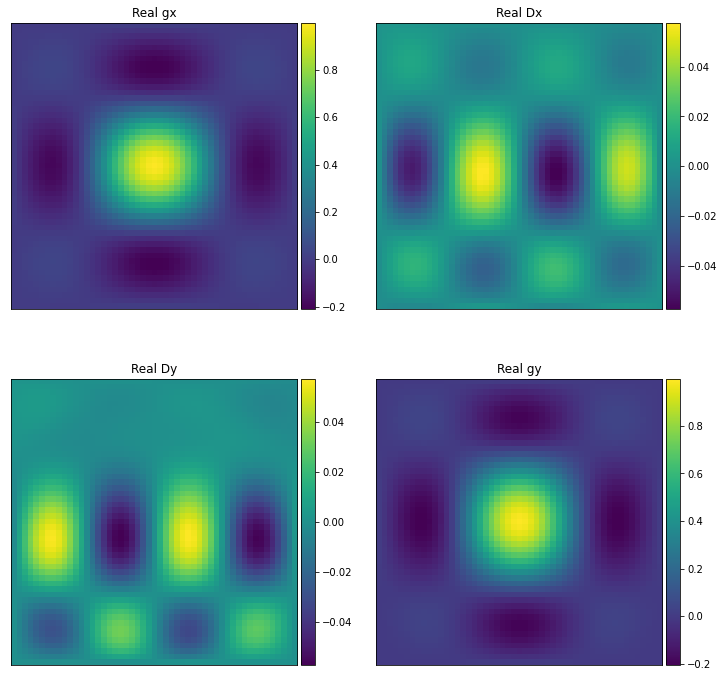

1.0000000617233418 1.0000000652775096
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t00_f200.000MHz.png


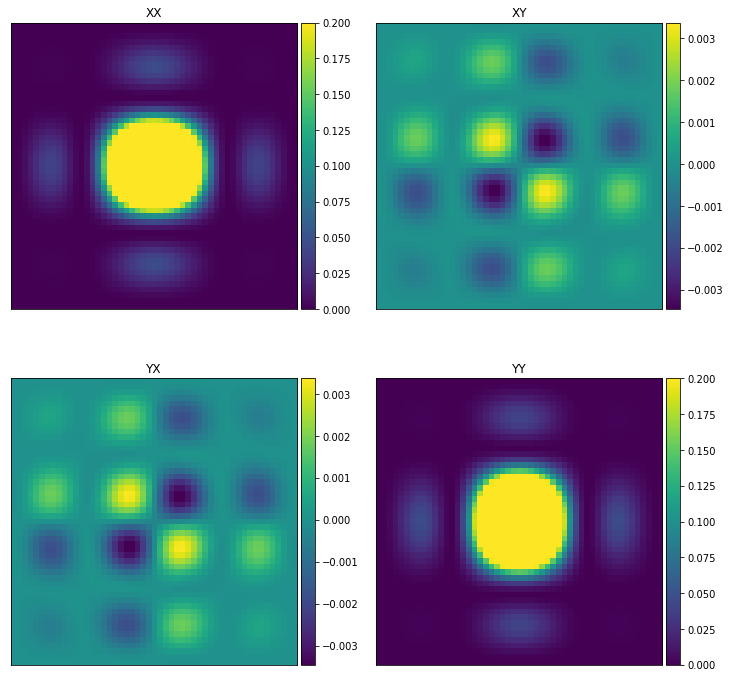

plots/jones_hyperbeam_rot_zenith_gains_nside51_t00_f200.040MHz.png


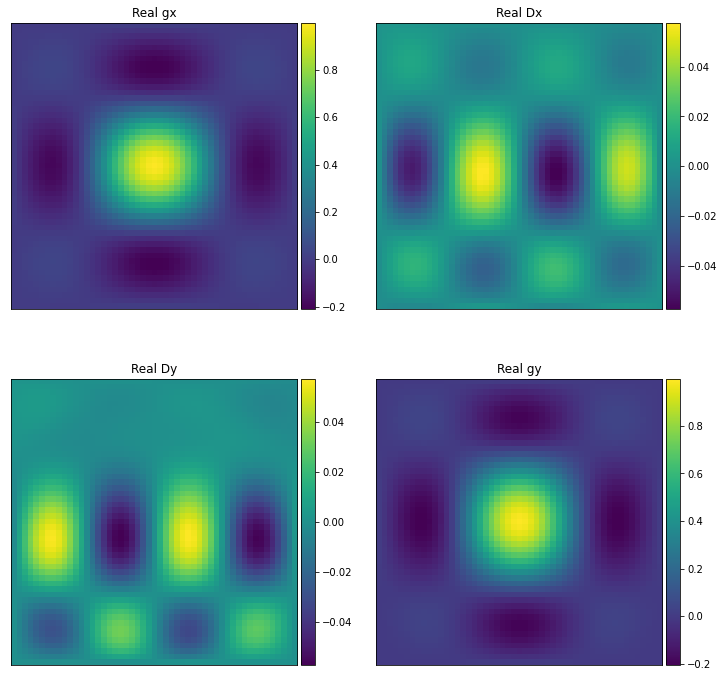

1.0000000617233418 1.0000000652775096
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t00_f200.040MHz.png


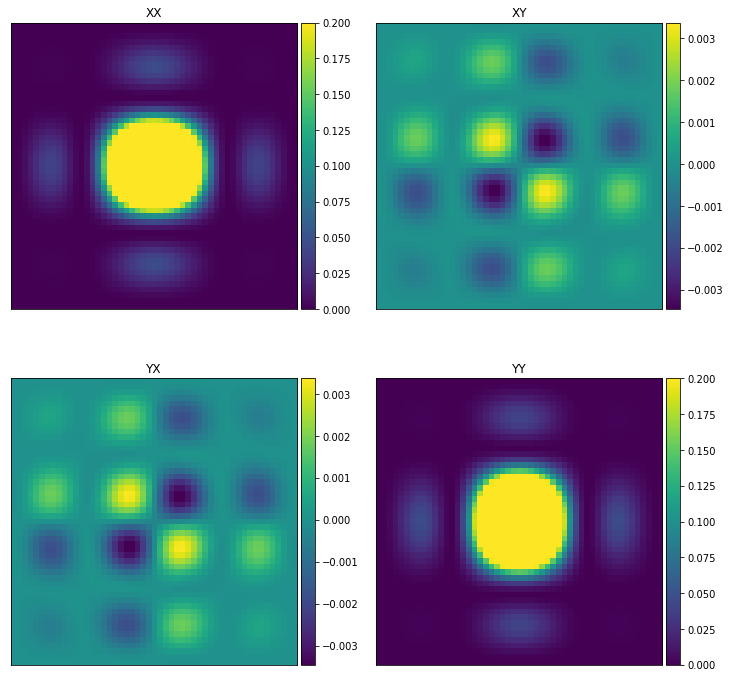

plots/jones_hyperbeam_rot_zenith_gains_nside51_t01_f199.600MHz.png


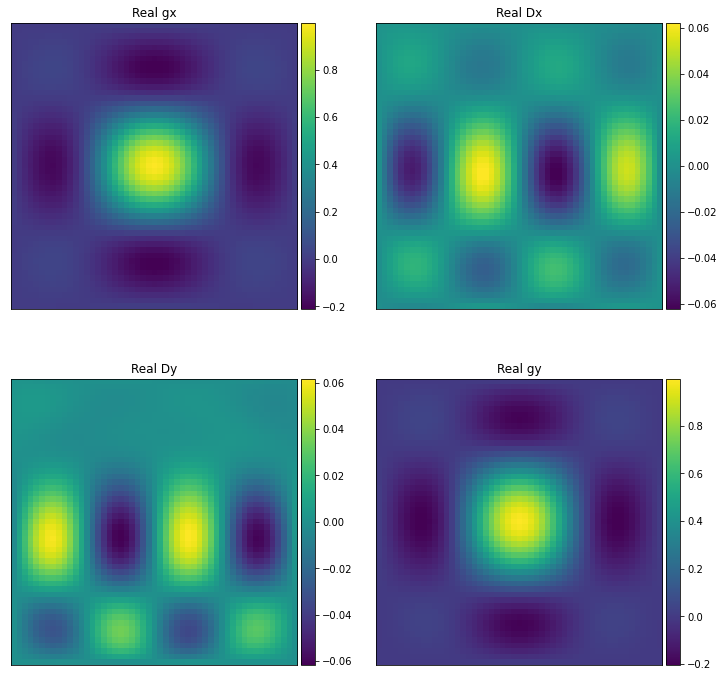

1.0000000617233418 1.0000000652775096
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t01_f199.600MHz.png


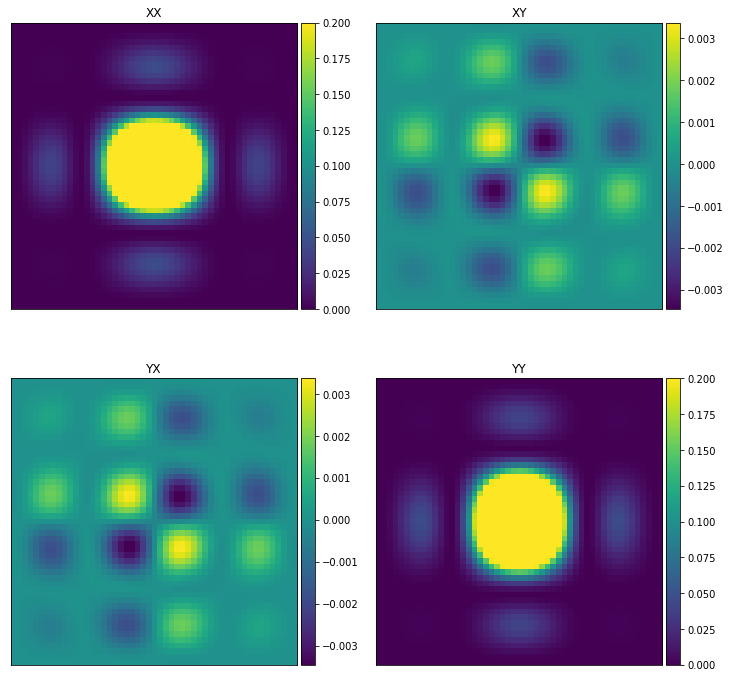

plots/jones_hyperbeam_rot_zenith_gains_nside51_t01_f200.000MHz.png


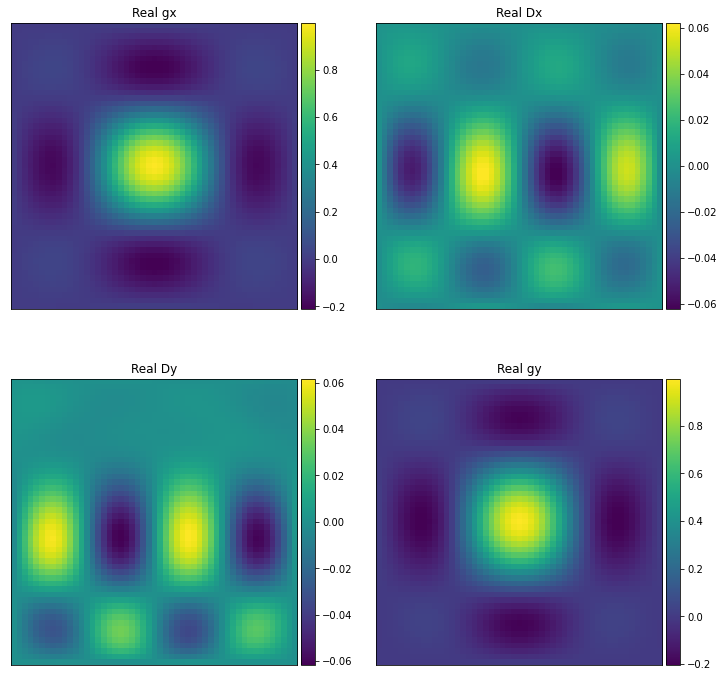

1.0000000617233418 1.0000000652775096
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t01_f200.000MHz.png


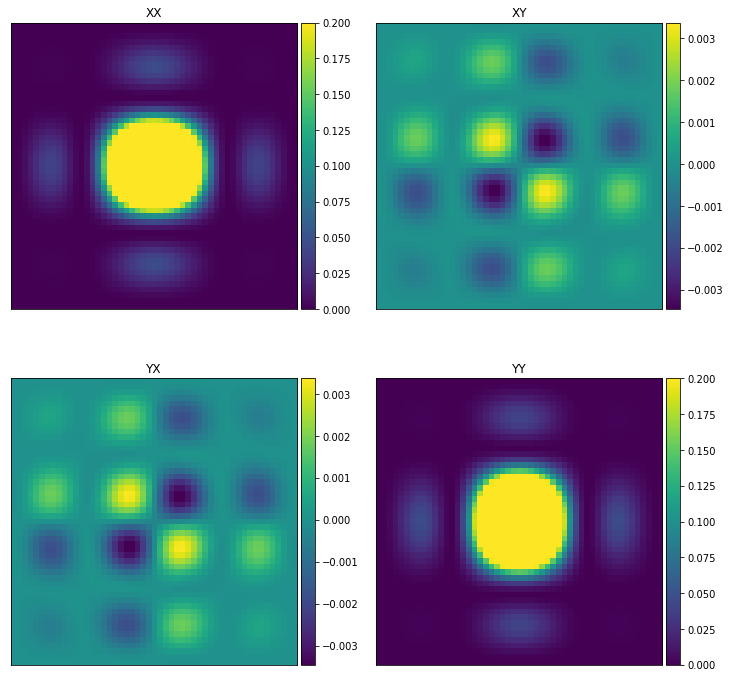

plots/jones_hyperbeam_rot_zenith_gains_nside51_t01_f200.040MHz.png


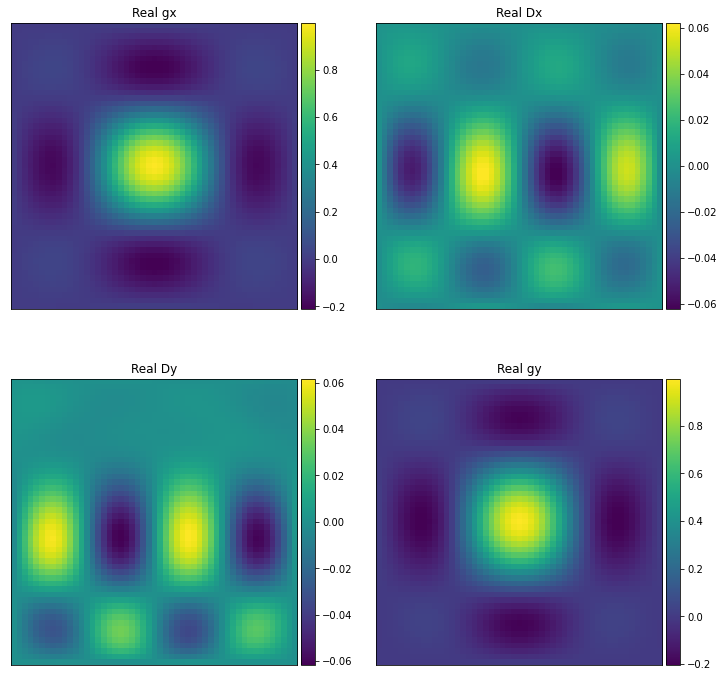

1.0000000617233418 1.0000000652775096
plots/linear_pol_hyperbeam_rot_zenith_gains_nside51_t01_f200.040MHz.png


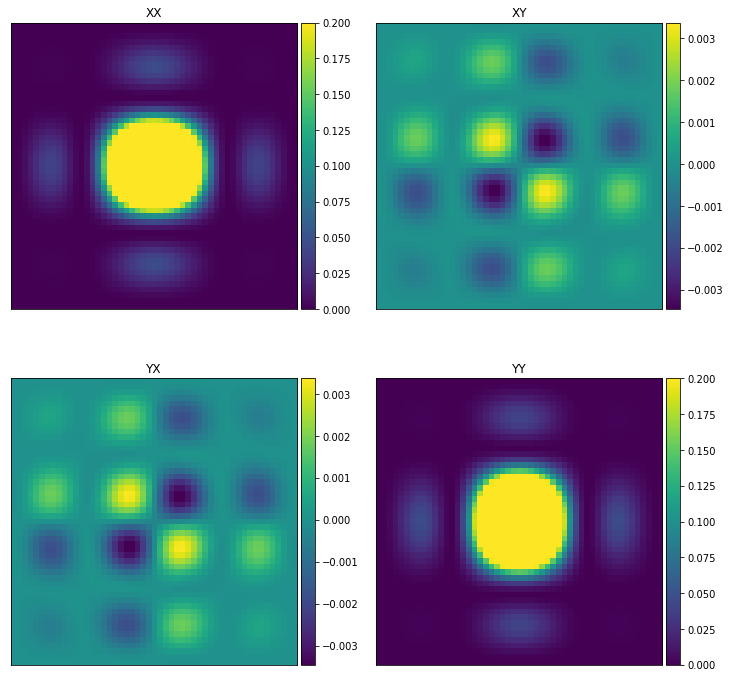

../../build/cmake_testing/primary_beam_cuda/hyperbeam_offzen1_200_rot_double.txt
plots/jones_hyperbeam_rot_offzen1_gains_nside51_t00_f199.600MHz.png


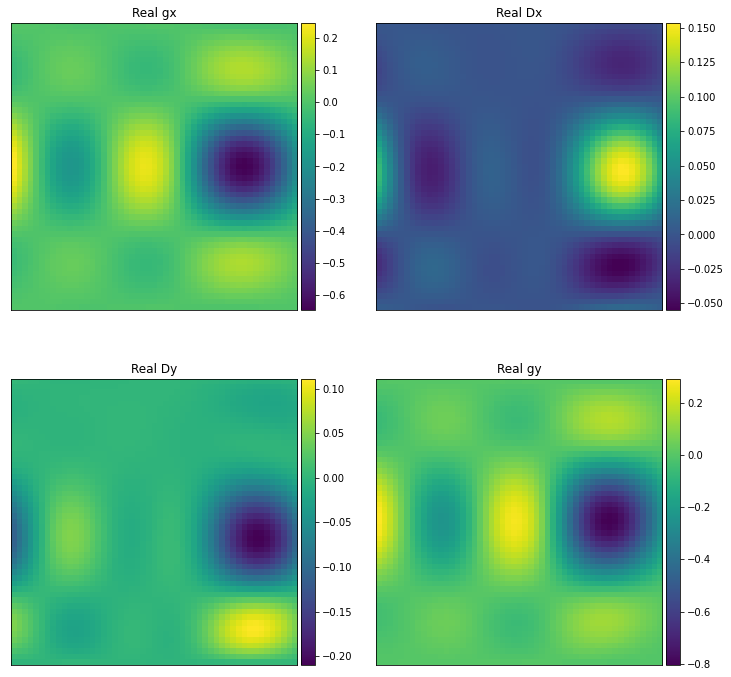

0.5470789418641092 0.7489674223447793
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t00_f199.600MHz.png


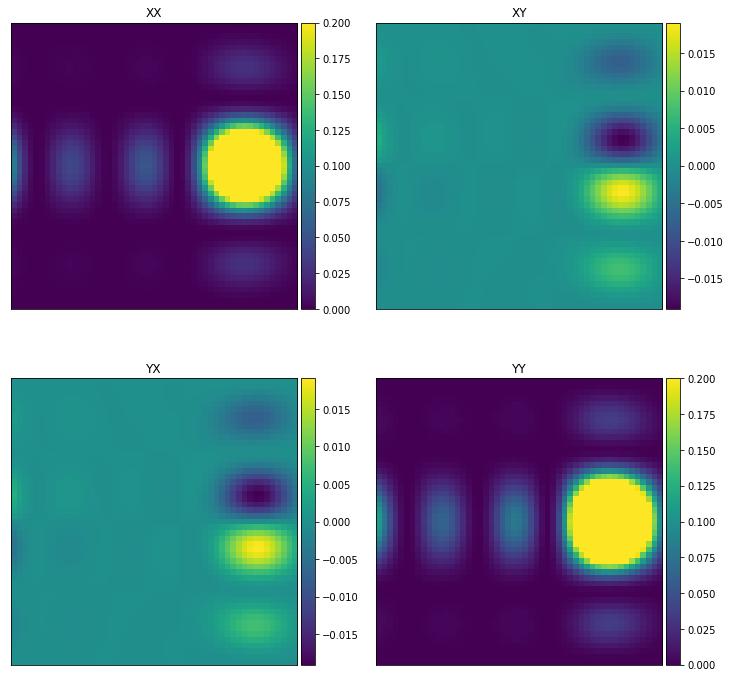

plots/jones_hyperbeam_rot_offzen1_gains_nside51_t00_f200.000MHz.png


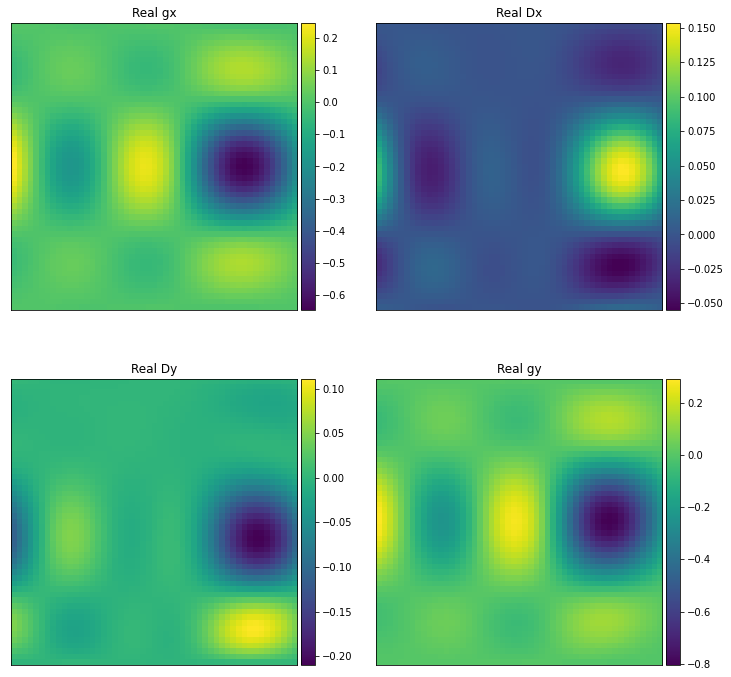

0.5470789418641092 0.7489674223447793
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t00_f200.000MHz.png


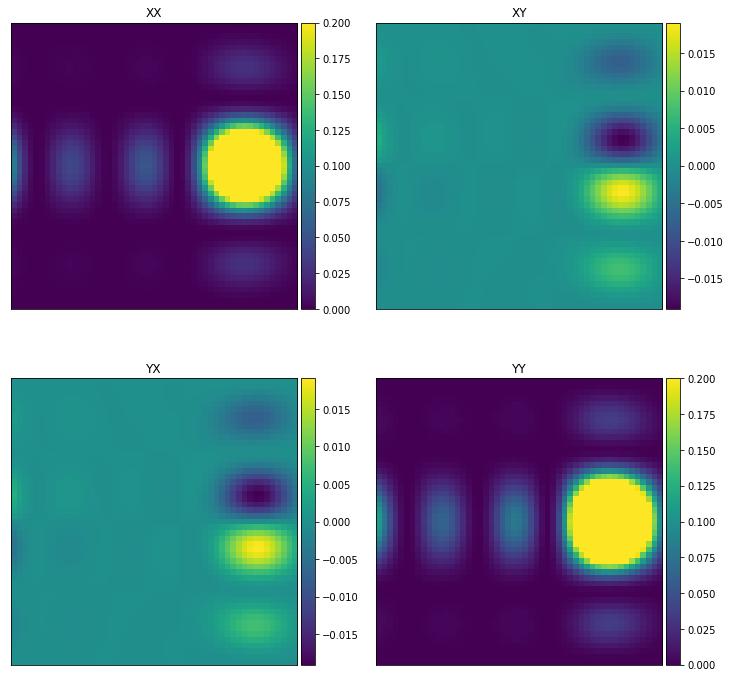

plots/jones_hyperbeam_rot_offzen1_gains_nside51_t00_f200.040MHz.png


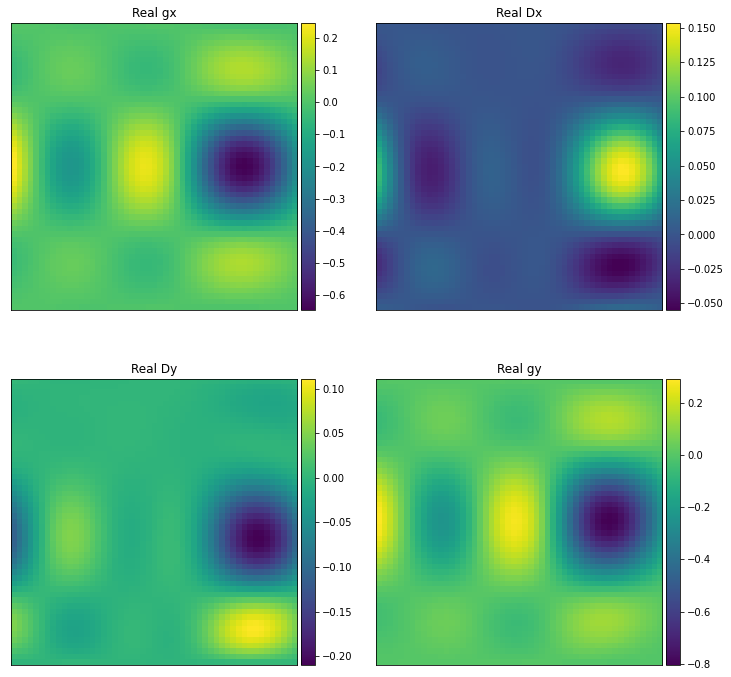

0.5470789418641092 0.7489674223447793
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t00_f200.040MHz.png


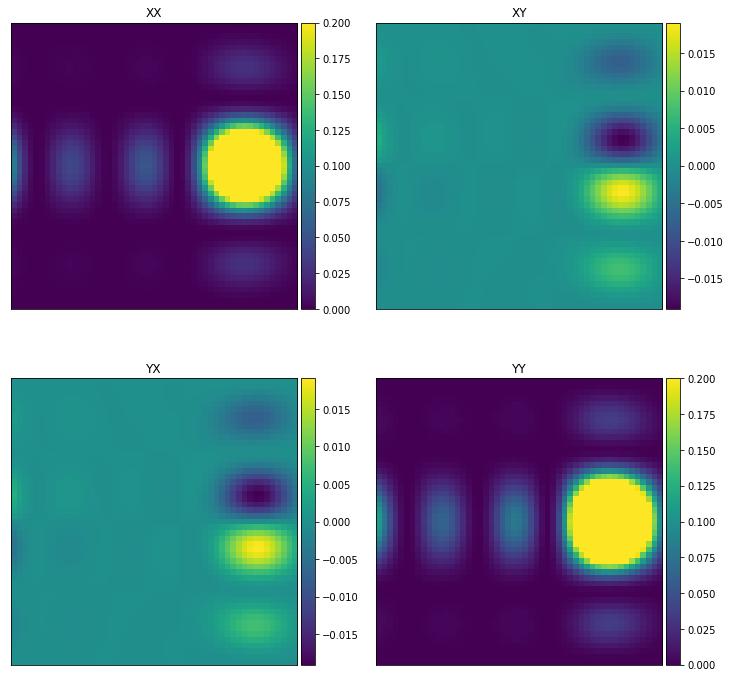

plots/jones_hyperbeam_rot_offzen1_gains_nside51_t01_f199.600MHz.png


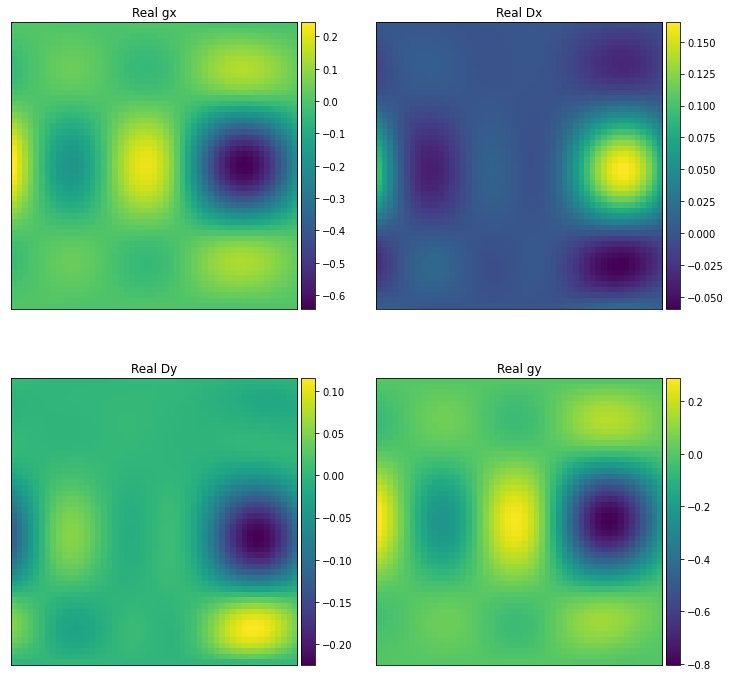

0.5470789418648637 0.7489674223451981
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t01_f199.600MHz.png


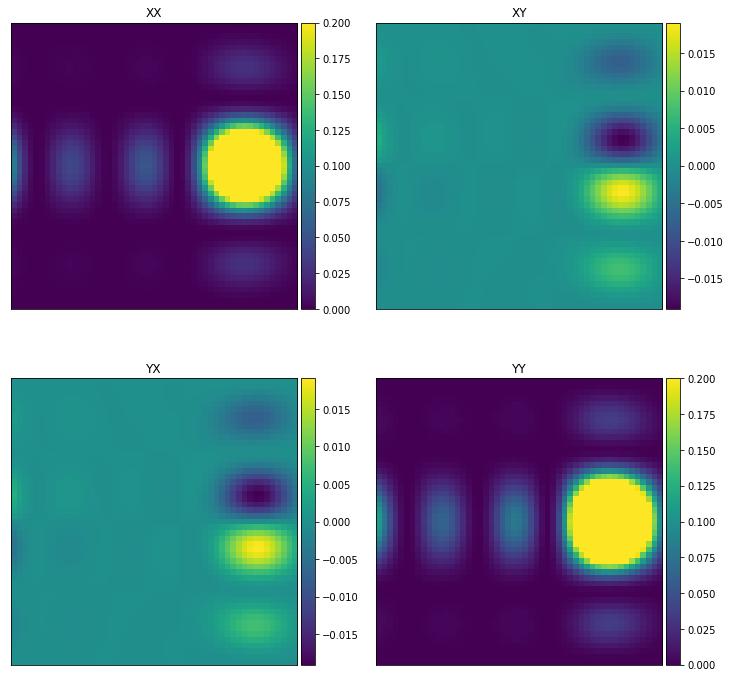

plots/jones_hyperbeam_rot_offzen1_gains_nside51_t01_f200.000MHz.png


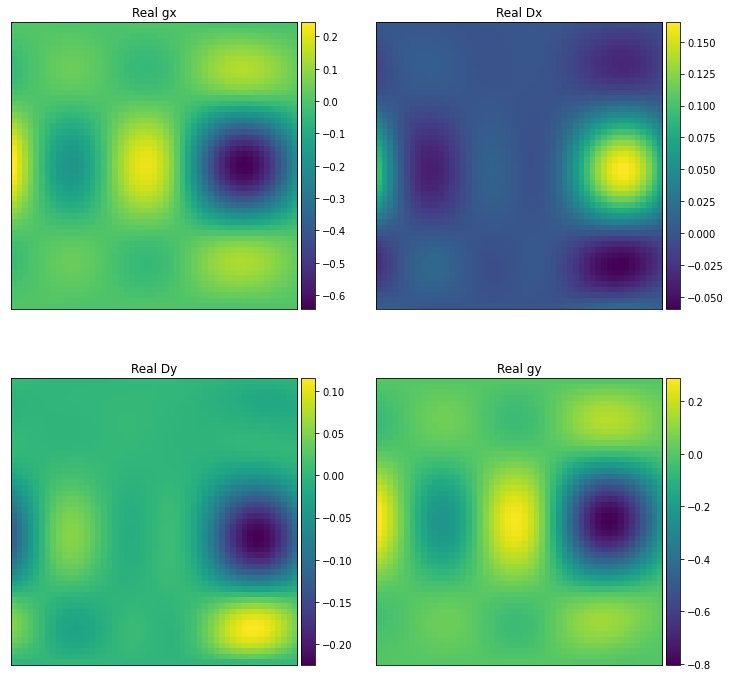

0.5470789418648637 0.7489674223451981
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t01_f200.000MHz.png


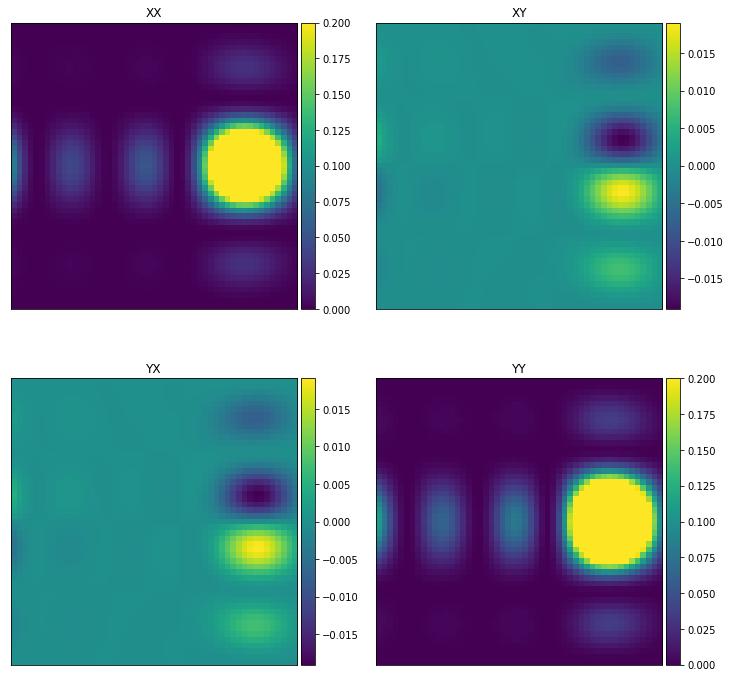

plots/jones_hyperbeam_rot_offzen1_gains_nside51_t01_f200.040MHz.png


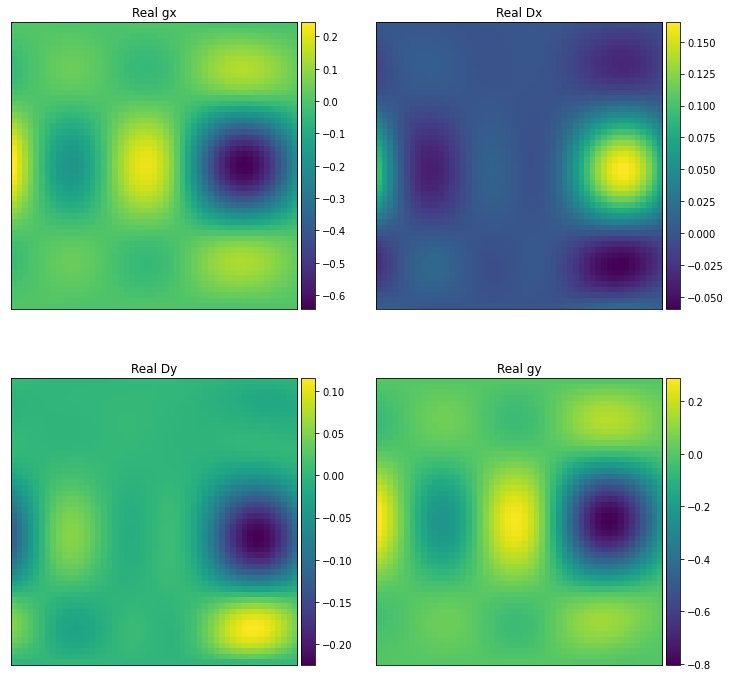

0.5470789418648637 0.7489674223451981
plots/linear_pol_hyperbeam_rot_offzen1_gains_nside51_t01_f200.040MHz.png


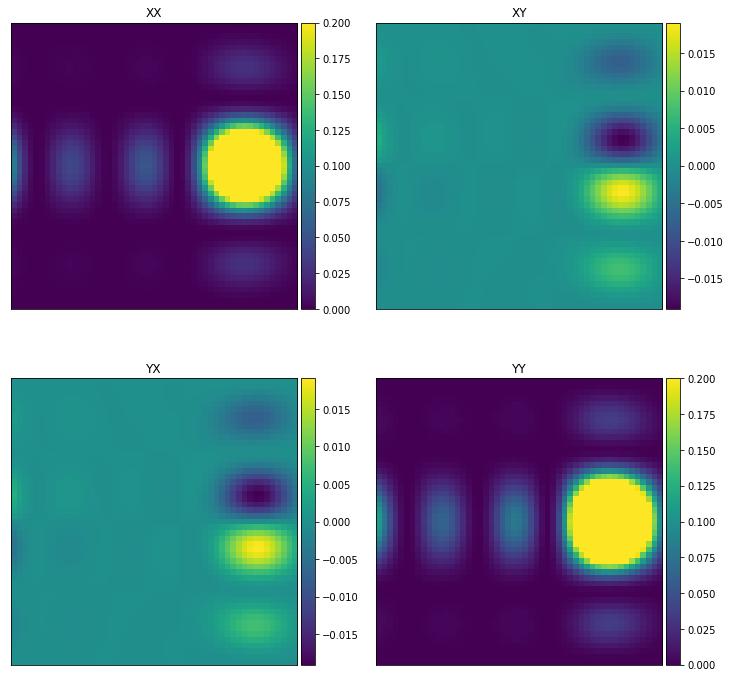

../../build/cmake_testing/primary_beam_cuda/hyperbeam_offzen2_200_rot_double.txt
plots/jones_hyperbeam_rot_offzen2_gains_nside51_t00_f199.600MHz.png


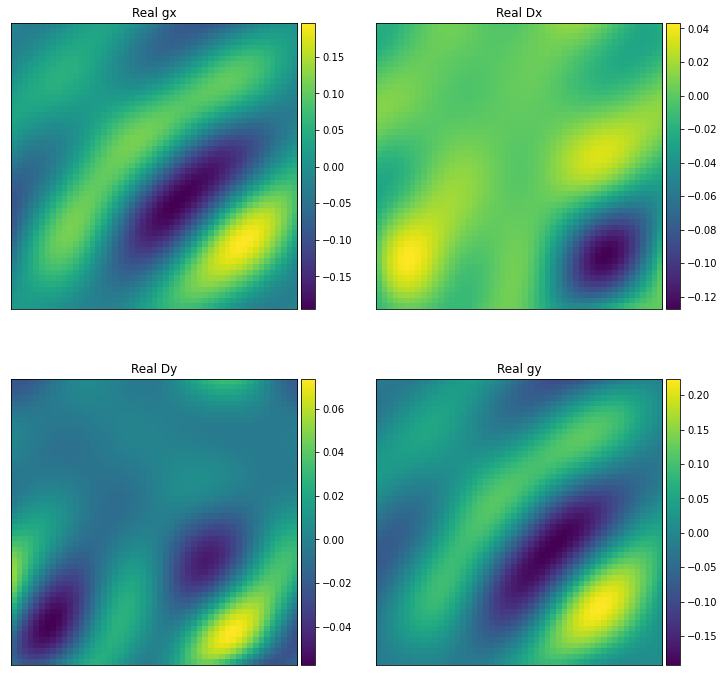

0.5115042722937724 0.5125650166307132
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t00_f199.600MHz.png


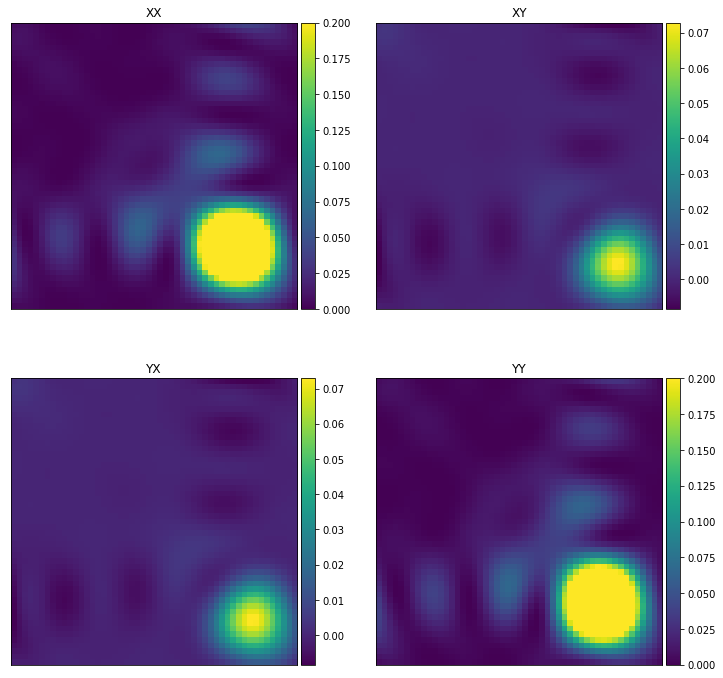

plots/jones_hyperbeam_rot_offzen2_gains_nside51_t00_f200.000MHz.png


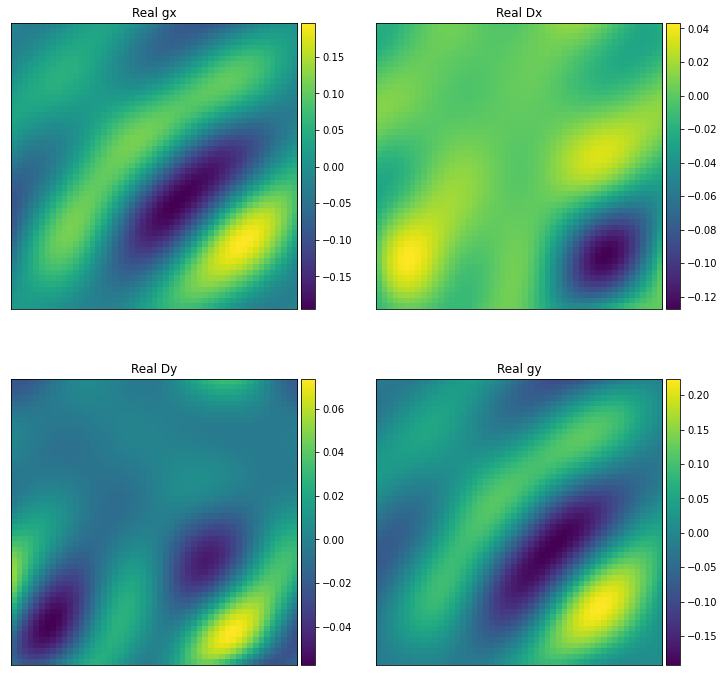

0.5115042722937724 0.5125650166307132
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t00_f200.000MHz.png


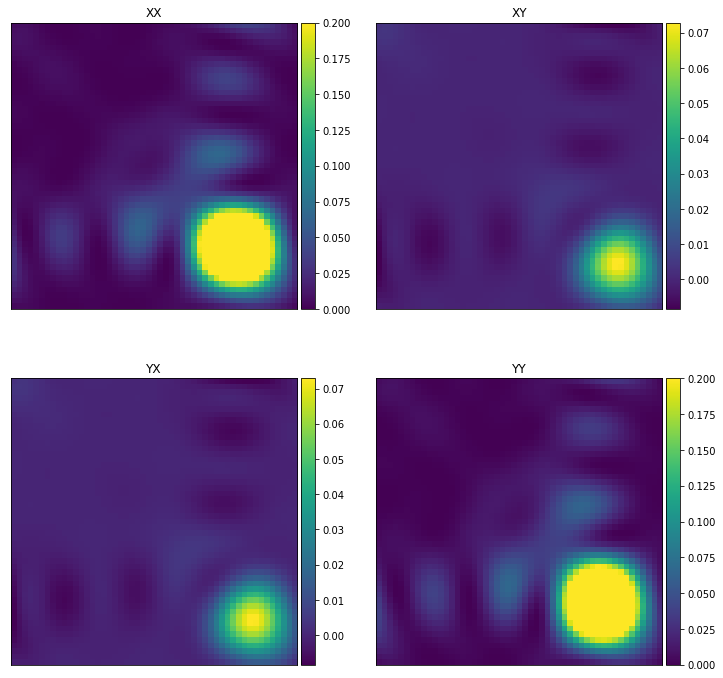

plots/jones_hyperbeam_rot_offzen2_gains_nside51_t00_f200.040MHz.png


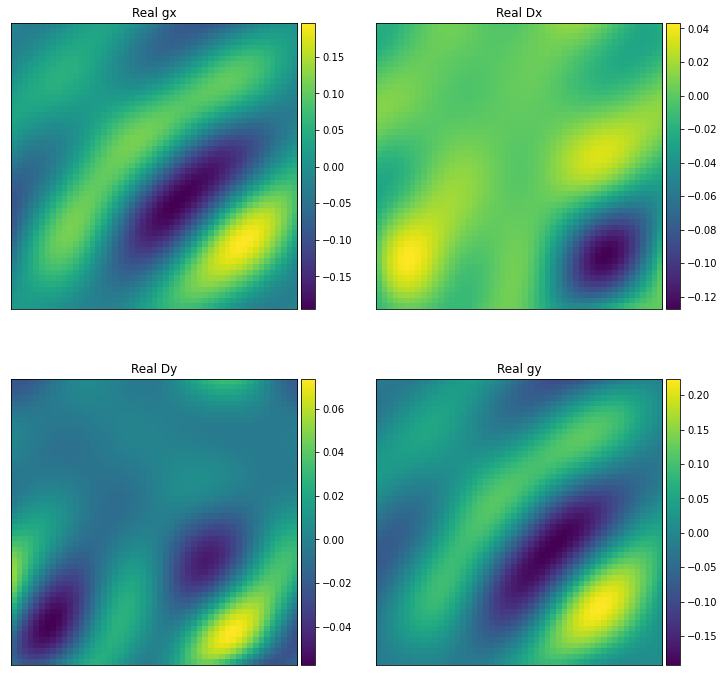

0.5115042722937724 0.5125650166307132
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t00_f200.040MHz.png


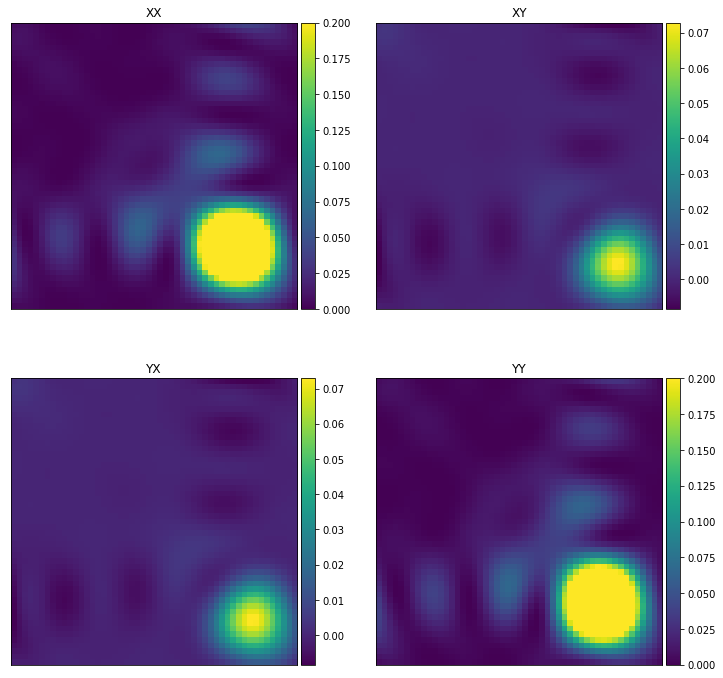

plots/jones_hyperbeam_rot_offzen2_gains_nside51_t01_f199.600MHz.png


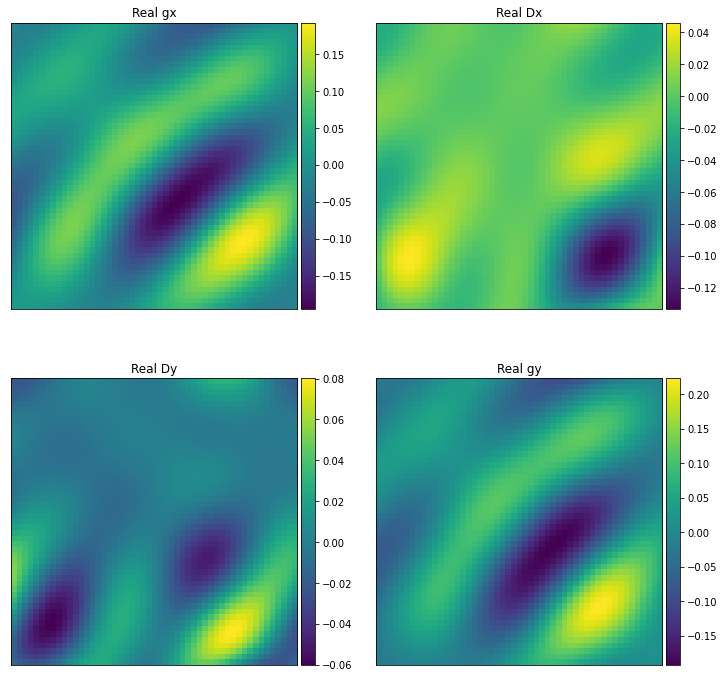

0.5115042722936096 0.5125650166302378
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t01_f199.600MHz.png


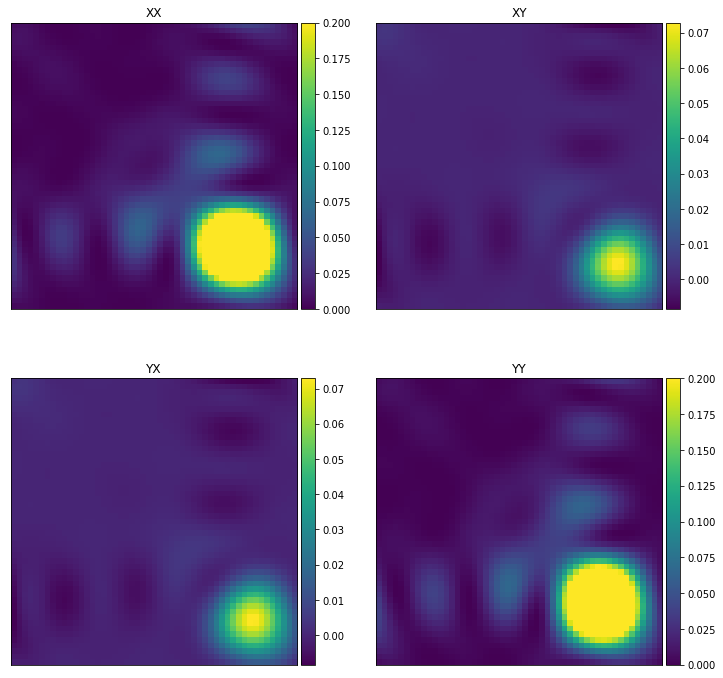

plots/jones_hyperbeam_rot_offzen2_gains_nside51_t01_f200.000MHz.png


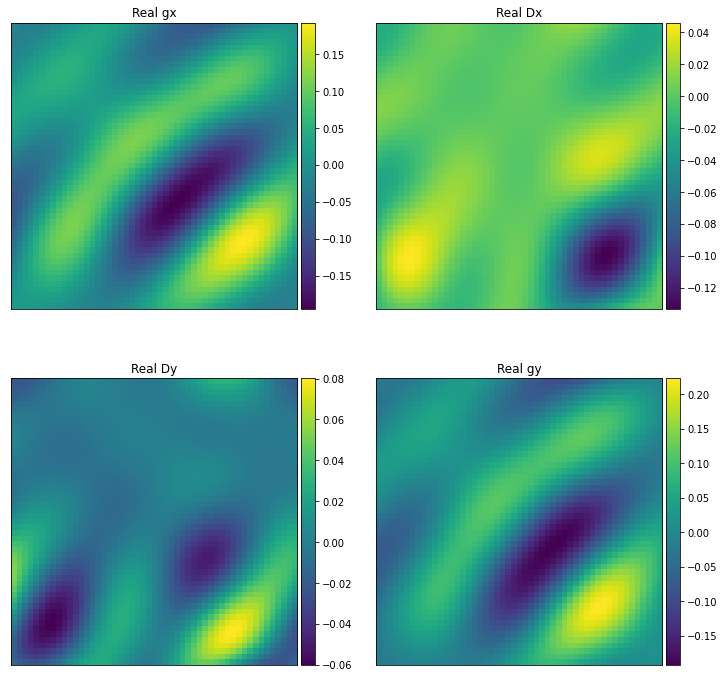

0.5115042722936096 0.5125650166302378
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t01_f200.000MHz.png


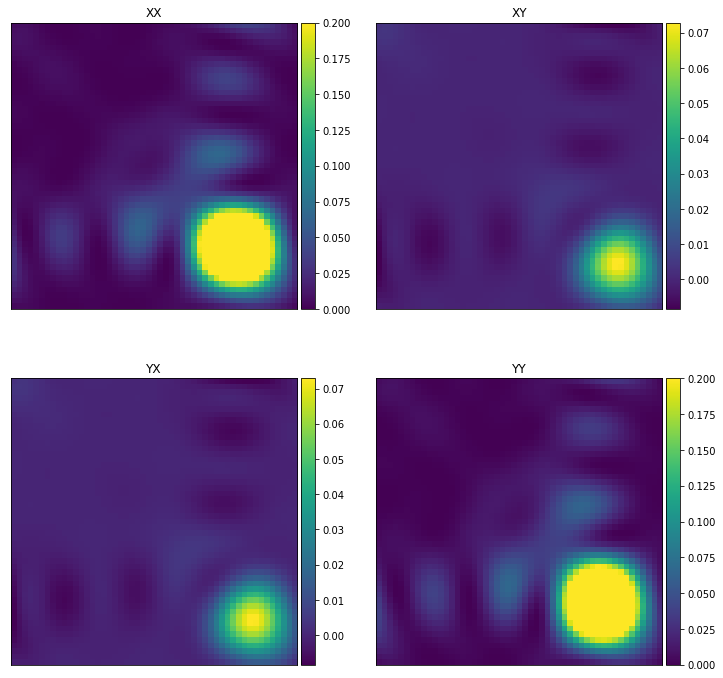

plots/jones_hyperbeam_rot_offzen2_gains_nside51_t01_f200.040MHz.png


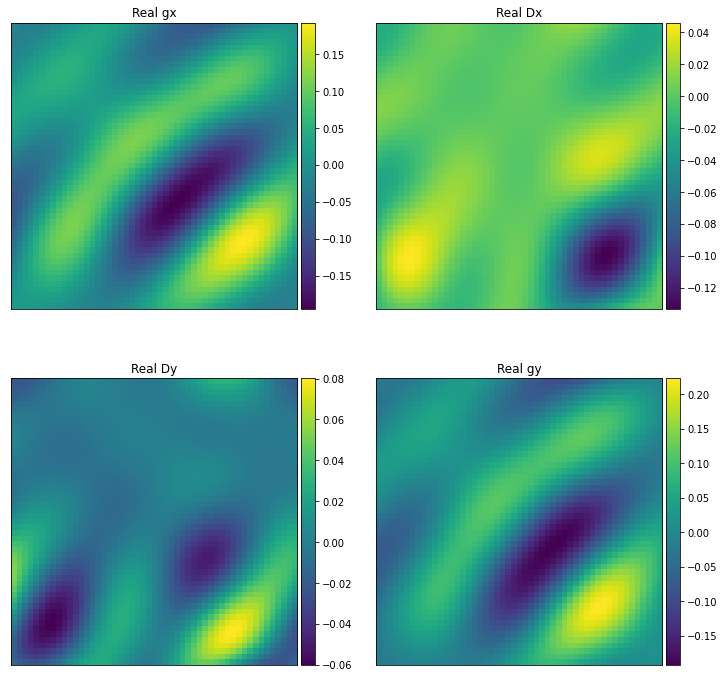

0.5115042722936096 0.5125650166302378
plots/linear_pol_hyperbeam_rot_offzen2_gains_nside51_t01_f200.040MHz.png


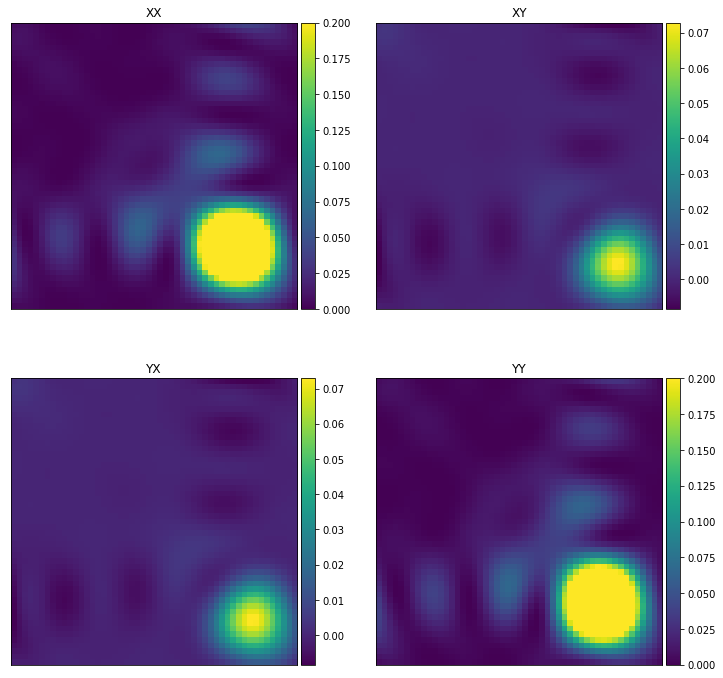

In [9]:
call('mkdir -p plots', shell=True)

for freq in [100e+6, 150e+6, 200e+6]:
    ##Ran code with three very similar freqs, all freqs should
    ##lie withing a frequency band of the model so be identical
    plot_freqs = [freq-40e+4, freq, freq + 40e+3]
    
    for delay_name in all_delay_names:

        filename = f"../../build/cmake_testing/primary_beam_cuda/hyperbeam_{delay_name}_{int(freq/1e+6)}_rot_double.txt"
        print(filename)
        azs, zas, gx, Dx, Dy, gy, freqs = load_data(filename)
        plot_jones_square(azs, zas, gx, Dx, Dy, gy, 
                          plot_freqs, filename, 
                          tag=f'hyperbeam_rot_{delay_name}',
                          num_times=2, num_freqs=3, nside=51)

# Do hyperbeam again for the interpolated hdf5 file
As of March 22nd, there are two hdf5 files storing MWA FEE beams. The default is at a 1.28MHz resolution. A new interpolated file, which is a 80kHz resolution

### First up, make hyperbeam python outputs to compare to

In [4]:
from os import environ
##Change hyperbeam env variable to point to interpolated one
environ['MWA_BEAM_FILE'] = environ['MWA_FEE_HDF5_INTERP']
NUM_COORDS = 5


freqs1 = np.arange(167e+6, 167e+6 + 32*80e+3, 80e+3)
freqs2 = np.arange(167e+6, 167e+6 + 12*1.28e+6, 1.28e+6)
freqs3 = np.arange(190e+6, 190e+6 + 12*320e+3, 320e+3)

freq_sets = [freqs1, freqs2, freqs3]

azs = [270.0*D2R, 270.0*D2R, 0.0*D2R, 90.0*D2R, 90.0*D2R]
zas = [60.0*D2R, 30.0*D2R, 0.0*D2R, 30.0*D2R, 60.0*D2R]
freq_tags = ["freqs1", "freqs2", "freqs3"]

beam = mwa_hyperbeam.FEEBeam()
gains = [1]*16

for delays, delay_name, freq_tag, freq_set in zip(all_delays, all_delay_names, freq_tags, freq_sets):
        with open(f"hyperbeam_multi_{delay_name}_{freq_tag}_rot.txt", 'w+') as outfile:
            for freq in freq_set:
                all_jones = beam.calc_jones_array(azs, zas, freq, delays, gains,
                                                  True, -0.4660608448386394, True)

                for ind in np.arange(len(azs)):

                    gx = all_jones[ind, 0]
                    Dx = all_jones[ind, 1]
                    Dy = all_jones[ind, 2]
                    gy = all_jones[ind, 3]

                    outfile.write(f"{azs[ind]:.16f} {zas[ind]:.16f} "
                                  f"{np.real(gx):.16f} {np.imag(gx):.16f} {np.real(Dx):.16f} {np.imag(Dx):.16f} "
                                  f"{np.real(Dy):.16f} {np.imag(Dy):.16f} {np.real(gy):.16f} {np.imag(gy):.16f}\n")
                    
                    
with open('test_interp_hyper_expected.h', 'w') as outfile:

    outfile.write('#include "woden_precision_defs.h"\n\n')

    filenames = ['hyperbeam_multi_zenith_freqs1_rot.txt',
             'hyperbeam_multi_offzen1_freqs2_rot.txt',
             'hyperbeam_multi_offzen2_freqs3_rot.txt']

    array_names = ['hyper_f1d1', 'hyper_f2d2', 'hyper_f3d3']

    for filename, array_name in zip(filenames, array_names):
        az, za, g1r, g1i, D1r, D1i, D2r, D2i, g2r, g2i = np.loadtxt(filename, unpack=True)
        outfile.write('double {:s}[] = {{ {:.18f}, {:.18f}, {:.18f}, {:.18f},\n    {:.18f}, {:.18f}, {:.18f}, {:.18f},\n'.format(array_name,
                                            g1r[0], g1i[0], D1r[0], D1i[0], D2r[0], D2i[0], g2r[0], g2i[0]))

        for ind in range(1,len(az)-1):
            outfile.write('    {:.18f}, {:.18f}, {:.18f}, {:.18f},\n    {:.18f}, {:.18f}, {:.18f}, {:.18f},\n'.format(g1r[ind],
                                         g1i[ind], D1r[ind], D1i[ind], D2r[ind], D2i[ind], g2r[ind], g2i[ind]))

        outfile.write('    {:.18f}, {:.18f}, {:.18f}, {:.18f},\n    {:.18f}, {:.18f}, {:.18f}, {:.18f} }};\n'.format(g1r[-1],
                                     g1i[-1], D1r[-1], D1i[-1], D2r[-1], D2i[-1], g2r[-1], g2i[-1]))

        outfile.write('\n\n')

# Run ctest, and plot results

zenith_freqs1.png


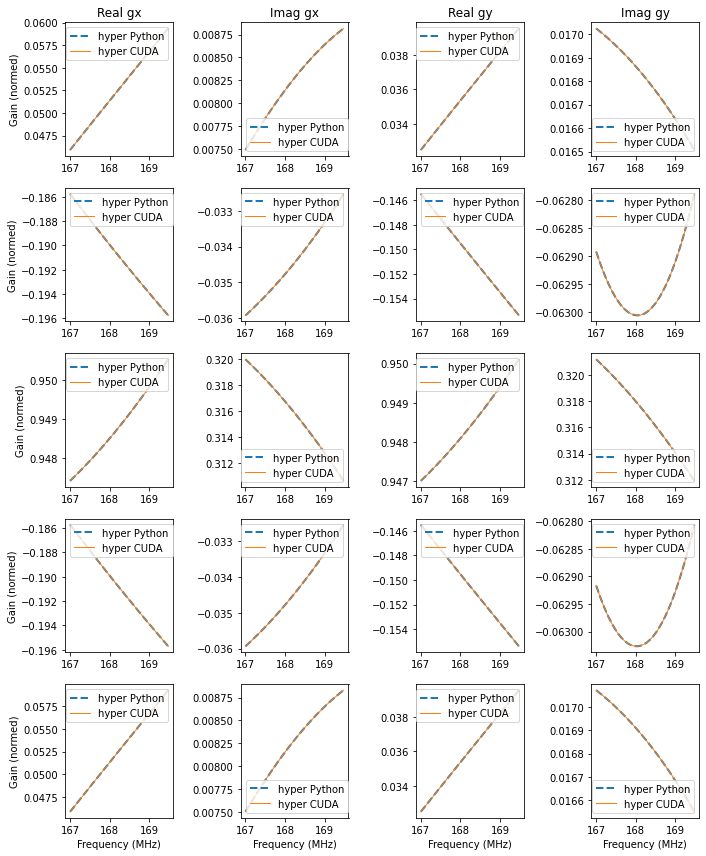

offzen1_freqs2.png


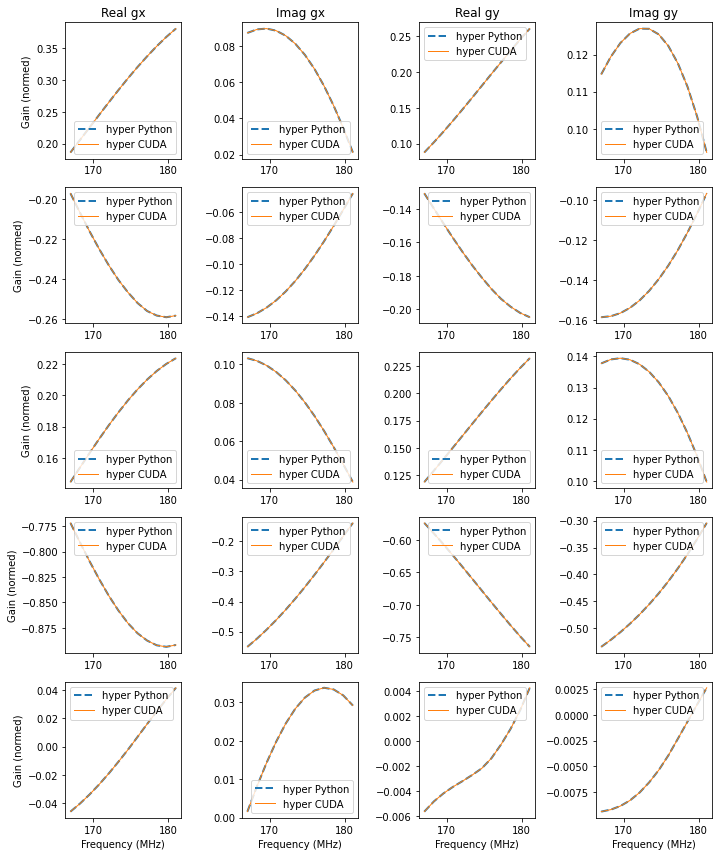

offzen2_freqs3.png


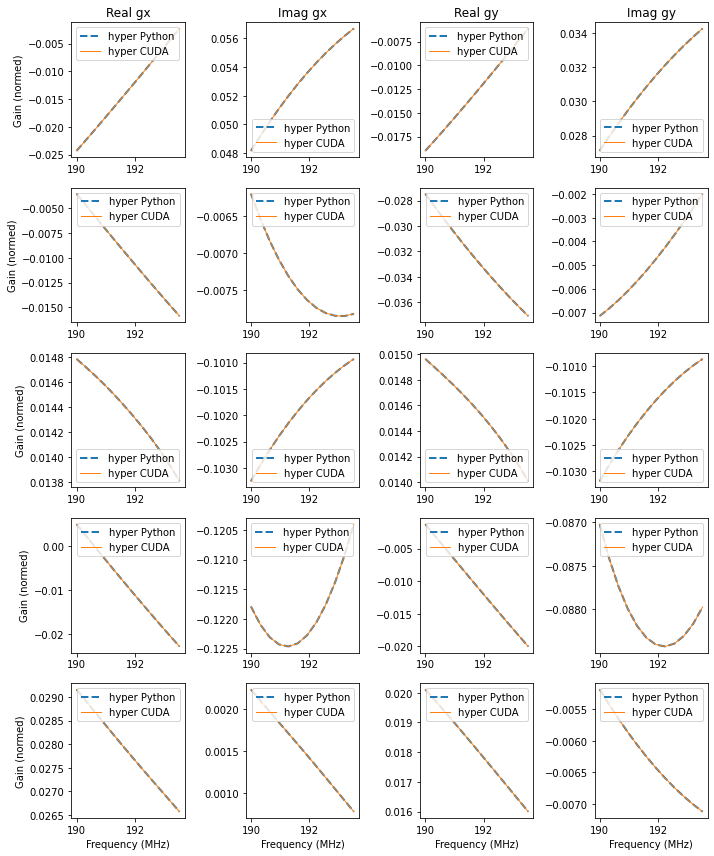

In [11]:
def plot_coord(axs, freqs, gx_re, gx_im, gy_re, gy_im,
               style, label, ms=3, lw=1):

    for coord_ind in np.arange(NUM_COORDS):

        coord = np.arange(coord_ind, len(freqs)*NUM_COORDS, NUM_COORDS)

        axs[coord_ind, 0].plot(freqs, gx_re[coord], style,
                               mfc='none', label=label, ms=ms, lw=lw)
        axs[coord_ind, 1].plot(freqs, gx_im[coord], style,
                               mfc='none', label=label, ms=ms, lw=lw)
        axs[coord_ind, 2].plot(freqs, gy_re[coord], style,
                               mfc='none', label=label, ms=ms, lw=lw)
        axs[coord_ind, 3].plot(freqs, gy_im[coord], style,
                               mfc='none', label=label, ms=ms, lw=lw)

def plot_hyperpython(fig, axs, freqs, filename):

    data = np.loadtxt(filename)

    gx_re = data[:,2]
    gx_im = data[:,3]

    gy_re = data[:,8]
    gy_im = data[:,9]

    style = 'C0--'
    label = 'hyper Python'

    plot_coord(axs, freqs, gx_re, gx_im, gy_re, gy_im, style, label, lw=2)

def plot_hypercuda(fig, axs, freqs, filename):

    data = np.loadtxt(filename)

    gx_re = data[:,0]
    gx_im = data[:,1]

    gy_re = data[:,6]
    gy_im = data[:,7]

    style = 'C1-'
#     style = 'C1o'
    label = 'hyper CUDA'

    plot_coord(axs, freqs, gx_re, gx_im, gy_re, gy_im, style, label, lw=1)

def plot_pointing_and_freq(pythonfile, cudafile, freqs, plotname):

    fig, axs = plt.subplots(5,4, figsize=(10, 12))

    plot_hyperpython(fig, axs, freqs / 1e+6, pythonfile)
    plot_hypercuda(fig, axs, freqs / 1e+6, cudafile)

    axs[0,0].set_title('Real gx')
    axs[0,1].set_title('Imag gx')
    axs[0,2].set_title('Real gy')
    axs[0,3].set_title('Imag gy')


    for ax in axs[:,0]: ax.set_ylabel('Gain (normed)')
    for ax in axs[4,:]: ax.set_xlabel('Frequency (MHz)')

    for ax in axs.flatten(): ax.legend()

    plt.tight_layout()
    fig.savefig(plotname, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()
    
    
for delay_name, freq_tag, freq_set in zip(all_delay_names, freq_tags, freq_sets):
    cudafile = f"../../build/cmake_testing/primary_beam_cuda/hyperbeam_interp_delays{all_delay_names.index(delay_name)+1}_{freq_tag}.txt"

    print(f"{delay_name}_{freq_tag}.png")
    plot_pointing_and_freq(f'hyperbeam_multi_{delay_name}_{freq_tag}_rot.txt',
            cudafile,
            freq_set, f"plots/{delay_name}_{freq_tag}.png")